In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.onnx
import torch.nn as nn
import torch.nn.functional as F
import onnx
import matplotlib.pyplot as plt

In [40]:
PATH="/Users/shalti/Desktop/pianoset/20-08/"

block = 1024
cut_block = 1024
chs = 2 #10
buf = block * chs
C = 88;

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(chs,1,1,padding=0)
        self.pool = nn.MaxPool1d(1)
        self.fc = nn.Linear(cut_block, C*2, bias=False)
        self.fc2 = nn.Linear(C*2, C, bias=False)

    def forward(self, x):
        x = x.view(-1,chs,buf/chs)# resize to 10 channels
        x = torch.narrow(x,2,0,cut_block)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, cut_block)
        x =self.fc(x)
        x = self.fc2(x)
        return x


net = Net()
print(net)

# create a stochastic gradient descent optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.5, momentum=0.3)
# create a loss function
criterion = nn.BCEWithLogitsLoss()

Net(
  (conv1): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
  (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1024, out_features=176, bias=False)
  (fc2): Linear(in_features=176, out_features=88, bias=False)
)


In [8]:
def test_func(test_loader):
    test_loss = 0
    correct = 0
    inaccurate =0
    loanotes=0
    midnotes=0
    highnotes=0
    loanotesmax=0
    midnotesmax=0
    highnotesmax=0
    right_array=np.zeros([C])
    wrong_array=np.zeros([C])
    ind=0
    for data, target in test_loader:
        net_out = net(data)
        # sum up batch loss
        test_loss += criterion(net_out, target).data.item()
        pred = F.log_softmax(net_out).data.max(1)[1]  # get the index of the max log-probability
        index =target.data.tolist()[0].index(1.0)
        if target.data.tolist()[0][pred] > 0.5:
            correct += 1;
            right_array[index]+=1.0;
        else:
            wrong_array[index]+=1.0;
    plt.bar([x for x in range(C)],100.0*right_array/(right_array+wrong_array+1e-4))
    plt.show()
    print(correct)
    print(inaccurate)
    
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def midi_to_freq(note):
    low21=27.5
    return low21*pow(2, (note-21)/12.0) # piano midi is shifted 21.

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
       return v
    return v / norm

In [10]:
# Loading all training set and labels.
path_dataset = "/Users/shalti/Desktop/pianoset/20-08/"
# file_list = ["2048X10gent","2048X10mev","2048X10upvst","2048X10lowup","2048X10grand","2048X10lowgrand","2048X10lowgiant","2048X10giant"]
file_list = ["vstup2048X2","vstup2048X2b"]

def append_data(data_trains, data_labels, filename, low=0, up=-1):
    new_data_piano = np.loadtxt(path_dataset+"trains_"+filename, dtype=np.float32)
    new_data_label = np.loadtxt(path_dataset+"labels_"+filename, dtype=np.float32)
    if data_trains.ndim!=new_data_piano.ndim: return new_data_piano[low:up], new_data_label[low:up]
    return np.concatenate((data_trains, new_data_piano[low:up]), axis=0), np.concatenate((data_labels, new_data_label[low:up]), axis=0)

data_piano=np.array([],dtype=np.float32)
data_label_piano=np.array([],dtype=np.float32)

for file_name in file_list:
    data_piano, data_label_piano = append_data(data_piano, data_label_piano, file_name, low=0, up=-1);
    print (file_name+" loaded")
    
# quick sanity check of indices match between label and training sets.
if sum(data_label_piano[:,0] - data_piano[:,0])>0: raise (" problem, indices are not synced")
    # delete all indexes after check.
data_label_piano=np.delete(data_label_piano,0,1)
data_piano=np.delete(data_piano,0,1)


vstup2048X2 loaded
vstup2048X2b loaded


In [42]:

# and cut to buf size.
train_data = np.copy(data_piano[300:, 0:buf])
train_labels = np.copy(data_label_piano[300:, :])
# for i in range(0,10):
#     train_data=np.delete(train_data,[x for x in range(i*256+256,i*256+1024)],1)

In [43]:
# creating test dataset
test_data = np.loadtxt(PATH+"trains_"+"vstup2048X2b", dtype=np.float32)
test_label = np.loadtxt(PATH+"labels_"+"vstup2048X2b", dtype=np.float32)
if sum(test_label[:,0] - test_data[:,0])>0: raise ("problem, indices are not synced")
eval_data = test_data[0:300]
eval_labels = test_label[0:300]
eval_data = np.delete(eval_data, 0, 1)

eval_labels = np.delete(eval_labels, 0, 1)

eval_data = np.copy(eval_data[:, 0:buf])
eval_labels = np.copy(eval_labels[:, :])

# for i in range(0,10):
#     eval_data=np.delete(eval_data,[x for x in range(i*256+256,i*256+1024)],1)


In [56]:
# further clearing of problematic data.

datalist = []
for i in range(len(train_data)):
   if np.isnan(train_data[i]).any():
       continue;
   if train_labels[i].tolist().index(1.0)<C:
       datalist.append([normalize(np.fabs(train_data[i])), normalize(np.fabs(train_labels[i][0:C]))])


# load data training to torch.
train_loader = torch.utils.data.DataLoader(datalist, shuffle=True, batch_size=64)

In [57]:
datalist = []
for i in range(len(eval_data)):
    if eval_labels[i].tolist().index(1.0) < C:
        datalist.append([normalize(np.fabs(eval_data[i])), normalize(np.fabs(eval_labels[i][0:C]))])

test_loader = torch.utils.data.DataLoader(datalist, shuffle=False, batch_size=1)

i1, l1 = next(iter(train_loader))
print(i1.shape)

torch.Size([64, 2048])


Train Epoch: 0 [0/5702 (0%)]	Loss: 0.693427


/Users/shalti/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


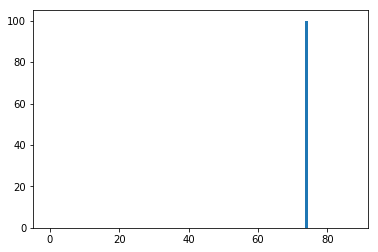

3
0

Test set: Average loss: 0.0637, Accuracy: 3/300 (1%)

Train Epoch: 1 [0/5702 (0%)]	Loss: 0.063605
Train Epoch: 2 [0/5702 (0%)]	Loss: 0.062559
Train Epoch: 3 [0/5702 (0%)]	Loss: 0.063971
Train Epoch: 4 [0/5702 (0%)]	Loss: 0.063154
Train Epoch: 5 [0/5702 (0%)]	Loss: 0.063855


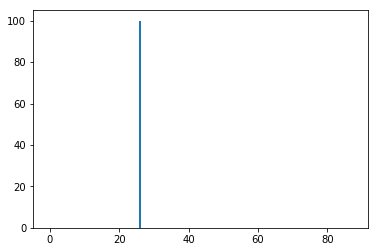

3
0

Test set: Average loss: 0.0628, Accuracy: 3/300 (1%)

Train Epoch: 6 [0/5702 (0%)]	Loss: 0.063124
Train Epoch: 7 [0/5702 (0%)]	Loss: 0.062642
Train Epoch: 8 [0/5702 (0%)]	Loss: 0.062325
Train Epoch: 9 [0/5702 (0%)]	Loss: 0.063394
Train Epoch: 10 [0/5702 (0%)]	Loss: 0.062553


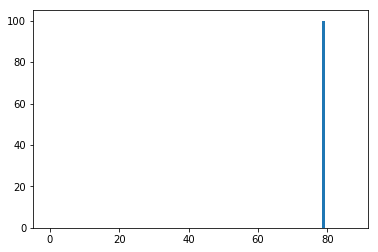

3
0

Test set: Average loss: 0.0630, Accuracy: 3/300 (1%)

Train Epoch: 11 [0/5702 (0%)]	Loss: 0.062871
Train Epoch: 12 [0/5702 (0%)]	Loss: 0.063004
Train Epoch: 13 [0/5702 (0%)]	Loss: 0.062914
Train Epoch: 14 [0/5702 (0%)]	Loss: 0.063216
Train Epoch: 15 [0/5702 (0%)]	Loss: 0.062778


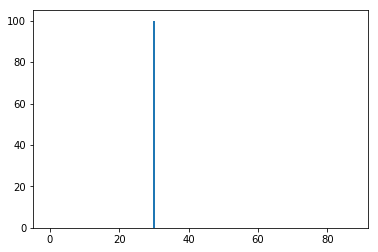

4
0

Test set: Average loss: 0.0627, Accuracy: 4/300 (1%)

Train Epoch: 16 [0/5702 (0%)]	Loss: 0.062621
Train Epoch: 17 [0/5702 (0%)]	Loss: 0.061858
Train Epoch: 18 [0/5702 (0%)]	Loss: 0.062328
Train Epoch: 19 [0/5702 (0%)]	Loss: 0.062120
Train Epoch: 20 [0/5702 (0%)]	Loss: 0.062666


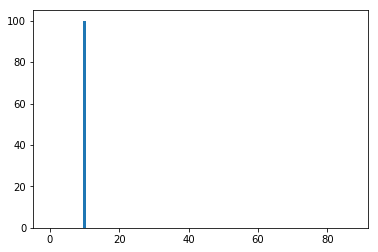

3
0

Test set: Average loss: 0.0624, Accuracy: 3/300 (1%)

Train Epoch: 21 [0/5702 (0%)]	Loss: 0.062659
Train Epoch: 22 [0/5702 (0%)]	Loss: 0.062331
Train Epoch: 23 [0/5702 (0%)]	Loss: 0.062195
Train Epoch: 24 [0/5702 (0%)]	Loss: 0.062508
Train Epoch: 25 [0/5702 (0%)]	Loss: 0.062879


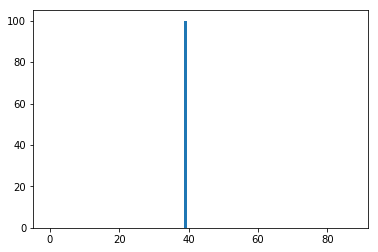

4
0

Test set: Average loss: 0.0624, Accuracy: 4/300 (1%)

Train Epoch: 26 [0/5702 (0%)]	Loss: 0.062012
Train Epoch: 27 [0/5702 (0%)]	Loss: 0.062437
Train Epoch: 28 [0/5702 (0%)]	Loss: 0.061513
Train Epoch: 29 [0/5702 (0%)]	Loss: 0.061802
Train Epoch: 30 [0/5702 (0%)]	Loss: 0.062176


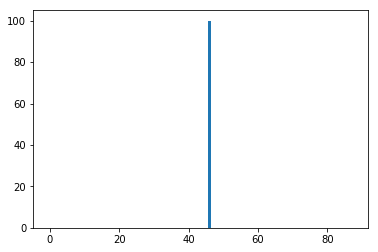

4
0

Test set: Average loss: 0.0623, Accuracy: 4/300 (1%)

Train Epoch: 31 [0/5702 (0%)]	Loss: 0.061217
Train Epoch: 32 [0/5702 (0%)]	Loss: 0.061941
Train Epoch: 33 [0/5702 (0%)]	Loss: 0.061700
Train Epoch: 34 [0/5702 (0%)]	Loss: 0.062260
Train Epoch: 35 [0/5702 (0%)]	Loss: 0.061847


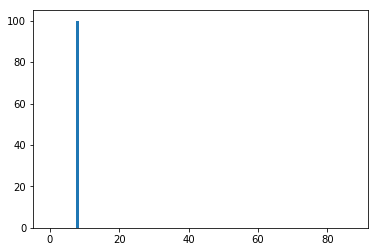

3
0

Test set: Average loss: 0.0622, Accuracy: 3/300 (1%)

Train Epoch: 36 [0/5702 (0%)]	Loss: 0.061869
Train Epoch: 37 [0/5702 (0%)]	Loss: 0.062175
Train Epoch: 38 [0/5702 (0%)]	Loss: 0.062142
Train Epoch: 39 [0/5702 (0%)]	Loss: 0.061549
Train Epoch: 40 [0/5702 (0%)]	Loss: 0.061913


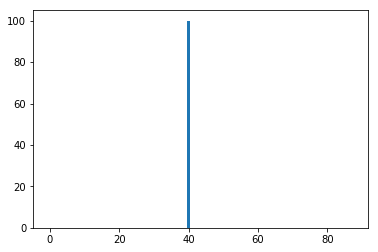

4
0

Test set: Average loss: 0.0619, Accuracy: 4/300 (1%)

Train Epoch: 41 [0/5702 (0%)]	Loss: 0.061671
Train Epoch: 42 [0/5702 (0%)]	Loss: 0.062603
Train Epoch: 43 [0/5702 (0%)]	Loss: 0.061747
Train Epoch: 44 [0/5702 (0%)]	Loss: 0.061609
Train Epoch: 45 [0/5702 (0%)]	Loss: 0.061699


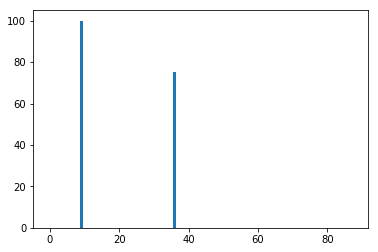

6
0

Test set: Average loss: 0.0618, Accuracy: 6/300 (2%)

Train Epoch: 46 [0/5702 (0%)]	Loss: 0.062167
Train Epoch: 47 [0/5702 (0%)]	Loss: 0.061493
Train Epoch: 48 [0/5702 (0%)]	Loss: 0.061835
Train Epoch: 49 [0/5702 (0%)]	Loss: 0.061815
Train Epoch: 50 [0/5702 (0%)]	Loss: 0.061386


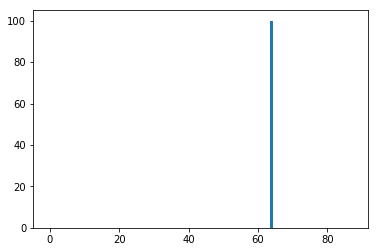

3
0

Test set: Average loss: 0.0616, Accuracy: 3/300 (1%)

Train Epoch: 51 [0/5702 (0%)]	Loss: 0.061488
Train Epoch: 52 [0/5702 (0%)]	Loss: 0.061438
Train Epoch: 53 [0/5702 (0%)]	Loss: 0.061256
Train Epoch: 54 [0/5702 (0%)]	Loss: 0.061516
Train Epoch: 55 [0/5702 (0%)]	Loss: 0.061778


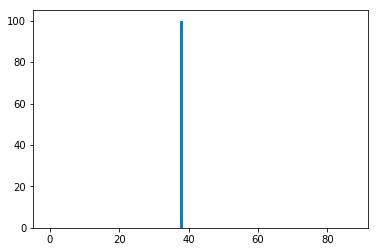

4
0

Test set: Average loss: 0.0613, Accuracy: 4/300 (1%)

Train Epoch: 56 [0/5702 (0%)]	Loss: 0.061698
Train Epoch: 57 [0/5702 (0%)]	Loss: 0.061508
Train Epoch: 58 [0/5702 (0%)]	Loss: 0.061110
Train Epoch: 59 [0/5702 (0%)]	Loss: 0.060737
Train Epoch: 60 [0/5702 (0%)]	Loss: 0.061138


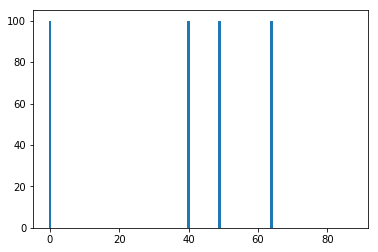

14
0

Test set: Average loss: 0.0608, Accuracy: 14/300 (5%)

Train Epoch: 61 [0/5702 (0%)]	Loss: 0.061148
Train Epoch: 62 [0/5702 (0%)]	Loss: 0.060778
Train Epoch: 63 [0/5702 (0%)]	Loss: 0.060876
Train Epoch: 64 [0/5702 (0%)]	Loss: 0.060241
Train Epoch: 65 [0/5702 (0%)]	Loss: 0.060644


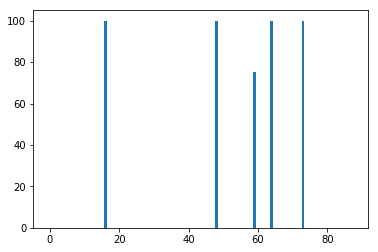

16
0

Test set: Average loss: 0.0600, Accuracy: 16/300 (5%)

Train Epoch: 66 [0/5702 (0%)]	Loss: 0.060318
Train Epoch: 67 [0/5702 (0%)]	Loss: 0.059890
Train Epoch: 68 [0/5702 (0%)]	Loss: 0.059803
Train Epoch: 69 [0/5702 (0%)]	Loss: 0.059705
Train Epoch: 70 [0/5702 (0%)]	Loss: 0.059063


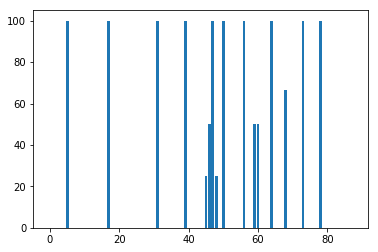

45
0

Test set: Average loss: 0.0588, Accuracy: 45/300 (15%)

Train Epoch: 71 [0/5702 (0%)]	Loss: 0.058934
Train Epoch: 72 [0/5702 (0%)]	Loss: 0.059206
Train Epoch: 73 [0/5702 (0%)]	Loss: 0.058434
Train Epoch: 74 [0/5702 (0%)]	Loss: 0.057956
Train Epoch: 75 [0/5702 (0%)]	Loss: 0.057737


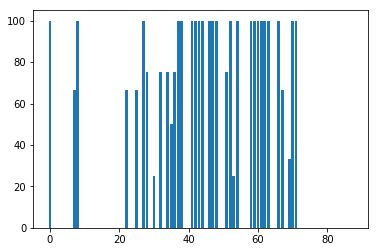

114
0

Test set: Average loss: 0.0565, Accuracy: 114/300 (38%)

Train Epoch: 76 [0/5702 (0%)]	Loss: 0.057227
Train Epoch: 77 [0/5702 (0%)]	Loss: 0.057197
Train Epoch: 78 [0/5702 (0%)]	Loss: 0.055959
Train Epoch: 79 [0/5702 (0%)]	Loss: 0.056024
Train Epoch: 80 [0/5702 (0%)]	Loss: 0.053846


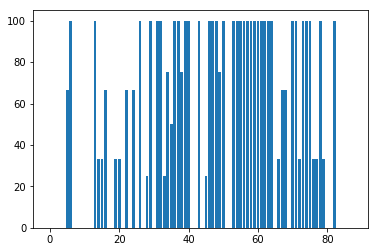

160
0

Test set: Average loss: 0.0527, Accuracy: 160/300 (53%)

Train Epoch: 81 [0/5702 (0%)]	Loss: 0.052807
Train Epoch: 82 [0/5702 (0%)]	Loss: 0.052451
Train Epoch: 83 [0/5702 (0%)]	Loss: 0.051834
Train Epoch: 84 [0/5702 (0%)]	Loss: 0.050664
Train Epoch: 85 [0/5702 (0%)]	Loss: 0.049183


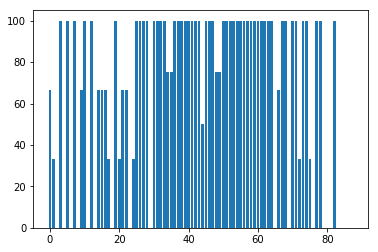

213
0

Test set: Average loss: 0.0460, Accuracy: 213/300 (71%)

Train Epoch: 86 [0/5702 (0%)]	Loss: 0.046989
Train Epoch: 87 [0/5702 (0%)]	Loss: 0.046069
Train Epoch: 88 [0/5702 (0%)]	Loss: 0.043274
Train Epoch: 89 [0/5702 (0%)]	Loss: 0.043686
Train Epoch: 90 [0/5702 (0%)]	Loss: 0.040637


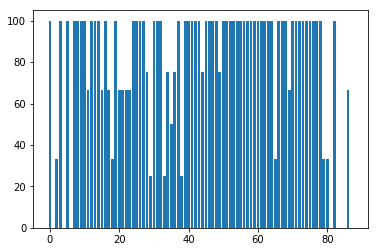

241
0

Test set: Average loss: 0.0370, Accuracy: 241/300 (80%)

Train Epoch: 91 [0/5702 (0%)]	Loss: 0.037440
Train Epoch: 92 [0/5702 (0%)]	Loss: 0.036040
Train Epoch: 93 [0/5702 (0%)]	Loss: 0.035486
Train Epoch: 94 [0/5702 (0%)]	Loss: 0.035327
Train Epoch: 95 [0/5702 (0%)]	Loss: 0.031405


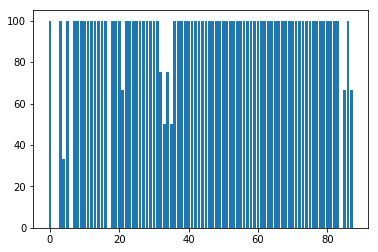

274
0

Test set: Average loss: 0.0281, Accuracy: 274/300 (91%)

Train Epoch: 96 [0/5702 (0%)]	Loss: 0.029828
Train Epoch: 97 [0/5702 (0%)]	Loss: 0.027491
Train Epoch: 98 [0/5702 (0%)]	Loss: 0.026388
Train Epoch: 99 [0/5702 (0%)]	Loss: 0.024446
Train Epoch: 100 [0/5702 (0%)]	Loss: 0.024081


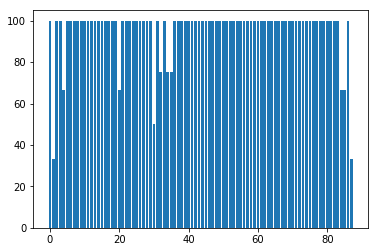

287
0

Test set: Average loss: 0.0213, Accuracy: 287/300 (96%)

Train Epoch: 101 [0/5702 (0%)]	Loss: 0.023812
Train Epoch: 102 [0/5702 (0%)]	Loss: 0.022813
Train Epoch: 103 [0/5702 (0%)]	Loss: 0.020827
Train Epoch: 104 [0/5702 (0%)]	Loss: 0.021364
Train Epoch: 105 [0/5702 (0%)]	Loss: 0.019991


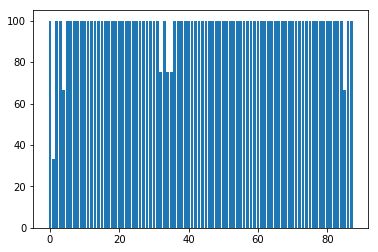

293
0

Test set: Average loss: 0.0165, Accuracy: 293/300 (98%)

Train Epoch: 106 [0/5702 (0%)]	Loss: 0.016921
Train Epoch: 107 [0/5702 (0%)]	Loss: 0.018260
Train Epoch: 108 [0/5702 (0%)]	Loss: 0.015395
Train Epoch: 109 [0/5702 (0%)]	Loss: 0.017216
Train Epoch: 110 [0/5702 (0%)]	Loss: 0.013884


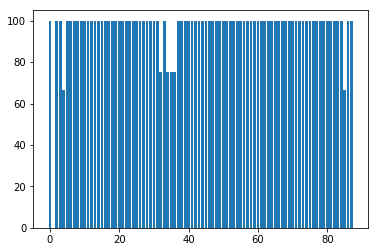

291
0

Test set: Average loss: 0.0130, Accuracy: 291/300 (97%)

Train Epoch: 111 [0/5702 (0%)]	Loss: 0.016677
Train Epoch: 112 [0/5702 (0%)]	Loss: 0.014304
Train Epoch: 113 [0/5702 (0%)]	Loss: 0.014518
Train Epoch: 114 [0/5702 (0%)]	Loss: 0.012900
Train Epoch: 115 [0/5702 (0%)]	Loss: 0.013633


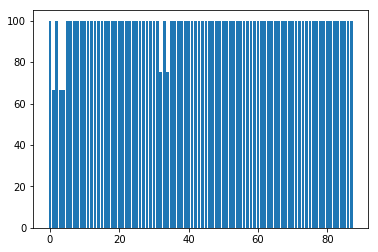

295
0

Test set: Average loss: 0.0103, Accuracy: 295/300 (98%)

Train Epoch: 116 [0/5702 (0%)]	Loss: 0.013706
Train Epoch: 117 [0/5702 (0%)]	Loss: 0.010635
Train Epoch: 118 [0/5702 (0%)]	Loss: 0.013122
Train Epoch: 119 [0/5702 (0%)]	Loss: 0.013715
Train Epoch: 120 [0/5702 (0%)]	Loss: 0.012239


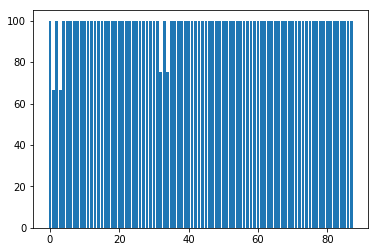

296
0

Test set: Average loss: 0.0089, Accuracy: 296/300 (99%)

Train Epoch: 121 [0/5702 (0%)]	Loss: 0.010628
Train Epoch: 122 [0/5702 (0%)]	Loss: 0.009404
Train Epoch: 123 [0/5702 (0%)]	Loss: 0.009288
Train Epoch: 124 [0/5702 (0%)]	Loss: 0.011455
Train Epoch: 125 [0/5702 (0%)]	Loss: 0.009488


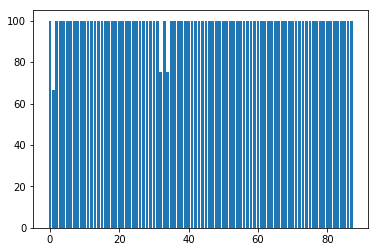

297
0

Test set: Average loss: 0.0068, Accuracy: 297/300 (99%)

Train Epoch: 126 [0/5702 (0%)]	Loss: 0.008021
Train Epoch: 127 [0/5702 (0%)]	Loss: 0.008868
Train Epoch: 128 [0/5702 (0%)]	Loss: 0.007709
Train Epoch: 129 [0/5702 (0%)]	Loss: 0.007382
Train Epoch: 130 [0/5702 (0%)]	Loss: 0.008951


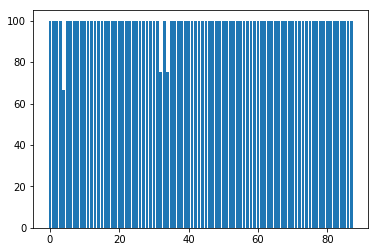

297
0

Test set: Average loss: 0.0060, Accuracy: 297/300 (99%)

Train Epoch: 131 [0/5702 (0%)]	Loss: 0.007345
Train Epoch: 132 [0/5702 (0%)]	Loss: 0.006819
Train Epoch: 133 [0/5702 (0%)]	Loss: 0.006539
Train Epoch: 134 [0/5702 (0%)]	Loss: 0.007178
Train Epoch: 135 [0/5702 (0%)]	Loss: 0.005082


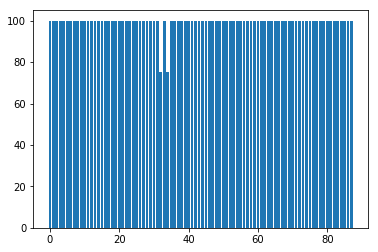

298
0

Test set: Average loss: 0.0049, Accuracy: 298/300 (99%)

Train Epoch: 136 [0/5702 (0%)]	Loss: 0.006039
Train Epoch: 137 [0/5702 (0%)]	Loss: 0.005337
Train Epoch: 138 [0/5702 (0%)]	Loss: 0.005494
Train Epoch: 139 [0/5702 (0%)]	Loss: 0.006900
Train Epoch: 140 [0/5702 (0%)]	Loss: 0.006036


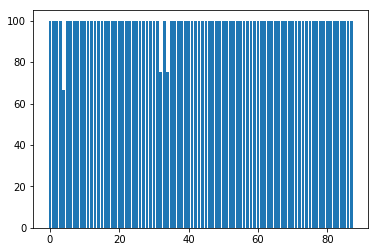

297
0

Test set: Average loss: 0.0043, Accuracy: 297/300 (99%)

Train Epoch: 141 [0/5702 (0%)]	Loss: 0.006185
Train Epoch: 142 [0/5702 (0%)]	Loss: 0.005578
Train Epoch: 143 [0/5702 (0%)]	Loss: 0.006111
Train Epoch: 144 [0/5702 (0%)]	Loss: 0.005847
Train Epoch: 145 [0/5702 (0%)]	Loss: 0.005111


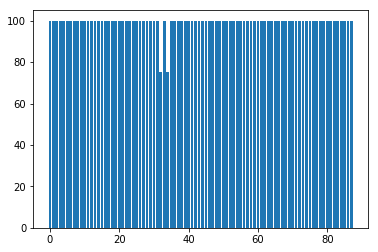

298
0

Test set: Average loss: 0.0037, Accuracy: 298/300 (99%)

Train Epoch: 146 [0/5702 (0%)]	Loss: 0.004423
Train Epoch: 147 [0/5702 (0%)]	Loss: 0.004354
Train Epoch: 148 [0/5702 (0%)]	Loss: 0.005304
Train Epoch: 149 [0/5702 (0%)]	Loss: 0.004483
Train Epoch: 150 [0/5702 (0%)]	Loss: 0.004734


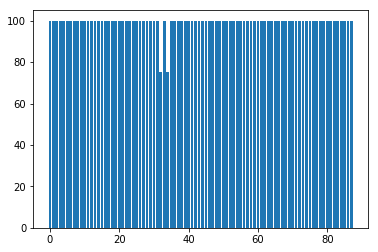

298
0

Test set: Average loss: 0.0036, Accuracy: 298/300 (99%)

Train Epoch: 151 [0/5702 (0%)]	Loss: 0.004325
Train Epoch: 152 [0/5702 (0%)]	Loss: 0.003915
Train Epoch: 153 [0/5702 (0%)]	Loss: 0.004708
Train Epoch: 154 [0/5702 (0%)]	Loss: 0.003986
Train Epoch: 155 [0/5702 (0%)]	Loss: 0.004485


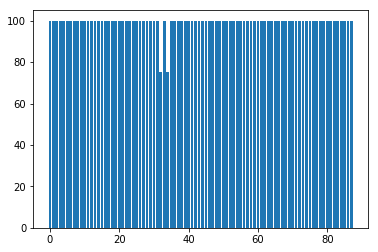

298
0

Test set: Average loss: 0.0030, Accuracy: 298/300 (99%)

Train Epoch: 156 [0/5702 (0%)]	Loss: 0.004389
Train Epoch: 157 [0/5702 (0%)]	Loss: 0.004831
Train Epoch: 158 [0/5702 (0%)]	Loss: 0.004424
Train Epoch: 159 [0/5702 (0%)]	Loss: 0.004046
Train Epoch: 160 [0/5702 (0%)]	Loss: 0.003879


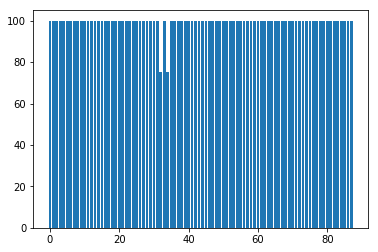

298
0

Test set: Average loss: 0.0026, Accuracy: 298/300 (99%)

Train Epoch: 161 [0/5702 (0%)]	Loss: 0.002841
Train Epoch: 162 [0/5702 (0%)]	Loss: 0.003374
Train Epoch: 163 [0/5702 (0%)]	Loss: 0.003017
Train Epoch: 164 [0/5702 (0%)]	Loss: 0.003521
Train Epoch: 165 [0/5702 (0%)]	Loss: 0.005630


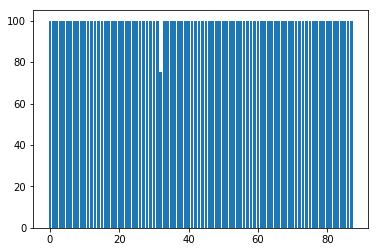

299
0

Test set: Average loss: 0.0024, Accuracy: 299/300 (100%)

Train Epoch: 166 [0/5702 (0%)]	Loss: 0.003366
Train Epoch: 167 [0/5702 (0%)]	Loss: 0.003808
Train Epoch: 168 [0/5702 (0%)]	Loss: 0.002695
Train Epoch: 169 [0/5702 (0%)]	Loss: 0.003071
Train Epoch: 170 [0/5702 (0%)]	Loss: 0.003638


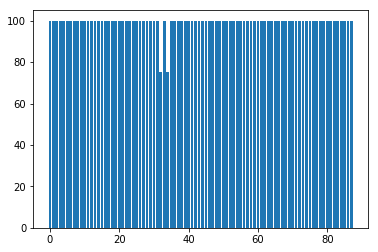

298
0

Test set: Average loss: 0.0024, Accuracy: 298/300 (99%)

Train Epoch: 171 [0/5702 (0%)]	Loss: 0.003404
Train Epoch: 172 [0/5702 (0%)]	Loss: 0.003102
Train Epoch: 173 [0/5702 (0%)]	Loss: 0.002543
Train Epoch: 174 [0/5702 (0%)]	Loss: 0.002570
Train Epoch: 175 [0/5702 (0%)]	Loss: 0.002533


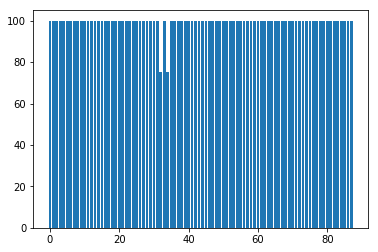

298
0

Test set: Average loss: 0.0020, Accuracy: 298/300 (99%)

Train Epoch: 176 [0/5702 (0%)]	Loss: 0.002631
Train Epoch: 177 [0/5702 (0%)]	Loss: 0.004071
Train Epoch: 178 [0/5702 (0%)]	Loss: 0.003016
Train Epoch: 179 [0/5702 (0%)]	Loss: 0.002917
Train Epoch: 180 [0/5702 (0%)]	Loss: 0.004646


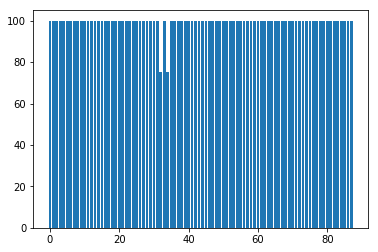

298
0

Test set: Average loss: 0.0021, Accuracy: 298/300 (99%)

Train Epoch: 181 [0/5702 (0%)]	Loss: 0.004558
Train Epoch: 182 [0/5702 (0%)]	Loss: 0.003402
Train Epoch: 183 [0/5702 (0%)]	Loss: 0.002456
Train Epoch: 184 [0/5702 (0%)]	Loss: 0.002348
Train Epoch: 185 [0/5702 (0%)]	Loss: 0.002869


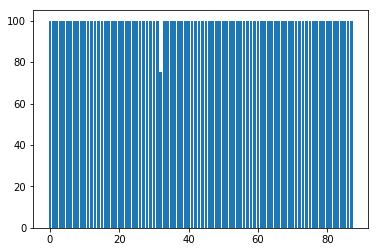

299
0

Test set: Average loss: 0.0017, Accuracy: 299/300 (100%)

Train Epoch: 186 [0/5702 (0%)]	Loss: 0.001749
Train Epoch: 187 [0/5702 (0%)]	Loss: 0.002821
Train Epoch: 188 [0/5702 (0%)]	Loss: 0.002568
Train Epoch: 189 [0/5702 (0%)]	Loss: 0.003953
Train Epoch: 190 [0/5702 (0%)]	Loss: 0.002411


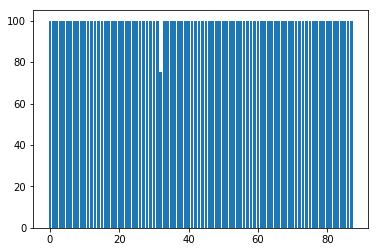

299
0

Test set: Average loss: 0.0015, Accuracy: 299/300 (100%)

Train Epoch: 191 [0/5702 (0%)]	Loss: 0.002562
Train Epoch: 192 [0/5702 (0%)]	Loss: 0.003693
Train Epoch: 193 [0/5702 (0%)]	Loss: 0.002602
Train Epoch: 194 [0/5702 (0%)]	Loss: 0.002201
Train Epoch: 195 [0/5702 (0%)]	Loss: 0.002356


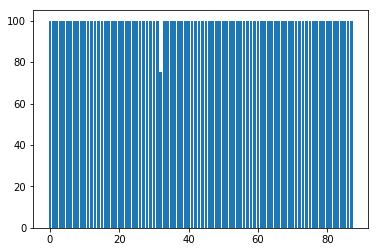

299
0

Test set: Average loss: 0.0014, Accuracy: 299/300 (100%)

Train Epoch: 196 [0/5702 (0%)]	Loss: 0.002537
Train Epoch: 197 [0/5702 (0%)]	Loss: 0.001911
Train Epoch: 198 [0/5702 (0%)]	Loss: 0.001756
Train Epoch: 199 [0/5702 (0%)]	Loss: 0.001750
Train Epoch: 200 [0/5702 (0%)]	Loss: 0.001905


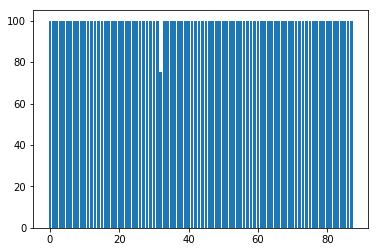

299
0

Test set: Average loss: 0.0014, Accuracy: 299/300 (100%)

Train Epoch: 201 [0/5702 (0%)]	Loss: 0.003896
Train Epoch: 202 [0/5702 (0%)]	Loss: 0.002478
Train Epoch: 203 [0/5702 (0%)]	Loss: 0.002034
Train Epoch: 204 [0/5702 (0%)]	Loss: 0.001681
Train Epoch: 205 [0/5702 (0%)]	Loss: 0.001777


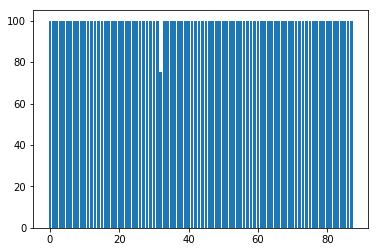

299
0

Test set: Average loss: 0.0013, Accuracy: 299/300 (100%)

Train Epoch: 206 [0/5702 (0%)]	Loss: 0.003363
Train Epoch: 207 [0/5702 (0%)]	Loss: 0.002939
Train Epoch: 208 [0/5702 (0%)]	Loss: 0.001385
Train Epoch: 209 [0/5702 (0%)]	Loss: 0.001613
Train Epoch: 210 [0/5702 (0%)]	Loss: 0.002090


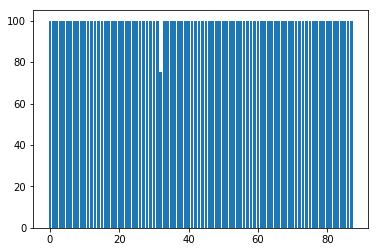

299
0

Test set: Average loss: 0.0012, Accuracy: 299/300 (100%)

Train Epoch: 211 [0/5702 (0%)]	Loss: 0.001561
Train Epoch: 212 [0/5702 (0%)]	Loss: 0.001684
Train Epoch: 213 [0/5702 (0%)]	Loss: 0.002818
Train Epoch: 214 [0/5702 (0%)]	Loss: 0.002164
Train Epoch: 215 [0/5702 (0%)]	Loss: 0.002135


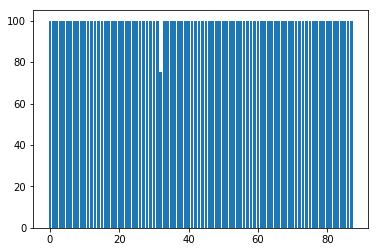

299
0

Test set: Average loss: 0.0016, Accuracy: 299/300 (100%)

Train Epoch: 216 [0/5702 (0%)]	Loss: 0.003022
Train Epoch: 217 [0/5702 (0%)]	Loss: 0.002830
Train Epoch: 218 [0/5702 (0%)]	Loss: 0.001460
Train Epoch: 219 [0/5702 (0%)]	Loss: 0.002284
Train Epoch: 220 [0/5702 (0%)]	Loss: 0.001543


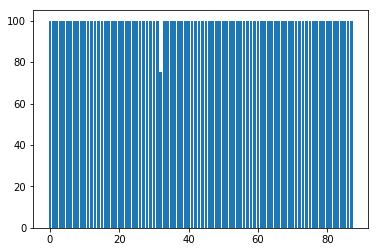

299
0

Test set: Average loss: 0.0011, Accuracy: 299/300 (100%)

Train Epoch: 221 [0/5702 (0%)]	Loss: 0.002065
Train Epoch: 222 [0/5702 (0%)]	Loss: 0.002212
Train Epoch: 223 [0/5702 (0%)]	Loss: 0.001375
Train Epoch: 224 [0/5702 (0%)]	Loss: 0.001485
Train Epoch: 225 [0/5702 (0%)]	Loss: 0.001314


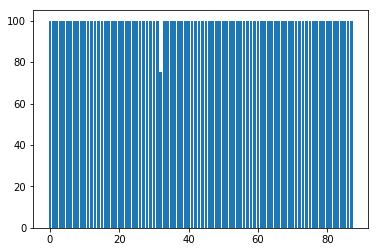

299
0

Test set: Average loss: 0.0023, Accuracy: 299/300 (100%)

Train Epoch: 226 [0/5702 (0%)]	Loss: 0.004184
Train Epoch: 227 [0/5702 (0%)]	Loss: 0.004245
Train Epoch: 228 [0/5702 (0%)]	Loss: 0.001768
Train Epoch: 229 [0/5702 (0%)]	Loss: 0.001893
Train Epoch: 230 [0/5702 (0%)]	Loss: 0.001949


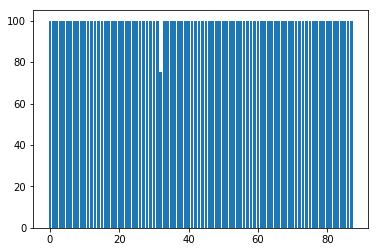

299
0

Test set: Average loss: 0.0009, Accuracy: 299/300 (100%)

Train Epoch: 231 [0/5702 (0%)]	Loss: 0.001363
Train Epoch: 232 [0/5702 (0%)]	Loss: 0.003489
Train Epoch: 233 [0/5702 (0%)]	Loss: 0.001188
Train Epoch: 234 [0/5702 (0%)]	Loss: 0.001646
Train Epoch: 235 [0/5702 (0%)]	Loss: 0.002140


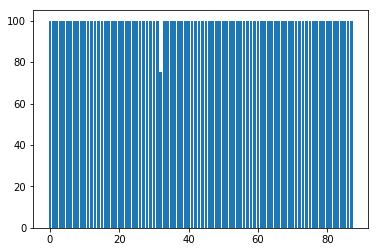

299
0

Test set: Average loss: 0.0009, Accuracy: 299/300 (100%)

Train Epoch: 236 [0/5702 (0%)]	Loss: 0.002380
Train Epoch: 237 [0/5702 (0%)]	Loss: 0.001721
Train Epoch: 238 [0/5702 (0%)]	Loss: 0.001167
Train Epoch: 239 [0/5702 (0%)]	Loss: 0.001534
Train Epoch: 240 [0/5702 (0%)]	Loss: 0.001315


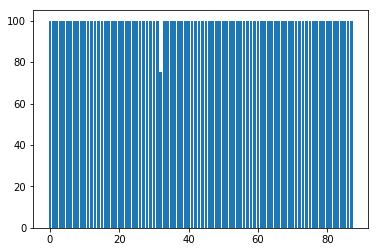

299
0

Test set: Average loss: 0.0010, Accuracy: 299/300 (100%)

Train Epoch: 241 [0/5702 (0%)]	Loss: 0.002149
Train Epoch: 242 [0/5702 (0%)]	Loss: 0.001497
Train Epoch: 243 [0/5702 (0%)]	Loss: 0.001704
Train Epoch: 244 [0/5702 (0%)]	Loss: 0.001463
Train Epoch: 245 [0/5702 (0%)]	Loss: 0.001995


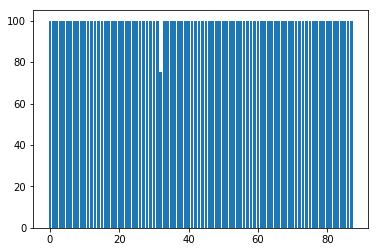

299
0

Test set: Average loss: 0.0012, Accuracy: 299/300 (100%)

Train Epoch: 246 [0/5702 (0%)]	Loss: 0.001402
Train Epoch: 247 [0/5702 (0%)]	Loss: 0.001492
Train Epoch: 248 [0/5702 (0%)]	Loss: 0.001135
Train Epoch: 249 [0/5702 (0%)]	Loss: 0.000958
Train Epoch: 250 [0/5702 (0%)]	Loss: 0.000988


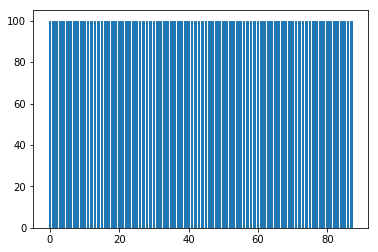

300
0

Test set: Average loss: 0.0008, Accuracy: 300/300 (100%)

Train Epoch: 251 [0/5702 (0%)]	Loss: 0.001718
Train Epoch: 252 [0/5702 (0%)]	Loss: 0.001062
Train Epoch: 253 [0/5702 (0%)]	Loss: 0.003314
Train Epoch: 254 [0/5702 (0%)]	Loss: 0.001612
Train Epoch: 255 [0/5702 (0%)]	Loss: 0.001546


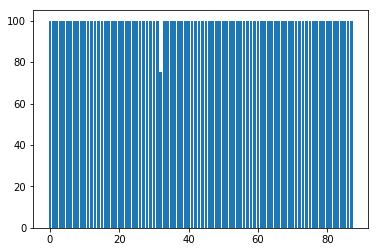

299
0

Test set: Average loss: 0.0007, Accuracy: 299/300 (100%)

Train Epoch: 256 [0/5702 (0%)]	Loss: 0.000777
Train Epoch: 257 [0/5702 (0%)]	Loss: 0.001082
Train Epoch: 258 [0/5702 (0%)]	Loss: 0.001741
Train Epoch: 259 [0/5702 (0%)]	Loss: 0.000750
Train Epoch: 260 [0/5702 (0%)]	Loss: 0.001041


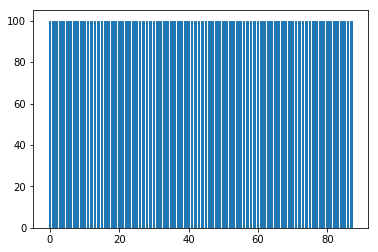

300
0

Test set: Average loss: 0.0007, Accuracy: 300/300 (100%)

Train Epoch: 261 [0/5702 (0%)]	Loss: 0.001380
Train Epoch: 262 [0/5702 (0%)]	Loss: 0.000790
Train Epoch: 263 [0/5702 (0%)]	Loss: 0.001326
Train Epoch: 264 [0/5702 (0%)]	Loss: 0.001386
Train Epoch: 265 [0/5702 (0%)]	Loss: 0.001001


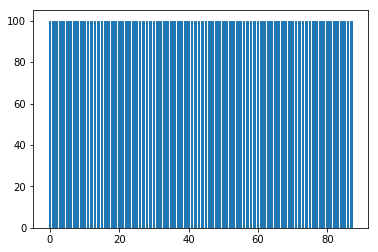

300
0

Test set: Average loss: 0.0009, Accuracy: 300/300 (100%)

Train Epoch: 266 [0/5702 (0%)]	Loss: 0.001348
Train Epoch: 267 [0/5702 (0%)]	Loss: 0.001106
Train Epoch: 268 [0/5702 (0%)]	Loss: 0.001150
Train Epoch: 269 [0/5702 (0%)]	Loss: 0.001467
Train Epoch: 270 [0/5702 (0%)]	Loss: 0.002921


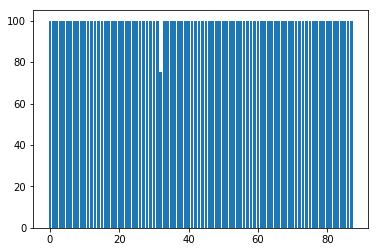

299
0

Test set: Average loss: 0.0007, Accuracy: 299/300 (100%)

Train Epoch: 271 [0/5702 (0%)]	Loss: 0.001041
Train Epoch: 272 [0/5702 (0%)]	Loss: 0.001176
Train Epoch: 273 [0/5702 (0%)]	Loss: 0.003051
Train Epoch: 274 [0/5702 (0%)]	Loss: 0.001661
Train Epoch: 275 [0/5702 (0%)]	Loss: 0.001357


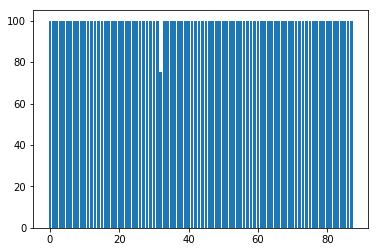

299
0

Test set: Average loss: 0.0007, Accuracy: 299/300 (100%)

Train Epoch: 276 [0/5702 (0%)]	Loss: 0.001138
Train Epoch: 277 [0/5702 (0%)]	Loss: 0.001571
Train Epoch: 278 [0/5702 (0%)]	Loss: 0.001719
Train Epoch: 279 [0/5702 (0%)]	Loss: 0.001080
Train Epoch: 280 [0/5702 (0%)]	Loss: 0.003756


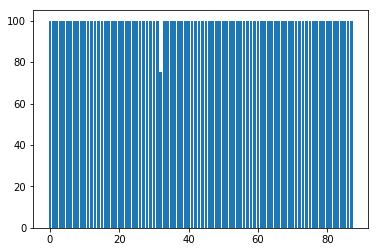

299
0

Test set: Average loss: 0.0006, Accuracy: 299/300 (100%)

Train Epoch: 281 [0/5702 (0%)]	Loss: 0.000739
Train Epoch: 282 [0/5702 (0%)]	Loss: 0.001110
Train Epoch: 283 [0/5702 (0%)]	Loss: 0.002696
Train Epoch: 284 [0/5702 (0%)]	Loss: 0.001133
Train Epoch: 285 [0/5702 (0%)]	Loss: 0.003097


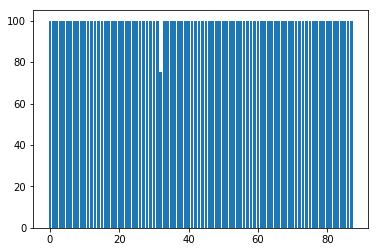

299
0

Test set: Average loss: 0.0006, Accuracy: 299/300 (100%)

Train Epoch: 286 [0/5702 (0%)]	Loss: 0.001108
Train Epoch: 287 [0/5702 (0%)]	Loss: 0.000989
Train Epoch: 288 [0/5702 (0%)]	Loss: 0.000858
Train Epoch: 289 [0/5702 (0%)]	Loss: 0.000928
Train Epoch: 290 [0/5702 (0%)]	Loss: 0.000789


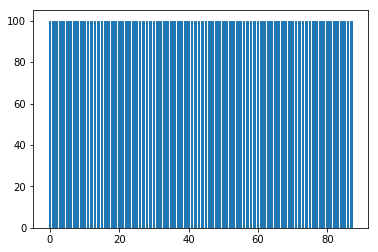

300
0

Test set: Average loss: 0.0006, Accuracy: 300/300 (100%)

Train Epoch: 291 [0/5702 (0%)]	Loss: 0.001066
Train Epoch: 292 [0/5702 (0%)]	Loss: 0.001397
Train Epoch: 293 [0/5702 (0%)]	Loss: 0.000792
Train Epoch: 294 [0/5702 (0%)]	Loss: 0.001130
Train Epoch: 295 [0/5702 (0%)]	Loss: 0.000645


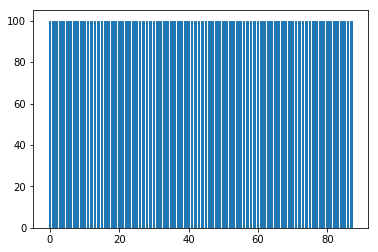

300
0

Test set: Average loss: 0.0005, Accuracy: 300/300 (100%)

Train Epoch: 296 [0/5702 (0%)]	Loss: 0.001229
Train Epoch: 297 [0/5702 (0%)]	Loss: 0.000684
Train Epoch: 298 [0/5702 (0%)]	Loss: 0.001280
Train Epoch: 299 [0/5702 (0%)]	Loss: 0.001164
Train Epoch: 300 [0/5702 (0%)]	Loss: 0.000895


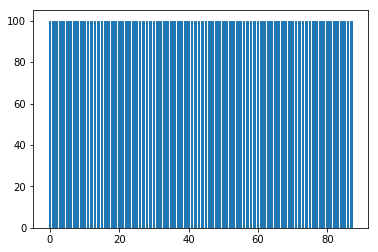

300
0

Test set: Average loss: 0.0014, Accuracy: 300/300 (100%)

Train Epoch: 301 [0/5702 (0%)]	Loss: 0.002557
Train Epoch: 302 [0/5702 (0%)]	Loss: 0.001385
Train Epoch: 303 [0/5702 (0%)]	Loss: 0.001332
Train Epoch: 304 [0/5702 (0%)]	Loss: 0.000772
Train Epoch: 305 [0/5702 (0%)]	Loss: 0.000692


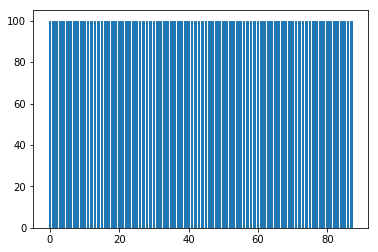

300
0

Test set: Average loss: 0.0005, Accuracy: 300/300 (100%)

Train Epoch: 306 [0/5702 (0%)]	Loss: 0.000508
Train Epoch: 307 [0/5702 (0%)]	Loss: 0.001262
Train Epoch: 308 [0/5702 (0%)]	Loss: 0.000621
Train Epoch: 309 [0/5702 (0%)]	Loss: 0.001212
Train Epoch: 310 [0/5702 (0%)]	Loss: 0.001317


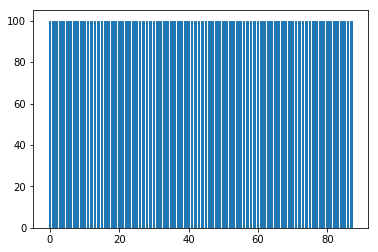

300
0

Test set: Average loss: 0.0005, Accuracy: 300/300 (100%)

Train Epoch: 311 [0/5702 (0%)]	Loss: 0.000821
Train Epoch: 312 [0/5702 (0%)]	Loss: 0.000841
Train Epoch: 313 [0/5702 (0%)]	Loss: 0.001138
Train Epoch: 314 [0/5702 (0%)]	Loss: 0.001249
Train Epoch: 315 [0/5702 (0%)]	Loss: 0.000638


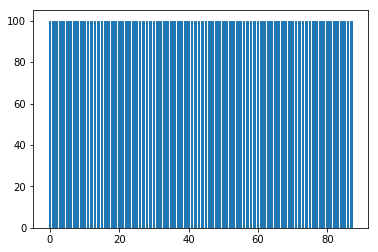

300
0

Test set: Average loss: 0.0005, Accuracy: 300/300 (100%)

Train Epoch: 316 [0/5702 (0%)]	Loss: 0.000769
Train Epoch: 317 [0/5702 (0%)]	Loss: 0.000723
Train Epoch: 318 [0/5702 (0%)]	Loss: 0.000758
Train Epoch: 319 [0/5702 (0%)]	Loss: 0.000609
Train Epoch: 320 [0/5702 (0%)]	Loss: 0.000563


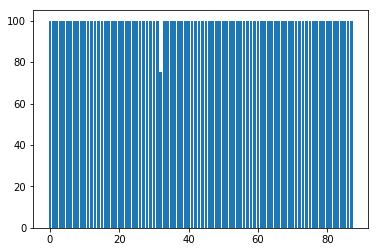

299
0

Test set: Average loss: 0.0005, Accuracy: 299/300 (100%)

Train Epoch: 321 [0/5702 (0%)]	Loss: 0.001045
Train Epoch: 322 [0/5702 (0%)]	Loss: 0.001151
Train Epoch: 323 [0/5702 (0%)]	Loss: 0.000614
Train Epoch: 324 [0/5702 (0%)]	Loss: 0.000642
Train Epoch: 325 [0/5702 (0%)]	Loss: 0.000881


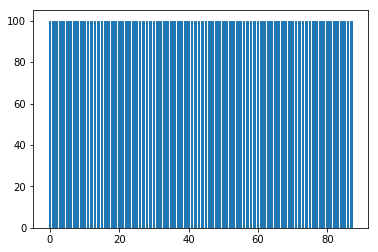

300
0

Test set: Average loss: 0.0005, Accuracy: 300/300 (100%)

Train Epoch: 326 [0/5702 (0%)]	Loss: 0.000847
Train Epoch: 327 [0/5702 (0%)]	Loss: 0.000618
Train Epoch: 328 [0/5702 (0%)]	Loss: 0.001198
Train Epoch: 329 [0/5702 (0%)]	Loss: 0.000913
Train Epoch: 330 [0/5702 (0%)]	Loss: 0.000524


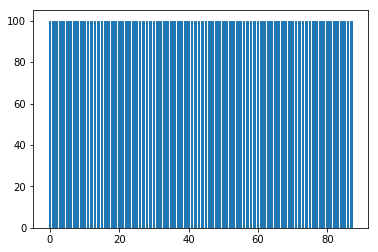

300
0

Test set: Average loss: 0.0004, Accuracy: 300/300 (100%)

Train Epoch: 331 [0/5702 (0%)]	Loss: 0.001445
Train Epoch: 332 [0/5702 (0%)]	Loss: 0.000813
Train Epoch: 333 [0/5702 (0%)]	Loss: 0.000594
Train Epoch: 334 [0/5702 (0%)]	Loss: 0.001303
Train Epoch: 335 [0/5702 (0%)]	Loss: 0.000555


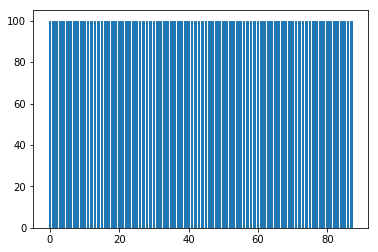

300
0

Test set: Average loss: 0.0004, Accuracy: 300/300 (100%)

Train Epoch: 336 [0/5702 (0%)]	Loss: 0.000807
Train Epoch: 337 [0/5702 (0%)]	Loss: 0.000892
Train Epoch: 338 [0/5702 (0%)]	Loss: 0.001423
Train Epoch: 339 [0/5702 (0%)]	Loss: 0.000589
Train Epoch: 340 [0/5702 (0%)]	Loss: 0.004026


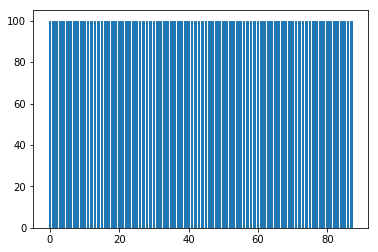

300
0

Test set: Average loss: 0.0005, Accuracy: 300/300 (100%)

Train Epoch: 341 [0/5702 (0%)]	Loss: 0.001096
Train Epoch: 342 [0/5702 (0%)]	Loss: 0.000460
Train Epoch: 343 [0/5702 (0%)]	Loss: 0.000752
Train Epoch: 344 [0/5702 (0%)]	Loss: 0.000940
Train Epoch: 345 [0/5702 (0%)]	Loss: 0.000717


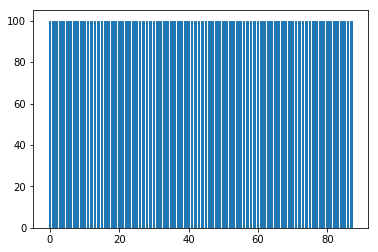

300
0

Test set: Average loss: 0.0004, Accuracy: 300/300 (100%)

Train Epoch: 346 [0/5702 (0%)]	Loss: 0.000753
Train Epoch: 347 [0/5702 (0%)]	Loss: 0.000943
Train Epoch: 348 [0/5702 (0%)]	Loss: 0.000507
Train Epoch: 349 [0/5702 (0%)]	Loss: 0.000719
Train Epoch: 350 [0/5702 (0%)]	Loss: 0.000840


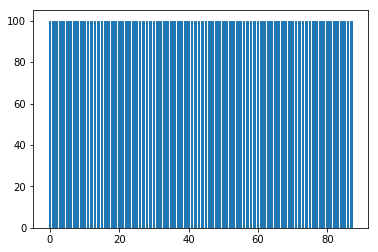

300
0

Test set: Average loss: 0.0004, Accuracy: 300/300 (100%)

Train Epoch: 351 [0/5702 (0%)]	Loss: 0.000654
Train Epoch: 352 [0/5702 (0%)]	Loss: 0.000588
Train Epoch: 353 [0/5702 (0%)]	Loss: 0.002083
Train Epoch: 354 [0/5702 (0%)]	Loss: 0.001606
Train Epoch: 355 [0/5702 (0%)]	Loss: 0.000633


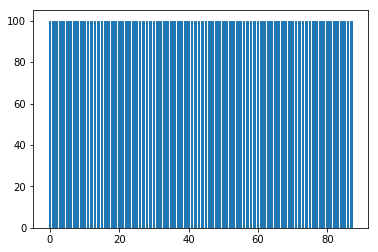

300
0

Test set: Average loss: 0.0004, Accuracy: 300/300 (100%)

Train Epoch: 356 [0/5702 (0%)]	Loss: 0.000643
Train Epoch: 357 [0/5702 (0%)]	Loss: 0.000324
Train Epoch: 358 [0/5702 (0%)]	Loss: 0.000527
Train Epoch: 359 [0/5702 (0%)]	Loss: 0.000737
Train Epoch: 360 [0/5702 (0%)]	Loss: 0.000775


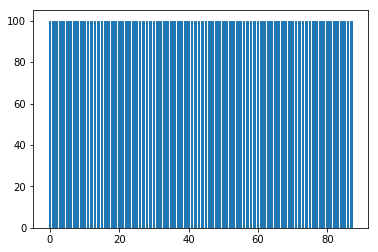

300
0

Test set: Average loss: 0.0004, Accuracy: 300/300 (100%)

Train Epoch: 361 [0/5702 (0%)]	Loss: 0.000708
Train Epoch: 362 [0/5702 (0%)]	Loss: 0.000609
Train Epoch: 363 [0/5702 (0%)]	Loss: 0.000504
Train Epoch: 364 [0/5702 (0%)]	Loss: 0.000767
Train Epoch: 365 [0/5702 (0%)]	Loss: 0.000568


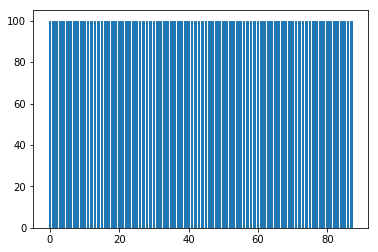

300
0

Test set: Average loss: 0.0004, Accuracy: 300/300 (100%)

Train Epoch: 366 [0/5702 (0%)]	Loss: 0.000672
Train Epoch: 367 [0/5702 (0%)]	Loss: 0.000586
Train Epoch: 368 [0/5702 (0%)]	Loss: 0.000391
Train Epoch: 369 [0/5702 (0%)]	Loss: 0.001031
Train Epoch: 370 [0/5702 (0%)]	Loss: 0.000473


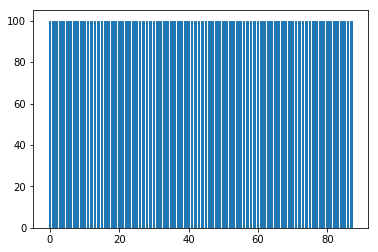

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 371 [0/5702 (0%)]	Loss: 0.001181
Train Epoch: 372 [0/5702 (0%)]	Loss: 0.000592
Train Epoch: 373 [0/5702 (0%)]	Loss: 0.000556
Train Epoch: 374 [0/5702 (0%)]	Loss: 0.001239
Train Epoch: 375 [0/5702 (0%)]	Loss: 0.000735


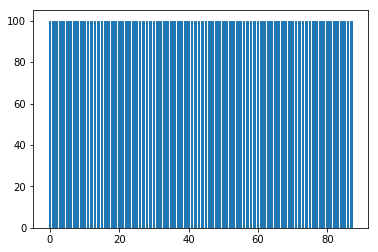

300
0

Test set: Average loss: 0.0004, Accuracy: 300/300 (100%)

Train Epoch: 376 [0/5702 (0%)]	Loss: 0.000663
Train Epoch: 377 [0/5702 (0%)]	Loss: 0.000564
Train Epoch: 378 [0/5702 (0%)]	Loss: 0.000965
Train Epoch: 379 [0/5702 (0%)]	Loss: 0.000455
Train Epoch: 380 [0/5702 (0%)]	Loss: 0.003686


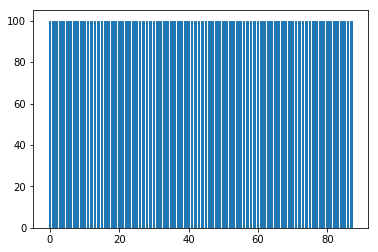

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 381 [0/5702 (0%)]	Loss: 0.000436
Train Epoch: 382 [0/5702 (0%)]	Loss: 0.000479
Train Epoch: 383 [0/5702 (0%)]	Loss: 0.000370
Train Epoch: 384 [0/5702 (0%)]	Loss: 0.000443
Train Epoch: 385 [0/5702 (0%)]	Loss: 0.000635


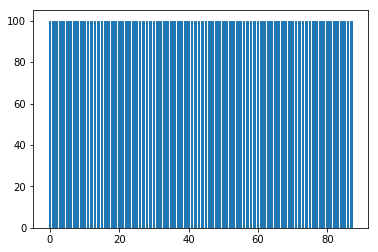

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 386 [0/5702 (0%)]	Loss: 0.000771
Train Epoch: 387 [0/5702 (0%)]	Loss: 0.000441
Train Epoch: 388 [0/5702 (0%)]	Loss: 0.000848
Train Epoch: 389 [0/5702 (0%)]	Loss: 0.000717
Train Epoch: 390 [0/5702 (0%)]	Loss: 0.000541


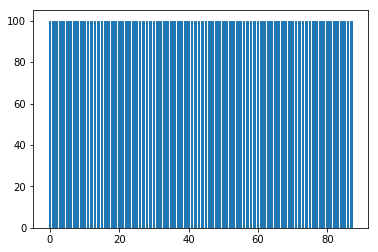

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 391 [0/5702 (0%)]	Loss: 0.000545
Train Epoch: 392 [0/5702 (0%)]	Loss: 0.000640
Train Epoch: 393 [0/5702 (0%)]	Loss: 0.000567
Train Epoch: 394 [0/5702 (0%)]	Loss: 0.001403
Train Epoch: 395 [0/5702 (0%)]	Loss: 0.000593


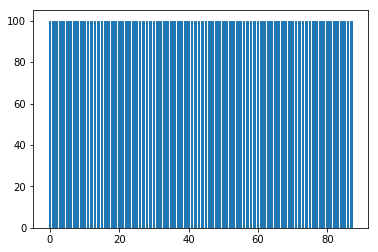

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 396 [0/5702 (0%)]	Loss: 0.000430
Train Epoch: 397 [0/5702 (0%)]	Loss: 0.000439
Train Epoch: 398 [0/5702 (0%)]	Loss: 0.000212
Train Epoch: 399 [0/5702 (0%)]	Loss: 0.000414
Train Epoch: 400 [0/5702 (0%)]	Loss: 0.000560


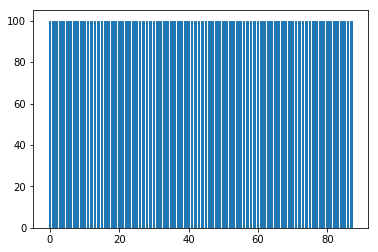

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 401 [0/5702 (0%)]	Loss: 0.000359
Train Epoch: 402 [0/5702 (0%)]	Loss: 0.000723
Train Epoch: 403 [0/5702 (0%)]	Loss: 0.000445
Train Epoch: 404 [0/5702 (0%)]	Loss: 0.001870
Train Epoch: 405 [0/5702 (0%)]	Loss: 0.000296


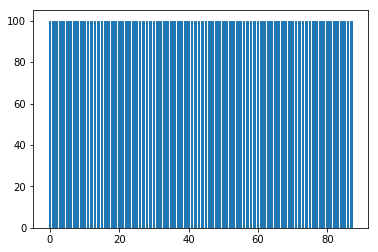

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 406 [0/5702 (0%)]	Loss: 0.001123
Train Epoch: 407 [0/5702 (0%)]	Loss: 0.001125
Train Epoch: 408 [0/5702 (0%)]	Loss: 0.000644
Train Epoch: 409 [0/5702 (0%)]	Loss: 0.000335
Train Epoch: 410 [0/5702 (0%)]	Loss: 0.000586


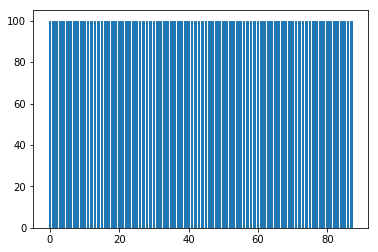

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 411 [0/5702 (0%)]	Loss: 0.000754
Train Epoch: 412 [0/5702 (0%)]	Loss: 0.000424
Train Epoch: 413 [0/5702 (0%)]	Loss: 0.000267
Train Epoch: 414 [0/5702 (0%)]	Loss: 0.000462
Train Epoch: 415 [0/5702 (0%)]	Loss: 0.000536


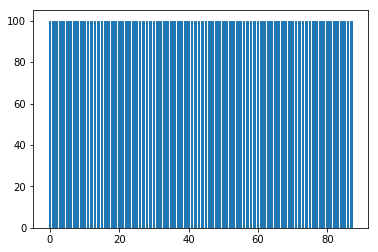

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 416 [0/5702 (0%)]	Loss: 0.000618
Train Epoch: 417 [0/5702 (0%)]	Loss: 0.000439
Train Epoch: 418 [0/5702 (0%)]	Loss: 0.000933
Train Epoch: 419 [0/5702 (0%)]	Loss: 0.000579
Train Epoch: 420 [0/5702 (0%)]	Loss: 0.000330


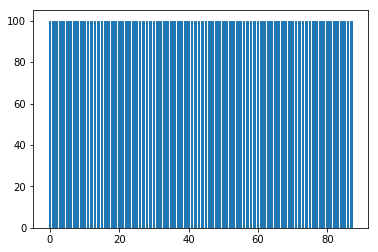

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 421 [0/5702 (0%)]	Loss: 0.000588
Train Epoch: 422 [0/5702 (0%)]	Loss: 0.000317
Train Epoch: 423 [0/5702 (0%)]	Loss: 0.000794
Train Epoch: 424 [0/5702 (0%)]	Loss: 0.000455
Train Epoch: 425 [0/5702 (0%)]	Loss: 0.000549


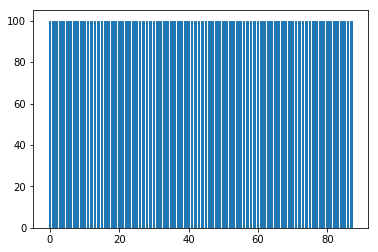

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 426 [0/5702 (0%)]	Loss: 0.000520
Train Epoch: 427 [0/5702 (0%)]	Loss: 0.000478
Train Epoch: 428 [0/5702 (0%)]	Loss: 0.001638
Train Epoch: 429 [0/5702 (0%)]	Loss: 0.000471
Train Epoch: 430 [0/5702 (0%)]	Loss: 0.000401


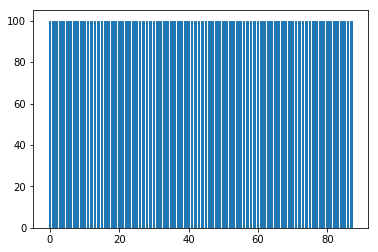

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 431 [0/5702 (0%)]	Loss: 0.000803
Train Epoch: 432 [0/5702 (0%)]	Loss: 0.000494
Train Epoch: 433 [0/5702 (0%)]	Loss: 0.001711
Train Epoch: 434 [0/5702 (0%)]	Loss: 0.000837
Train Epoch: 435 [0/5702 (0%)]	Loss: 0.000755


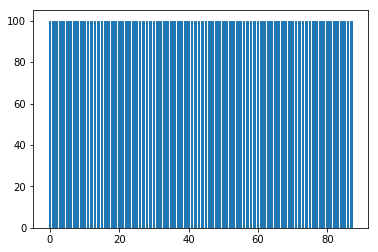

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 436 [0/5702 (0%)]	Loss: 0.000461
Train Epoch: 437 [0/5702 (0%)]	Loss: 0.000332
Train Epoch: 438 [0/5702 (0%)]	Loss: 0.000503
Train Epoch: 439 [0/5702 (0%)]	Loss: 0.000684
Train Epoch: 440 [0/5702 (0%)]	Loss: 0.001026


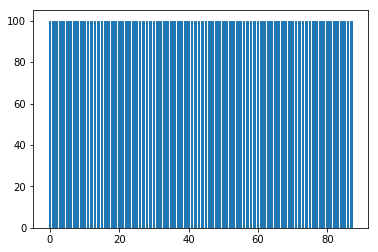

300
0

Test set: Average loss: 0.0003, Accuracy: 300/300 (100%)

Train Epoch: 441 [0/5702 (0%)]	Loss: 0.000778
Train Epoch: 442 [0/5702 (0%)]	Loss: 0.000758
Train Epoch: 443 [0/5702 (0%)]	Loss: 0.000512
Train Epoch: 444 [0/5702 (0%)]	Loss: 0.000350
Train Epoch: 445 [0/5702 (0%)]	Loss: 0.000366


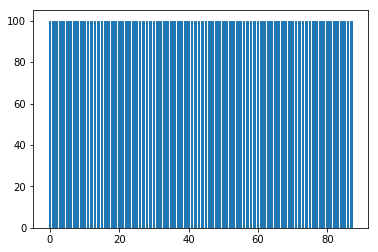

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 446 [0/5702 (0%)]	Loss: 0.000560
Train Epoch: 447 [0/5702 (0%)]	Loss: 0.000442
Train Epoch: 448 [0/5702 (0%)]	Loss: 0.000466
Train Epoch: 449 [0/5702 (0%)]	Loss: 0.000342
Train Epoch: 450 [0/5702 (0%)]	Loss: 0.000521


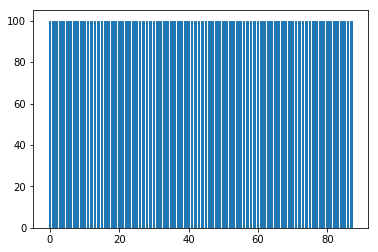

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 451 [0/5702 (0%)]	Loss: 0.000486
Train Epoch: 452 [0/5702 (0%)]	Loss: 0.000545
Train Epoch: 453 [0/5702 (0%)]	Loss: 0.000246
Train Epoch: 454 [0/5702 (0%)]	Loss: 0.000413
Train Epoch: 455 [0/5702 (0%)]	Loss: 0.000315


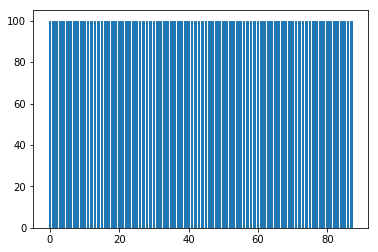

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 456 [0/5702 (0%)]	Loss: 0.000406
Train Epoch: 457 [0/5702 (0%)]	Loss: 0.000689
Train Epoch: 458 [0/5702 (0%)]	Loss: 0.001429
Train Epoch: 459 [0/5702 (0%)]	Loss: 0.000607
Train Epoch: 460 [0/5702 (0%)]	Loss: 0.000448


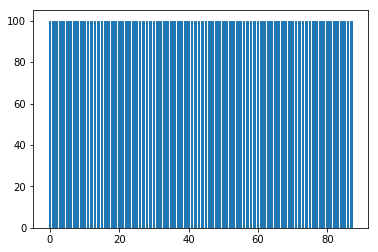

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 461 [0/5702 (0%)]	Loss: 0.000501
Train Epoch: 462 [0/5702 (0%)]	Loss: 0.000430
Train Epoch: 463 [0/5702 (0%)]	Loss: 0.001743
Train Epoch: 464 [0/5702 (0%)]	Loss: 0.000297
Train Epoch: 465 [0/5702 (0%)]	Loss: 0.000357


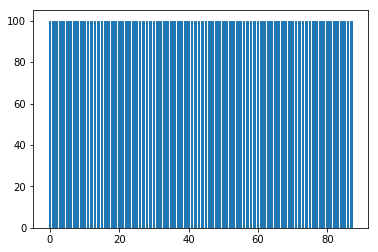

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 466 [0/5702 (0%)]	Loss: 0.000716
Train Epoch: 467 [0/5702 (0%)]	Loss: 0.000790
Train Epoch: 468 [0/5702 (0%)]	Loss: 0.000272
Train Epoch: 469 [0/5702 (0%)]	Loss: 0.000320
Train Epoch: 470 [0/5702 (0%)]	Loss: 0.000338


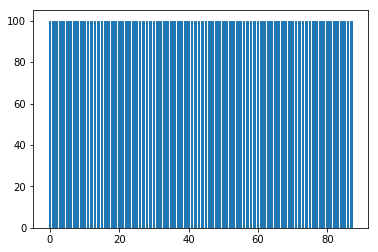

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 471 [0/5702 (0%)]	Loss: 0.000579
Train Epoch: 472 [0/5702 (0%)]	Loss: 0.001696
Train Epoch: 473 [0/5702 (0%)]	Loss: 0.000380
Train Epoch: 474 [0/5702 (0%)]	Loss: 0.000361
Train Epoch: 475 [0/5702 (0%)]	Loss: 0.000404


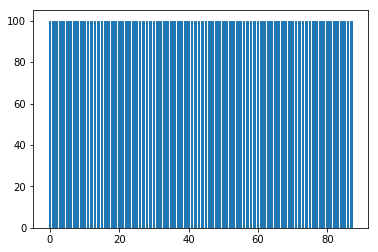

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 476 [0/5702 (0%)]	Loss: 0.000599
Train Epoch: 477 [0/5702 (0%)]	Loss: 0.000353
Train Epoch: 478 [0/5702 (0%)]	Loss: 0.000733
Train Epoch: 479 [0/5702 (0%)]	Loss: 0.000457
Train Epoch: 480 [0/5702 (0%)]	Loss: 0.000441


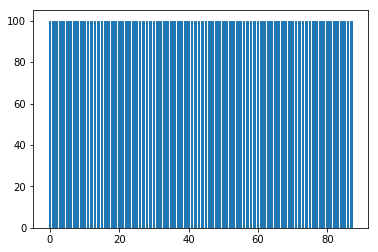

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 481 [0/5702 (0%)]	Loss: 0.000247
Train Epoch: 482 [0/5702 (0%)]	Loss: 0.001448
Train Epoch: 483 [0/5702 (0%)]	Loss: 0.000263
Train Epoch: 484 [0/5702 (0%)]	Loss: 0.000276
Train Epoch: 485 [0/5702 (0%)]	Loss: 0.000209


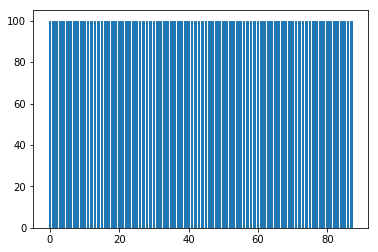

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 486 [0/5702 (0%)]	Loss: 0.000759
Train Epoch: 487 [0/5702 (0%)]	Loss: 0.000212
Train Epoch: 488 [0/5702 (0%)]	Loss: 0.000415
Train Epoch: 489 [0/5702 (0%)]	Loss: 0.000532
Train Epoch: 490 [0/5702 (0%)]	Loss: 0.000373


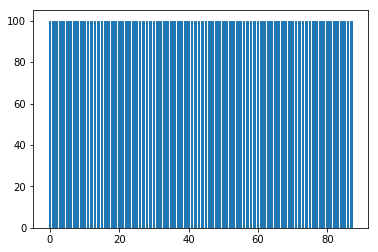

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 491 [0/5702 (0%)]	Loss: 0.000320
Train Epoch: 492 [0/5702 (0%)]	Loss: 0.000373
Train Epoch: 493 [0/5702 (0%)]	Loss: 0.000338
Train Epoch: 494 [0/5702 (0%)]	Loss: 0.000397
Train Epoch: 495 [0/5702 (0%)]	Loss: 0.000265


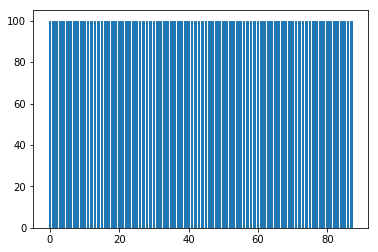

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 496 [0/5702 (0%)]	Loss: 0.000682
Train Epoch: 497 [0/5702 (0%)]	Loss: 0.000431
Train Epoch: 498 [0/5702 (0%)]	Loss: 0.000337
Train Epoch: 499 [0/5702 (0%)]	Loss: 0.000256
Train Epoch: 500 [0/5702 (0%)]	Loss: 0.000315


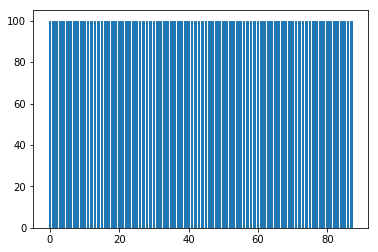

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 501 [0/5702 (0%)]	Loss: 0.000751
Train Epoch: 502 [0/5702 (0%)]	Loss: 0.000309
Train Epoch: 503 [0/5702 (0%)]	Loss: 0.000249
Train Epoch: 504 [0/5702 (0%)]	Loss: 0.000490
Train Epoch: 505 [0/5702 (0%)]	Loss: 0.000391


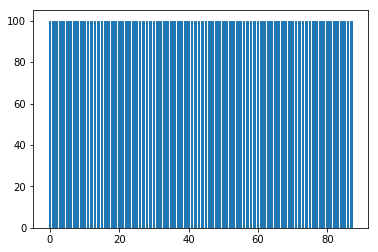

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 506 [0/5702 (0%)]	Loss: 0.000418
Train Epoch: 507 [0/5702 (0%)]	Loss: 0.000419
Train Epoch: 508 [0/5702 (0%)]	Loss: 0.000252
Train Epoch: 509 [0/5702 (0%)]	Loss: 0.000695
Train Epoch: 510 [0/5702 (0%)]	Loss: 0.000359


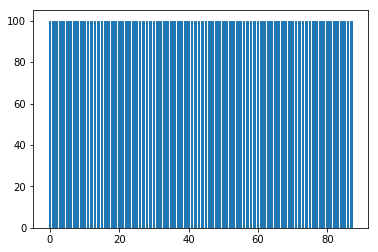

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 511 [0/5702 (0%)]	Loss: 0.001166
Train Epoch: 512 [0/5702 (0%)]	Loss: 0.000352
Train Epoch: 513 [0/5702 (0%)]	Loss: 0.000432
Train Epoch: 514 [0/5702 (0%)]	Loss: 0.000354
Train Epoch: 515 [0/5702 (0%)]	Loss: 0.000386


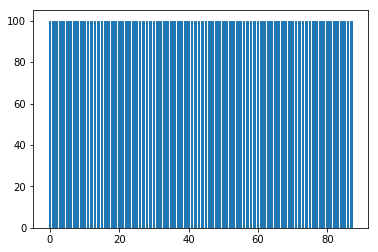

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 516 [0/5702 (0%)]	Loss: 0.000271
Train Epoch: 517 [0/5702 (0%)]	Loss: 0.000482
Train Epoch: 518 [0/5702 (0%)]	Loss: 0.000328
Train Epoch: 519 [0/5702 (0%)]	Loss: 0.000424
Train Epoch: 520 [0/5702 (0%)]	Loss: 0.000482


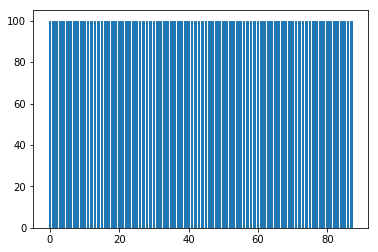

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 521 [0/5702 (0%)]	Loss: 0.000433
Train Epoch: 522 [0/5702 (0%)]	Loss: 0.001785
Train Epoch: 523 [0/5702 (0%)]	Loss: 0.001049
Train Epoch: 524 [0/5702 (0%)]	Loss: 0.000235
Train Epoch: 525 [0/5702 (0%)]	Loss: 0.000331


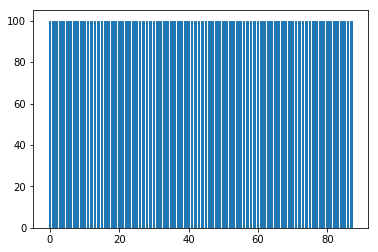

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 526 [0/5702 (0%)]	Loss: 0.000444
Train Epoch: 527 [0/5702 (0%)]	Loss: 0.000271
Train Epoch: 528 [0/5702 (0%)]	Loss: 0.000338
Train Epoch: 529 [0/5702 (0%)]	Loss: 0.000255
Train Epoch: 530 [0/5702 (0%)]	Loss: 0.000319


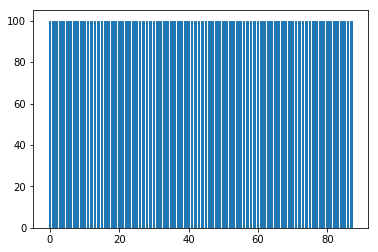

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 531 [0/5702 (0%)]	Loss: 0.000287
Train Epoch: 532 [0/5702 (0%)]	Loss: 0.000369
Train Epoch: 533 [0/5702 (0%)]	Loss: 0.000375
Train Epoch: 534 [0/5702 (0%)]	Loss: 0.001870
Train Epoch: 535 [0/5702 (0%)]	Loss: 0.001141


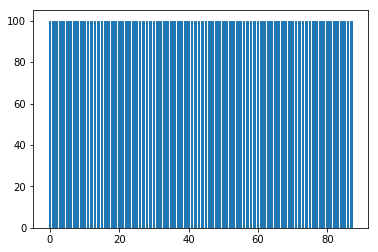

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 536 [0/5702 (0%)]	Loss: 0.000336
Train Epoch: 537 [0/5702 (0%)]	Loss: 0.000368
Train Epoch: 538 [0/5702 (0%)]	Loss: 0.000276
Train Epoch: 539 [0/5702 (0%)]	Loss: 0.000482
Train Epoch: 540 [0/5702 (0%)]	Loss: 0.000245


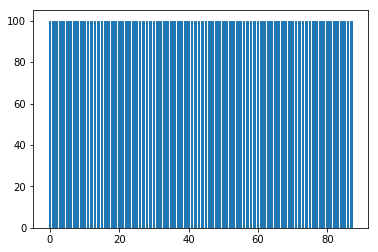

300
0

Test set: Average loss: 0.0006, Accuracy: 300/300 (100%)

Train Epoch: 541 [0/5702 (0%)]	Loss: 0.001068
Train Epoch: 542 [0/5702 (0%)]	Loss: 0.000391
Train Epoch: 543 [0/5702 (0%)]	Loss: 0.000305
Train Epoch: 544 [0/5702 (0%)]	Loss: 0.000368
Train Epoch: 545 [0/5702 (0%)]	Loss: 0.000256


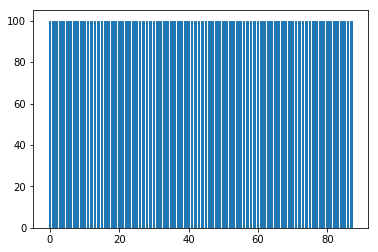

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 546 [0/5702 (0%)]	Loss: 0.000585
Train Epoch: 547 [0/5702 (0%)]	Loss: 0.000417
Train Epoch: 548 [0/5702 (0%)]	Loss: 0.000315
Train Epoch: 549 [0/5702 (0%)]	Loss: 0.000394
Train Epoch: 550 [0/5702 (0%)]	Loss: 0.000353


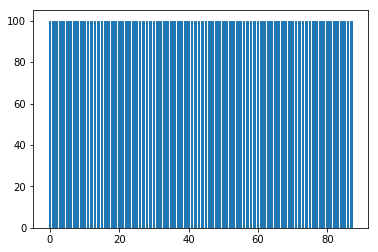

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 551 [0/5702 (0%)]	Loss: 0.000342
Train Epoch: 552 [0/5702 (0%)]	Loss: 0.000263
Train Epoch: 553 [0/5702 (0%)]	Loss: 0.000174
Train Epoch: 554 [0/5702 (0%)]	Loss: 0.000805
Train Epoch: 555 [0/5702 (0%)]	Loss: 0.000211


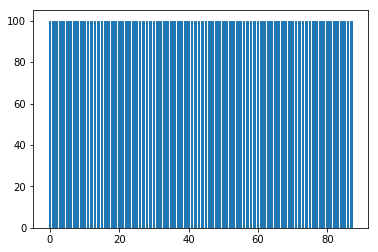

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 556 [0/5702 (0%)]	Loss: 0.000461
Train Epoch: 557 [0/5702 (0%)]	Loss: 0.001448
Train Epoch: 558 [0/5702 (0%)]	Loss: 0.000300
Train Epoch: 559 [0/5702 (0%)]	Loss: 0.000555
Train Epoch: 560 [0/5702 (0%)]	Loss: 0.000474


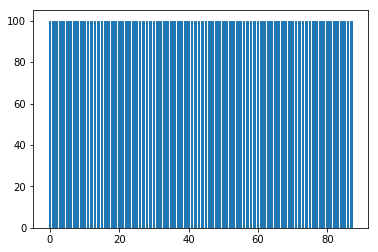

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 561 [0/5702 (0%)]	Loss: 0.000241
Train Epoch: 562 [0/5702 (0%)]	Loss: 0.000216
Train Epoch: 563 [0/5702 (0%)]	Loss: 0.000243
Train Epoch: 564 [0/5702 (0%)]	Loss: 0.000433
Train Epoch: 565 [0/5702 (0%)]	Loss: 0.000221


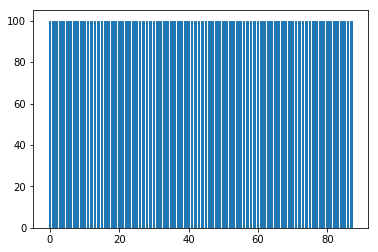

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 566 [0/5702 (0%)]	Loss: 0.001492
Train Epoch: 567 [0/5702 (0%)]	Loss: 0.000353
Train Epoch: 568 [0/5702 (0%)]	Loss: 0.000331
Train Epoch: 569 [0/5702 (0%)]	Loss: 0.000315
Train Epoch: 570 [0/5702 (0%)]	Loss: 0.000410


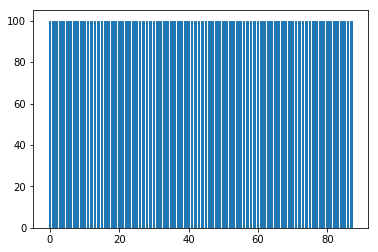

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 571 [0/5702 (0%)]	Loss: 0.000231
Train Epoch: 572 [0/5702 (0%)]	Loss: 0.000313
Train Epoch: 573 [0/5702 (0%)]	Loss: 0.000454
Train Epoch: 574 [0/5702 (0%)]	Loss: 0.001034
Train Epoch: 575 [0/5702 (0%)]	Loss: 0.000376


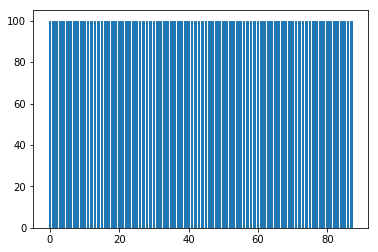

300
0

Test set: Average loss: 0.0007, Accuracy: 300/300 (100%)

Train Epoch: 576 [0/5702 (0%)]	Loss: 0.001104
Train Epoch: 577 [0/5702 (0%)]	Loss: 0.000377
Train Epoch: 578 [0/5702 (0%)]	Loss: 0.000445
Train Epoch: 579 [0/5702 (0%)]	Loss: 0.000397
Train Epoch: 580 [0/5702 (0%)]	Loss: 0.000203


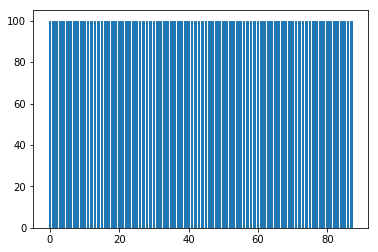

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 581 [0/5702 (0%)]	Loss: 0.000288
Train Epoch: 582 [0/5702 (0%)]	Loss: 0.000439
Train Epoch: 583 [0/5702 (0%)]	Loss: 0.000349
Train Epoch: 584 [0/5702 (0%)]	Loss: 0.000230
Train Epoch: 585 [0/5702 (0%)]	Loss: 0.000531


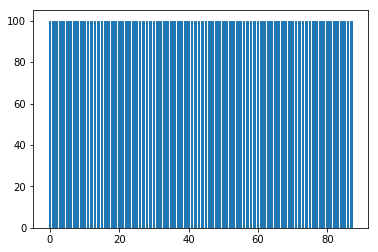

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 586 [0/5702 (0%)]	Loss: 0.000318
Train Epoch: 587 [0/5702 (0%)]	Loss: 0.000241
Train Epoch: 588 [0/5702 (0%)]	Loss: 0.000328
Train Epoch: 589 [0/5702 (0%)]	Loss: 0.000378
Train Epoch: 590 [0/5702 (0%)]	Loss: 0.000232


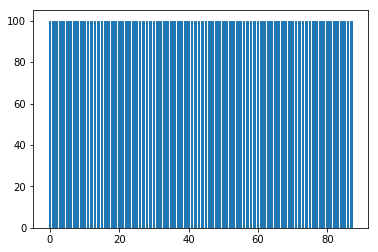

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 591 [0/5702 (0%)]	Loss: 0.000404
Train Epoch: 592 [0/5702 (0%)]	Loss: 0.000324
Train Epoch: 593 [0/5702 (0%)]	Loss: 0.000127
Train Epoch: 594 [0/5702 (0%)]	Loss: 0.000305
Train Epoch: 595 [0/5702 (0%)]	Loss: 0.000345


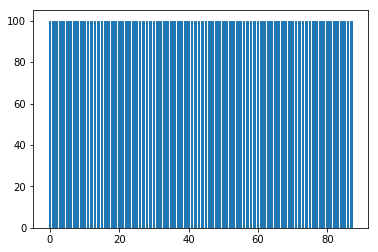

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 596 [0/5702 (0%)]	Loss: 0.000333
Train Epoch: 597 [0/5702 (0%)]	Loss: 0.000373
Train Epoch: 598 [0/5702 (0%)]	Loss: 0.000175
Train Epoch: 599 [0/5702 (0%)]	Loss: 0.000239
Train Epoch: 600 [0/5702 (0%)]	Loss: 0.000352


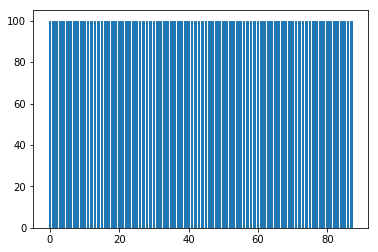

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 601 [0/5702 (0%)]	Loss: 0.000220
Train Epoch: 602 [0/5702 (0%)]	Loss: 0.000197
Train Epoch: 603 [0/5702 (0%)]	Loss: 0.000292
Train Epoch: 604 [0/5702 (0%)]	Loss: 0.000242
Train Epoch: 605 [0/5702 (0%)]	Loss: 0.000177


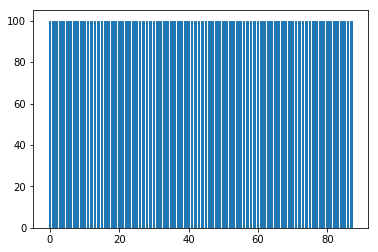

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 606 [0/5702 (0%)]	Loss: 0.000246
Train Epoch: 607 [0/5702 (0%)]	Loss: 0.000295
Train Epoch: 608 [0/5702 (0%)]	Loss: 0.000268
Train Epoch: 609 [0/5702 (0%)]	Loss: 0.000259
Train Epoch: 610 [0/5702 (0%)]	Loss: 0.000236


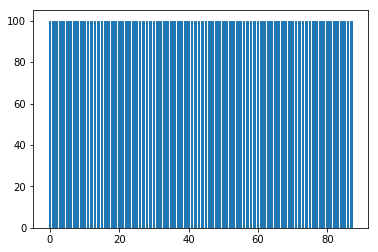

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 611 [0/5702 (0%)]	Loss: 0.000177
Train Epoch: 612 [0/5702 (0%)]	Loss: 0.002024
Train Epoch: 613 [0/5702 (0%)]	Loss: 0.000173
Train Epoch: 614 [0/5702 (0%)]	Loss: 0.000280
Train Epoch: 615 [0/5702 (0%)]	Loss: 0.000332


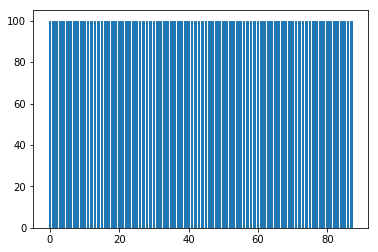

300
0

Test set: Average loss: 0.0009, Accuracy: 300/300 (100%)

Train Epoch: 616 [0/5702 (0%)]	Loss: 0.002243
Train Epoch: 617 [0/5702 (0%)]	Loss: 0.000414
Train Epoch: 618 [0/5702 (0%)]	Loss: 0.000510
Train Epoch: 619 [0/5702 (0%)]	Loss: 0.000235
Train Epoch: 620 [0/5702 (0%)]	Loss: 0.000309


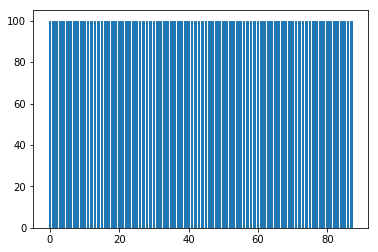

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 621 [0/5702 (0%)]	Loss: 0.000465
Train Epoch: 622 [0/5702 (0%)]	Loss: 0.000274
Train Epoch: 623 [0/5702 (0%)]	Loss: 0.000260
Train Epoch: 624 [0/5702 (0%)]	Loss: 0.000594
Train Epoch: 625 [0/5702 (0%)]	Loss: 0.000174


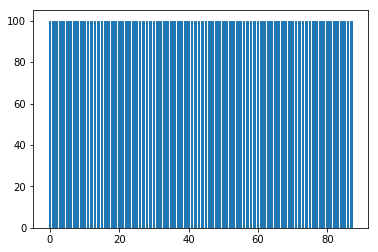

300
0

Test set: Average loss: 0.0002, Accuracy: 300/300 (100%)

Train Epoch: 626 [0/5702 (0%)]	Loss: 0.000241
Train Epoch: 627 [0/5702 (0%)]	Loss: 0.000301
Train Epoch: 628 [0/5702 (0%)]	Loss: 0.000229
Train Epoch: 629 [0/5702 (0%)]	Loss: 0.000275
Train Epoch: 630 [0/5702 (0%)]	Loss: 0.000303


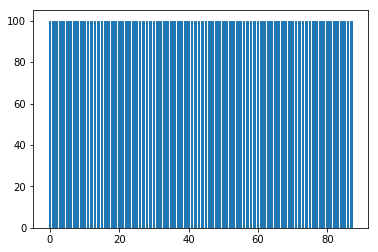

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 631 [0/5702 (0%)]	Loss: 0.000382
Train Epoch: 632 [0/5702 (0%)]	Loss: 0.000250
Train Epoch: 633 [0/5702 (0%)]	Loss: 0.000230
Train Epoch: 634 [0/5702 (0%)]	Loss: 0.000312
Train Epoch: 635 [0/5702 (0%)]	Loss: 0.000130


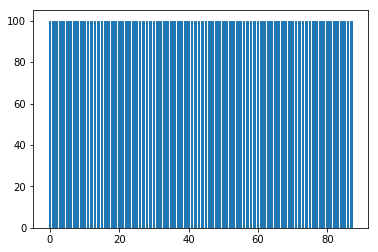

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 636 [0/5702 (0%)]	Loss: 0.000306
Train Epoch: 637 [0/5702 (0%)]	Loss: 0.000495
Train Epoch: 638 [0/5702 (0%)]	Loss: 0.001101
Train Epoch: 639 [0/5702 (0%)]	Loss: 0.000546
Train Epoch: 640 [0/5702 (0%)]	Loss: 0.000235


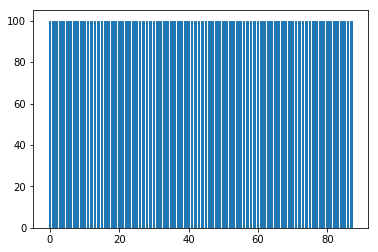

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 641 [0/5702 (0%)]	Loss: 0.000382
Train Epoch: 642 [0/5702 (0%)]	Loss: 0.000151
Train Epoch: 643 [0/5702 (0%)]	Loss: 0.000235
Train Epoch: 644 [0/5702 (0%)]	Loss: 0.000347
Train Epoch: 645 [0/5702 (0%)]	Loss: 0.000400


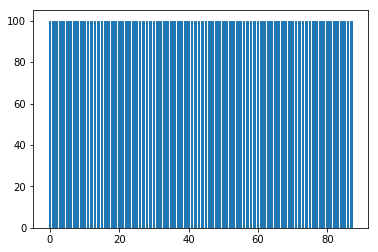

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 646 [0/5702 (0%)]	Loss: 0.000408
Train Epoch: 647 [0/5702 (0%)]	Loss: 0.000362
Train Epoch: 648 [0/5702 (0%)]	Loss: 0.000139
Train Epoch: 649 [0/5702 (0%)]	Loss: 0.001501
Train Epoch: 650 [0/5702 (0%)]	Loss: 0.000253


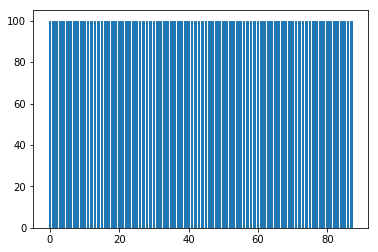

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 651 [0/5702 (0%)]	Loss: 0.000229
Train Epoch: 652 [0/5702 (0%)]	Loss: 0.000172
Train Epoch: 653 [0/5702 (0%)]	Loss: 0.000284
Train Epoch: 654 [0/5702 (0%)]	Loss: 0.000517
Train Epoch: 655 [0/5702 (0%)]	Loss: 0.000175


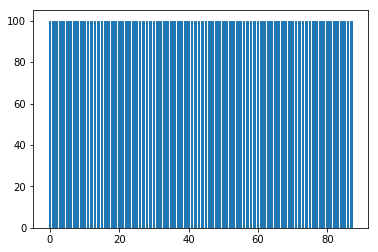

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 656 [0/5702 (0%)]	Loss: 0.000206
Train Epoch: 657 [0/5702 (0%)]	Loss: 0.000156
Train Epoch: 658 [0/5702 (0%)]	Loss: 0.000227
Train Epoch: 659 [0/5702 (0%)]	Loss: 0.000179
Train Epoch: 660 [0/5702 (0%)]	Loss: 0.001624


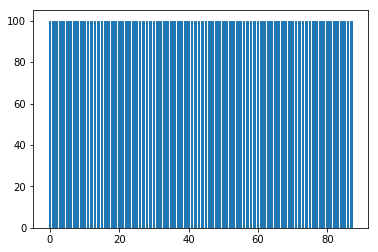

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 661 [0/5702 (0%)]	Loss: 0.000251
Train Epoch: 662 [0/5702 (0%)]	Loss: 0.000110
Train Epoch: 663 [0/5702 (0%)]	Loss: 0.000180
Train Epoch: 664 [0/5702 (0%)]	Loss: 0.000274
Train Epoch: 665 [0/5702 (0%)]	Loss: 0.000219


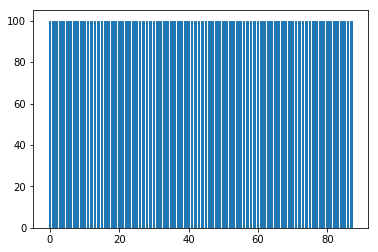

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 666 [0/5702 (0%)]	Loss: 0.000315
Train Epoch: 667 [0/5702 (0%)]	Loss: 0.000127
Train Epoch: 668 [0/5702 (0%)]	Loss: 0.000240
Train Epoch: 669 [0/5702 (0%)]	Loss: 0.000240
Train Epoch: 670 [0/5702 (0%)]	Loss: 0.000200


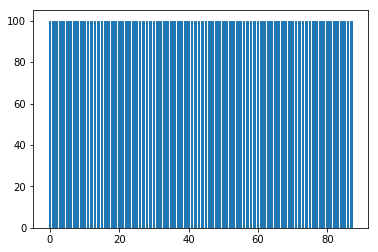

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 671 [0/5702 (0%)]	Loss: 0.000303
Train Epoch: 672 [0/5702 (0%)]	Loss: 0.000252
Train Epoch: 673 [0/5702 (0%)]	Loss: 0.000262
Train Epoch: 674 [0/5702 (0%)]	Loss: 0.000141
Train Epoch: 675 [0/5702 (0%)]	Loss: 0.001228


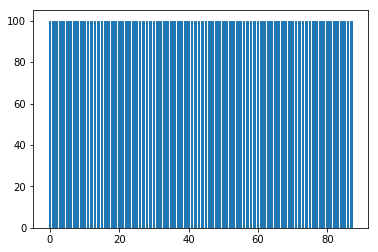

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 676 [0/5702 (0%)]	Loss: 0.000217
Train Epoch: 677 [0/5702 (0%)]	Loss: 0.000099
Train Epoch: 678 [0/5702 (0%)]	Loss: 0.000230
Train Epoch: 679 [0/5702 (0%)]	Loss: 0.000329
Train Epoch: 680 [0/5702 (0%)]	Loss: 0.000129


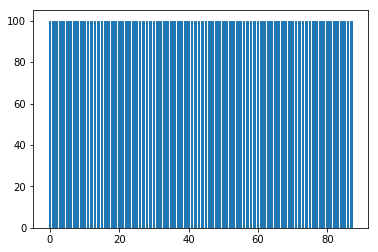

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 681 [0/5702 (0%)]	Loss: 0.000241
Train Epoch: 682 [0/5702 (0%)]	Loss: 0.000197
Train Epoch: 683 [0/5702 (0%)]	Loss: 0.000129
Train Epoch: 684 [0/5702 (0%)]	Loss: 0.000373
Train Epoch: 685 [0/5702 (0%)]	Loss: 0.000171


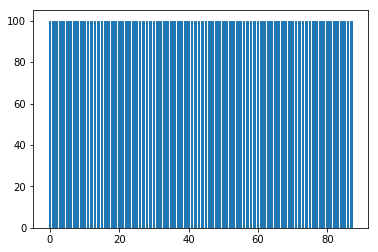

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 686 [0/5702 (0%)]	Loss: 0.000917
Train Epoch: 687 [0/5702 (0%)]	Loss: 0.000157
Train Epoch: 688 [0/5702 (0%)]	Loss: 0.000287
Train Epoch: 689 [0/5702 (0%)]	Loss: 0.000139
Train Epoch: 690 [0/5702 (0%)]	Loss: 0.000192


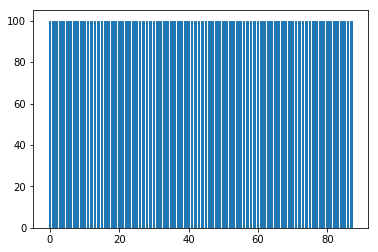

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 691 [0/5702 (0%)]	Loss: 0.000342
Train Epoch: 692 [0/5702 (0%)]	Loss: 0.000274
Train Epoch: 693 [0/5702 (0%)]	Loss: 0.000212
Train Epoch: 694 [0/5702 (0%)]	Loss: 0.000218
Train Epoch: 695 [0/5702 (0%)]	Loss: 0.000223


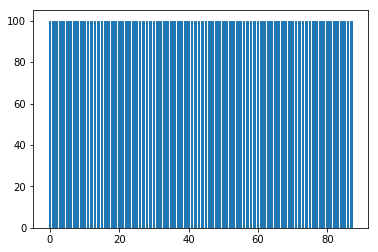

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 696 [0/5702 (0%)]	Loss: 0.000373
Train Epoch: 697 [0/5702 (0%)]	Loss: 0.000234
Train Epoch: 698 [0/5702 (0%)]	Loss: 0.000289
Train Epoch: 699 [0/5702 (0%)]	Loss: 0.000125
Train Epoch: 700 [0/5702 (0%)]	Loss: 0.000340


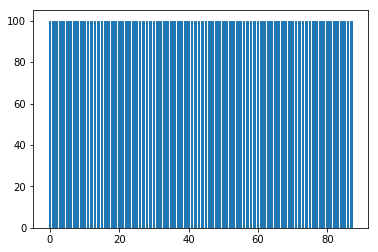

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 701 [0/5702 (0%)]	Loss: 0.000244
Train Epoch: 702 [0/5702 (0%)]	Loss: 0.000225
Train Epoch: 703 [0/5702 (0%)]	Loss: 0.000162
Train Epoch: 704 [0/5702 (0%)]	Loss: 0.000277
Train Epoch: 705 [0/5702 (0%)]	Loss: 0.000243


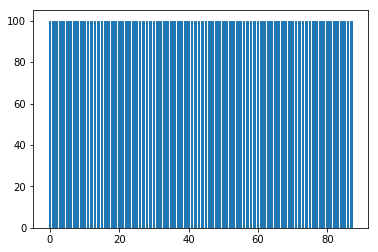

300
0

Test set: Average loss: 0.0014, Accuracy: 300/300 (100%)

Train Epoch: 706 [0/5702 (0%)]	Loss: 0.004378
Train Epoch: 707 [0/5702 (0%)]	Loss: 0.000236
Train Epoch: 708 [0/5702 (0%)]	Loss: 0.000292
Train Epoch: 709 [0/5702 (0%)]	Loss: 0.000165
Train Epoch: 710 [0/5702 (0%)]	Loss: 0.000263


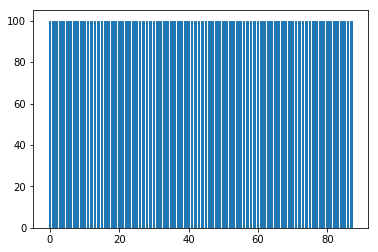

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 711 [0/5702 (0%)]	Loss: 0.000246
Train Epoch: 712 [0/5702 (0%)]	Loss: 0.000197
Train Epoch: 713 [0/5702 (0%)]	Loss: 0.000355
Train Epoch: 714 [0/5702 (0%)]	Loss: 0.000161
Train Epoch: 715 [0/5702 (0%)]	Loss: 0.000311


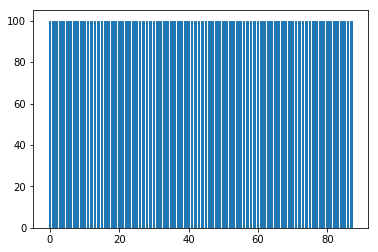

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 716 [0/5702 (0%)]	Loss: 0.000197
Train Epoch: 717 [0/5702 (0%)]	Loss: 0.000142
Train Epoch: 718 [0/5702 (0%)]	Loss: 0.000360
Train Epoch: 719 [0/5702 (0%)]	Loss: 0.000132
Train Epoch: 720 [0/5702 (0%)]	Loss: 0.000192


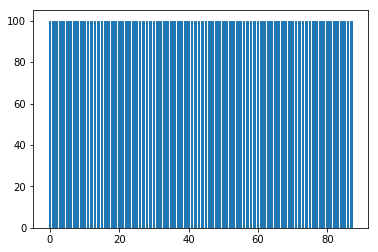

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 721 [0/5702 (0%)]	Loss: 0.000949
Train Epoch: 722 [0/5702 (0%)]	Loss: 0.000356
Train Epoch: 723 [0/5702 (0%)]	Loss: 0.000266
Train Epoch: 724 [0/5702 (0%)]	Loss: 0.000208
Train Epoch: 725 [0/5702 (0%)]	Loss: 0.000264


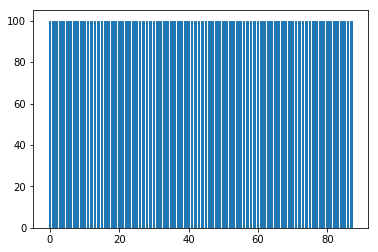

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 726 [0/5702 (0%)]	Loss: 0.000208
Train Epoch: 727 [0/5702 (0%)]	Loss: 0.000213
Train Epoch: 728 [0/5702 (0%)]	Loss: 0.000335
Train Epoch: 729 [0/5702 (0%)]	Loss: 0.000235
Train Epoch: 730 [0/5702 (0%)]	Loss: 0.000178


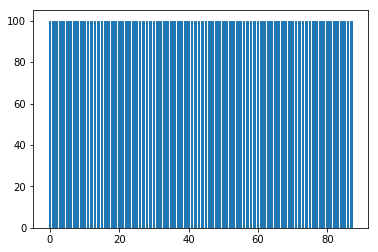

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 731 [0/5702 (0%)]	Loss: 0.000318
Train Epoch: 732 [0/5702 (0%)]	Loss: 0.000846
Train Epoch: 733 [0/5702 (0%)]	Loss: 0.000287
Train Epoch: 734 [0/5702 (0%)]	Loss: 0.000293
Train Epoch: 735 [0/5702 (0%)]	Loss: 0.000467


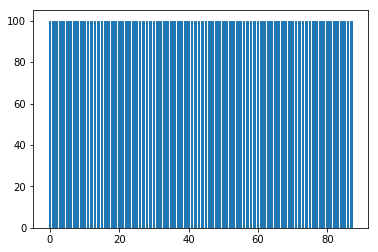

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 736 [0/5702 (0%)]	Loss: 0.000216
Train Epoch: 737 [0/5702 (0%)]	Loss: 0.000466
Train Epoch: 738 [0/5702 (0%)]	Loss: 0.000148
Train Epoch: 739 [0/5702 (0%)]	Loss: 0.000210
Train Epoch: 740 [0/5702 (0%)]	Loss: 0.000173


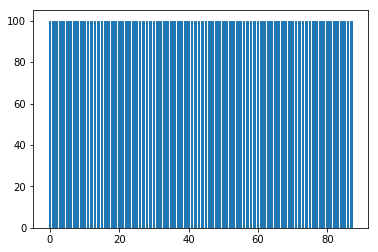

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 741 [0/5702 (0%)]	Loss: 0.000267
Train Epoch: 742 [0/5702 (0%)]	Loss: 0.000282
Train Epoch: 743 [0/5702 (0%)]	Loss: 0.000359
Train Epoch: 744 [0/5702 (0%)]	Loss: 0.000274
Train Epoch: 745 [0/5702 (0%)]	Loss: 0.000166


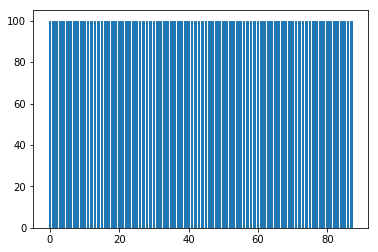

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 746 [0/5702 (0%)]	Loss: 0.000237
Train Epoch: 747 [0/5702 (0%)]	Loss: 0.000190
Train Epoch: 748 [0/5702 (0%)]	Loss: 0.000128
Train Epoch: 749 [0/5702 (0%)]	Loss: 0.000159
Train Epoch: 750 [0/5702 (0%)]	Loss: 0.000186


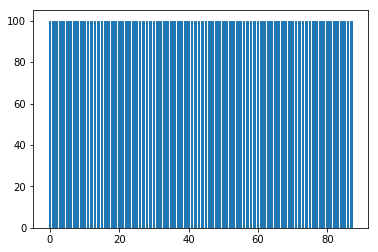

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 751 [0/5702 (0%)]	Loss: 0.000221
Train Epoch: 752 [0/5702 (0%)]	Loss: 0.000207
Train Epoch: 753 [0/5702 (0%)]	Loss: 0.000267
Train Epoch: 754 [0/5702 (0%)]	Loss: 0.000201
Train Epoch: 755 [0/5702 (0%)]	Loss: 0.000175


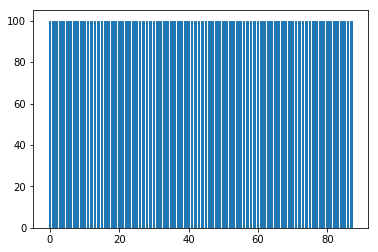

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 756 [0/5702 (0%)]	Loss: 0.000834
Train Epoch: 757 [0/5702 (0%)]	Loss: 0.000240
Train Epoch: 758 [0/5702 (0%)]	Loss: 0.000249
Train Epoch: 759 [0/5702 (0%)]	Loss: 0.000175
Train Epoch: 760 [0/5702 (0%)]	Loss: 0.000256


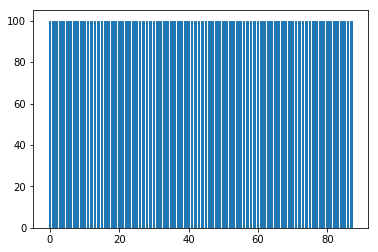

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 761 [0/5702 (0%)]	Loss: 0.000169
Train Epoch: 762 [0/5702 (0%)]	Loss: 0.000130
Train Epoch: 763 [0/5702 (0%)]	Loss: 0.000189
Train Epoch: 764 [0/5702 (0%)]	Loss: 0.000435
Train Epoch: 765 [0/5702 (0%)]	Loss: 0.000189


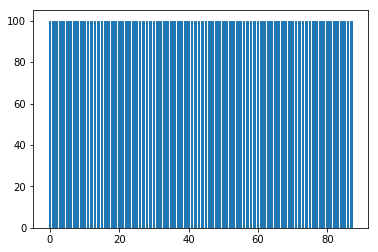

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 766 [0/5702 (0%)]	Loss: 0.000129
Train Epoch: 767 [0/5702 (0%)]	Loss: 0.000275
Train Epoch: 768 [0/5702 (0%)]	Loss: 0.000149
Train Epoch: 769 [0/5702 (0%)]	Loss: 0.000143
Train Epoch: 770 [0/5702 (0%)]	Loss: 0.000309


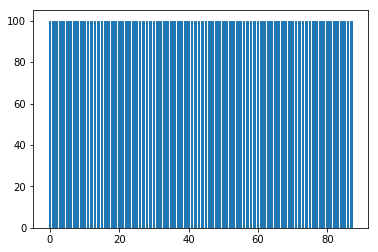

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 771 [0/5702 (0%)]	Loss: 0.000166
Train Epoch: 772 [0/5702 (0%)]	Loss: 0.000083
Train Epoch: 773 [0/5702 (0%)]	Loss: 0.000482
Train Epoch: 774 [0/5702 (0%)]	Loss: 0.000299
Train Epoch: 775 [0/5702 (0%)]	Loss: 0.000159


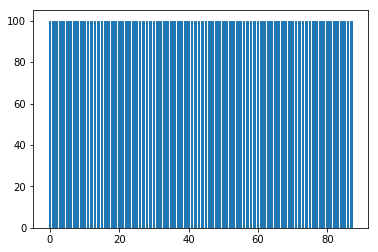

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 776 [0/5702 (0%)]	Loss: 0.000117
Train Epoch: 777 [0/5702 (0%)]	Loss: 0.000192
Train Epoch: 778 [0/5702 (0%)]	Loss: 0.000112
Train Epoch: 779 [0/5702 (0%)]	Loss: 0.000223
Train Epoch: 780 [0/5702 (0%)]	Loss: 0.000435


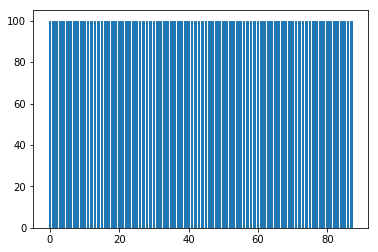

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 781 [0/5702 (0%)]	Loss: 0.000151
Train Epoch: 782 [0/5702 (0%)]	Loss: 0.000225
Train Epoch: 783 [0/5702 (0%)]	Loss: 0.000160
Train Epoch: 784 [0/5702 (0%)]	Loss: 0.000174
Train Epoch: 785 [0/5702 (0%)]	Loss: 0.000218


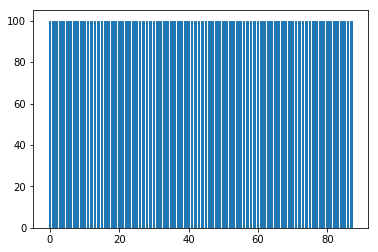

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 786 [0/5702 (0%)]	Loss: 0.000146
Train Epoch: 787 [0/5702 (0%)]	Loss: 0.000173
Train Epoch: 788 [0/5702 (0%)]	Loss: 0.000194
Train Epoch: 789 [0/5702 (0%)]	Loss: 0.000309
Train Epoch: 790 [0/5702 (0%)]	Loss: 0.000228


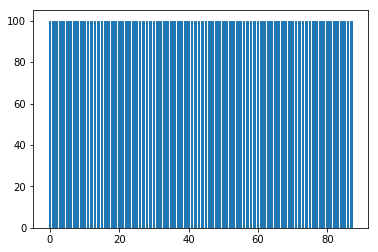

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 791 [0/5702 (0%)]	Loss: 0.000282
Train Epoch: 792 [0/5702 (0%)]	Loss: 0.000197
Train Epoch: 793 [0/5702 (0%)]	Loss: 0.000163
Train Epoch: 794 [0/5702 (0%)]	Loss: 0.000166
Train Epoch: 795 [0/5702 (0%)]	Loss: 0.000336


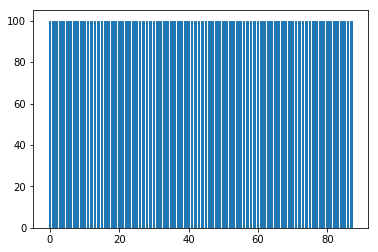

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 796 [0/5702 (0%)]	Loss: 0.000152
Train Epoch: 797 [0/5702 (0%)]	Loss: 0.000178
Train Epoch: 798 [0/5702 (0%)]	Loss: 0.000259
Train Epoch: 799 [0/5702 (0%)]	Loss: 0.000132
Train Epoch: 800 [0/5702 (0%)]	Loss: 0.000167


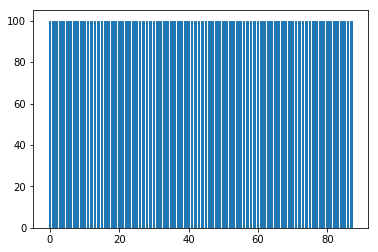

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 801 [0/5702 (0%)]	Loss: 0.000198
Train Epoch: 802 [0/5702 (0%)]	Loss: 0.000111
Train Epoch: 803 [0/5702 (0%)]	Loss: 0.000169
Train Epoch: 804 [0/5702 (0%)]	Loss: 0.000123
Train Epoch: 805 [0/5702 (0%)]	Loss: 0.000195


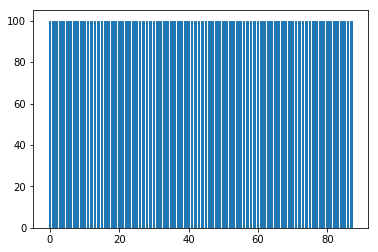

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 806 [0/5702 (0%)]	Loss: 0.001232
Train Epoch: 807 [0/5702 (0%)]	Loss: 0.000191
Train Epoch: 808 [0/5702 (0%)]	Loss: 0.000266
Train Epoch: 809 [0/5702 (0%)]	Loss: 0.000173
Train Epoch: 810 [0/5702 (0%)]	Loss: 0.000154


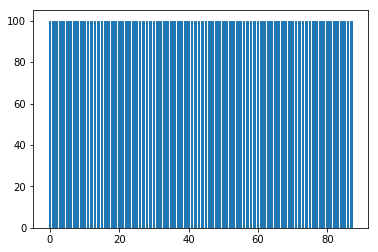

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 811 [0/5702 (0%)]	Loss: 0.000115
Train Epoch: 812 [0/5702 (0%)]	Loss: 0.000187
Train Epoch: 813 [0/5702 (0%)]	Loss: 0.000394
Train Epoch: 814 [0/5702 (0%)]	Loss: 0.000231
Train Epoch: 815 [0/5702 (0%)]	Loss: 0.000148


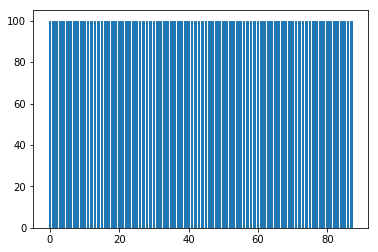

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 816 [0/5702 (0%)]	Loss: 0.000176
Train Epoch: 817 [0/5702 (0%)]	Loss: 0.000122
Train Epoch: 818 [0/5702 (0%)]	Loss: 0.000259
Train Epoch: 819 [0/5702 (0%)]	Loss: 0.000222
Train Epoch: 820 [0/5702 (0%)]	Loss: 0.000096


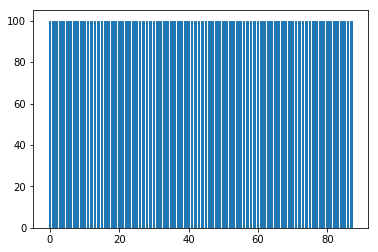

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 821 [0/5702 (0%)]	Loss: 0.000275
Train Epoch: 822 [0/5702 (0%)]	Loss: 0.000142
Train Epoch: 823 [0/5702 (0%)]	Loss: 0.000136
Train Epoch: 824 [0/5702 (0%)]	Loss: 0.000181
Train Epoch: 825 [0/5702 (0%)]	Loss: 0.000221


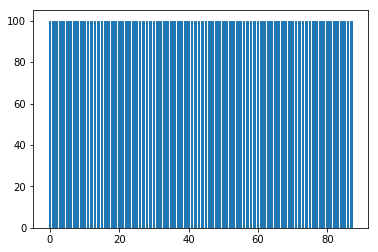

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 826 [0/5702 (0%)]	Loss: 0.000108
Train Epoch: 827 [0/5702 (0%)]	Loss: 0.000212
Train Epoch: 828 [0/5702 (0%)]	Loss: 0.000208
Train Epoch: 829 [0/5702 (0%)]	Loss: 0.000181
Train Epoch: 830 [0/5702 (0%)]	Loss: 0.000179


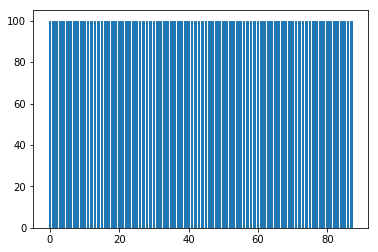

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 831 [0/5702 (0%)]	Loss: 0.000253
Train Epoch: 832 [0/5702 (0%)]	Loss: 0.000148
Train Epoch: 833 [0/5702 (0%)]	Loss: 0.000170
Train Epoch: 834 [0/5702 (0%)]	Loss: 0.000139
Train Epoch: 835 [0/5702 (0%)]	Loss: 0.000191


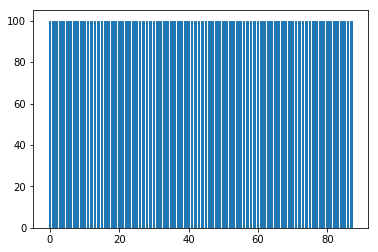

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 836 [0/5702 (0%)]	Loss: 0.000174
Train Epoch: 837 [0/5702 (0%)]	Loss: 0.001767
Train Epoch: 838 [0/5702 (0%)]	Loss: 0.000254
Train Epoch: 839 [0/5702 (0%)]	Loss: 0.000098
Train Epoch: 840 [0/5702 (0%)]	Loss: 0.000351


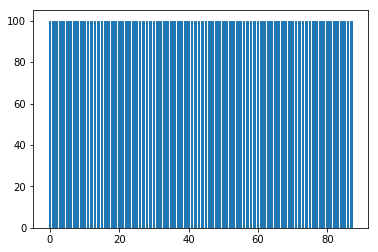

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 841 [0/5702 (0%)]	Loss: 0.000197
Train Epoch: 842 [0/5702 (0%)]	Loss: 0.000144
Train Epoch: 843 [0/5702 (0%)]	Loss: 0.000262
Train Epoch: 844 [0/5702 (0%)]	Loss: 0.000093
Train Epoch: 845 [0/5702 (0%)]	Loss: 0.000165


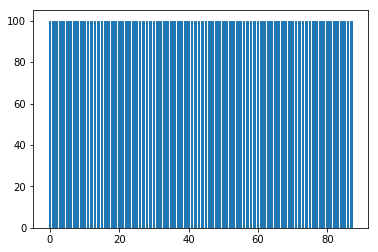

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 846 [0/5702 (0%)]	Loss: 0.000141
Train Epoch: 847 [0/5702 (0%)]	Loss: 0.000291
Train Epoch: 848 [0/5702 (0%)]	Loss: 0.000131
Train Epoch: 849 [0/5702 (0%)]	Loss: 0.000175
Train Epoch: 850 [0/5702 (0%)]	Loss: 0.000230


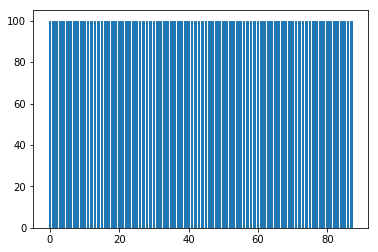

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 851 [0/5702 (0%)]	Loss: 0.000192
Train Epoch: 852 [0/5702 (0%)]	Loss: 0.000114
Train Epoch: 853 [0/5702 (0%)]	Loss: 0.000124
Train Epoch: 854 [0/5702 (0%)]	Loss: 0.000224
Train Epoch: 855 [0/5702 (0%)]	Loss: 0.000213


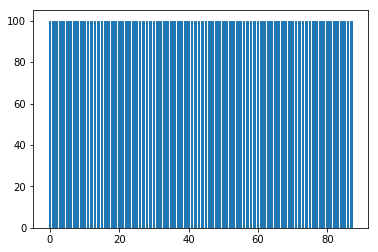

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 856 [0/5702 (0%)]	Loss: 0.000165
Train Epoch: 857 [0/5702 (0%)]	Loss: 0.000100
Train Epoch: 858 [0/5702 (0%)]	Loss: 0.000225
Train Epoch: 859 [0/5702 (0%)]	Loss: 0.000361
Train Epoch: 860 [0/5702 (0%)]	Loss: 0.000168


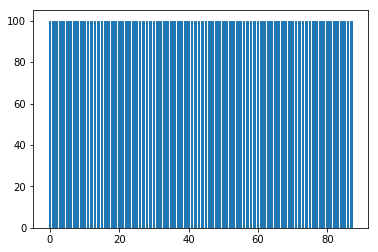

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 861 [0/5702 (0%)]	Loss: 0.000138
Train Epoch: 862 [0/5702 (0%)]	Loss: 0.000323
Train Epoch: 863 [0/5702 (0%)]	Loss: 0.000081
Train Epoch: 864 [0/5702 (0%)]	Loss: 0.000150
Train Epoch: 865 [0/5702 (0%)]	Loss: 0.000102


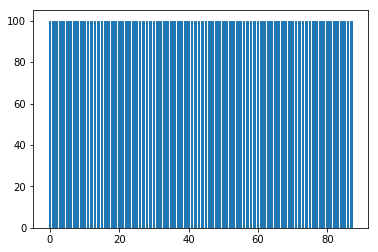

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 866 [0/5702 (0%)]	Loss: 0.000209
Train Epoch: 867 [0/5702 (0%)]	Loss: 0.000115
Train Epoch: 868 [0/5702 (0%)]	Loss: 0.000214
Train Epoch: 869 [0/5702 (0%)]	Loss: 0.000147
Train Epoch: 870 [0/5702 (0%)]	Loss: 0.000121


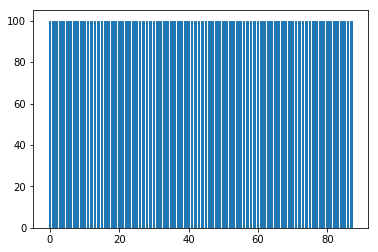

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 871 [0/5702 (0%)]	Loss: 0.000189
Train Epoch: 872 [0/5702 (0%)]	Loss: 0.000165
Train Epoch: 873 [0/5702 (0%)]	Loss: 0.000162
Train Epoch: 874 [0/5702 (0%)]	Loss: 0.000169
Train Epoch: 875 [0/5702 (0%)]	Loss: 0.000103


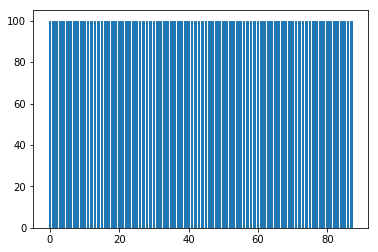

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 876 [0/5702 (0%)]	Loss: 0.000106
Train Epoch: 877 [0/5702 (0%)]	Loss: 0.000230
Train Epoch: 878 [0/5702 (0%)]	Loss: 0.000184
Train Epoch: 879 [0/5702 (0%)]	Loss: 0.000188
Train Epoch: 880 [0/5702 (0%)]	Loss: 0.000173


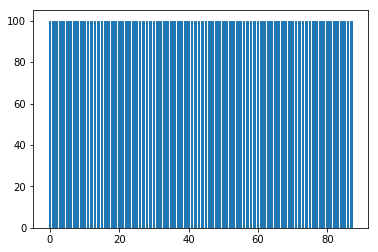

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 881 [0/5702 (0%)]	Loss: 0.000310
Train Epoch: 882 [0/5702 (0%)]	Loss: 0.000205
Train Epoch: 883 [0/5702 (0%)]	Loss: 0.000162
Train Epoch: 884 [0/5702 (0%)]	Loss: 0.000173
Train Epoch: 885 [0/5702 (0%)]	Loss: 0.000197


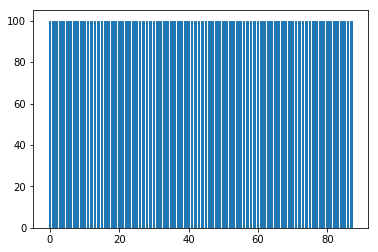

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 886 [0/5702 (0%)]	Loss: 0.000107
Train Epoch: 887 [0/5702 (0%)]	Loss: 0.000163
Train Epoch: 888 [0/5702 (0%)]	Loss: 0.000207
Train Epoch: 889 [0/5702 (0%)]	Loss: 0.000214
Train Epoch: 890 [0/5702 (0%)]	Loss: 0.000167


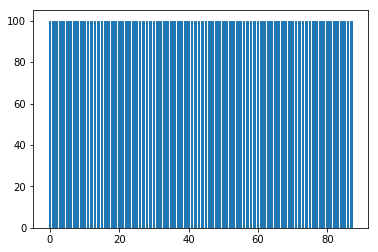

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 891 [0/5702 (0%)]	Loss: 0.000141
Train Epoch: 892 [0/5702 (0%)]	Loss: 0.000239
Train Epoch: 893 [0/5702 (0%)]	Loss: 0.000144
Train Epoch: 894 [0/5702 (0%)]	Loss: 0.000138
Train Epoch: 895 [0/5702 (0%)]	Loss: 0.000129


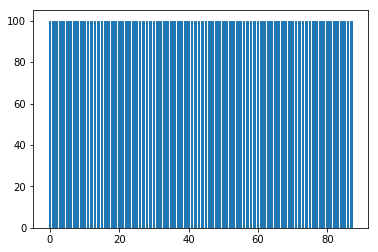

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 896 [0/5702 (0%)]	Loss: 0.000189
Train Epoch: 897 [0/5702 (0%)]	Loss: 0.000110
Train Epoch: 898 [0/5702 (0%)]	Loss: 0.000122
Train Epoch: 899 [0/5702 (0%)]	Loss: 0.000118
Train Epoch: 900 [0/5702 (0%)]	Loss: 0.000084


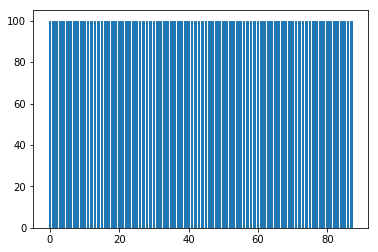

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 901 [0/5702 (0%)]	Loss: 0.000542
Train Epoch: 902 [0/5702 (0%)]	Loss: 0.000159
Train Epoch: 903 [0/5702 (0%)]	Loss: 0.000157
Train Epoch: 904 [0/5702 (0%)]	Loss: 0.000114
Train Epoch: 905 [0/5702 (0%)]	Loss: 0.000165


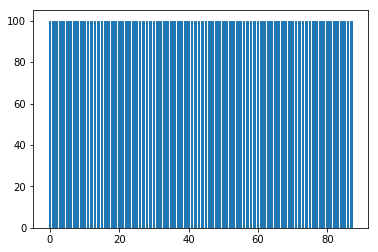

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 906 [0/5702 (0%)]	Loss: 0.000133
Train Epoch: 907 [0/5702 (0%)]	Loss: 0.000164
Train Epoch: 908 [0/5702 (0%)]	Loss: 0.000171
Train Epoch: 909 [0/5702 (0%)]	Loss: 0.000346
Train Epoch: 910 [0/5702 (0%)]	Loss: 0.000126


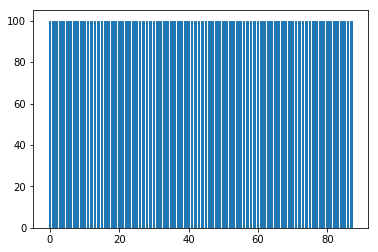

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 911 [0/5702 (0%)]	Loss: 0.000295
Train Epoch: 912 [0/5702 (0%)]	Loss: 0.000102
Train Epoch: 913 [0/5702 (0%)]	Loss: 0.000174
Train Epoch: 914 [0/5702 (0%)]	Loss: 0.000191
Train Epoch: 915 [0/5702 (0%)]	Loss: 0.000161


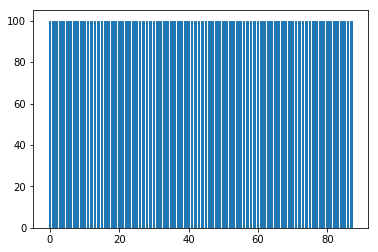

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 916 [0/5702 (0%)]	Loss: 0.000146
Train Epoch: 917 [0/5702 (0%)]	Loss: 0.000120
Train Epoch: 918 [0/5702 (0%)]	Loss: 0.000065
Train Epoch: 919 [0/5702 (0%)]	Loss: 0.000133
Train Epoch: 920 [0/5702 (0%)]	Loss: 0.000099


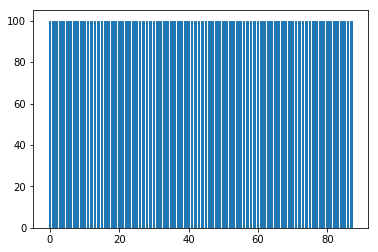

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 921 [0/5702 (0%)]	Loss: 0.000082
Train Epoch: 922 [0/5702 (0%)]	Loss: 0.000257
Train Epoch: 923 [0/5702 (0%)]	Loss: 0.000249
Train Epoch: 924 [0/5702 (0%)]	Loss: 0.000203
Train Epoch: 925 [0/5702 (0%)]	Loss: 0.000140


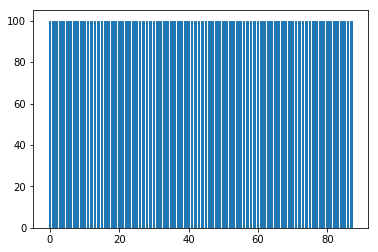

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 926 [0/5702 (0%)]	Loss: 0.000145
Train Epoch: 927 [0/5702 (0%)]	Loss: 0.000170
Train Epoch: 928 [0/5702 (0%)]	Loss: 0.000133
Train Epoch: 929 [0/5702 (0%)]	Loss: 0.000124
Train Epoch: 930 [0/5702 (0%)]	Loss: 0.000084


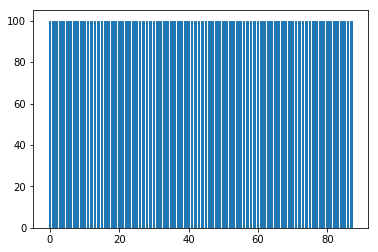

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 931 [0/5702 (0%)]	Loss: 0.000133
Train Epoch: 932 [0/5702 (0%)]	Loss: 0.000291
Train Epoch: 933 [0/5702 (0%)]	Loss: 0.000184
Train Epoch: 934 [0/5702 (0%)]	Loss: 0.000204
Train Epoch: 935 [0/5702 (0%)]	Loss: 0.000177


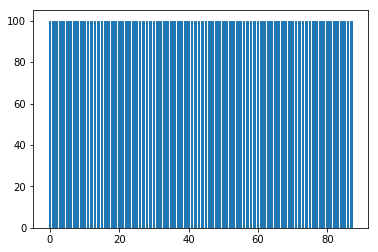

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 936 [0/5702 (0%)]	Loss: 0.000165
Train Epoch: 937 [0/5702 (0%)]	Loss: 0.000132
Train Epoch: 938 [0/5702 (0%)]	Loss: 0.000139
Train Epoch: 939 [0/5702 (0%)]	Loss: 0.000111
Train Epoch: 940 [0/5702 (0%)]	Loss: 0.000154


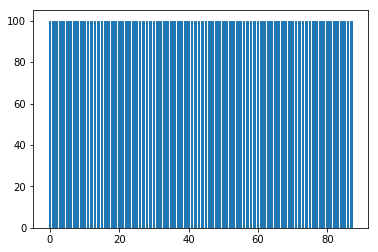

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 941 [0/5702 (0%)]	Loss: 0.000423
Train Epoch: 942 [0/5702 (0%)]	Loss: 0.000102
Train Epoch: 943 [0/5702 (0%)]	Loss: 0.000133
Train Epoch: 944 [0/5702 (0%)]	Loss: 0.000096
Train Epoch: 945 [0/5702 (0%)]	Loss: 0.000263


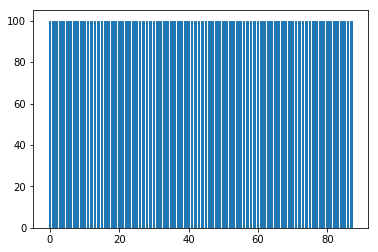

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 946 [0/5702 (0%)]	Loss: 0.000111
Train Epoch: 947 [0/5702 (0%)]	Loss: 0.000104
Train Epoch: 948 [0/5702 (0%)]	Loss: 0.000158
Train Epoch: 949 [0/5702 (0%)]	Loss: 0.000171
Train Epoch: 950 [0/5702 (0%)]	Loss: 0.000155


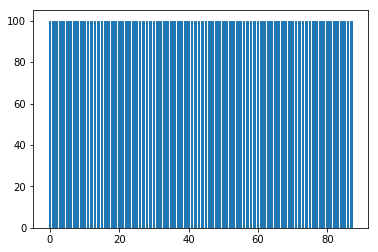

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 951 [0/5702 (0%)]	Loss: 0.000136
Train Epoch: 952 [0/5702 (0%)]	Loss: 0.000144
Train Epoch: 953 [0/5702 (0%)]	Loss: 0.000155
Train Epoch: 954 [0/5702 (0%)]	Loss: 0.000116
Train Epoch: 955 [0/5702 (0%)]	Loss: 0.000119


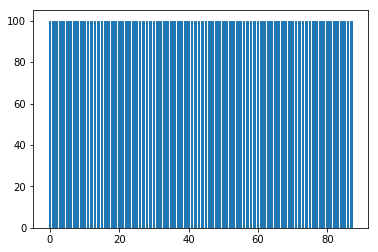

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 956 [0/5702 (0%)]	Loss: 0.000088
Train Epoch: 957 [0/5702 (0%)]	Loss: 0.000091
Train Epoch: 958 [0/5702 (0%)]	Loss: 0.000184
Train Epoch: 959 [0/5702 (0%)]	Loss: 0.000144
Train Epoch: 960 [0/5702 (0%)]	Loss: 0.000089


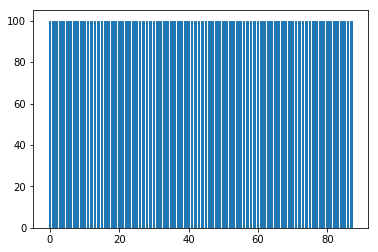

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 961 [0/5702 (0%)]	Loss: 0.000185
Train Epoch: 962 [0/5702 (0%)]	Loss: 0.000231
Train Epoch: 963 [0/5702 (0%)]	Loss: 0.000079
Train Epoch: 964 [0/5702 (0%)]	Loss: 0.000126
Train Epoch: 965 [0/5702 (0%)]	Loss: 0.000339


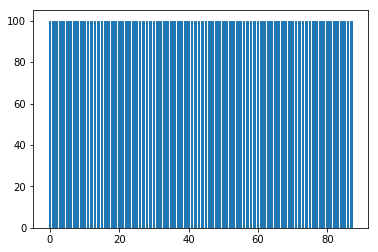

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 966 [0/5702 (0%)]	Loss: 0.000184
Train Epoch: 967 [0/5702 (0%)]	Loss: 0.000070
Train Epoch: 968 [0/5702 (0%)]	Loss: 0.000103
Train Epoch: 969 [0/5702 (0%)]	Loss: 0.000108
Train Epoch: 970 [0/5702 (0%)]	Loss: 0.000098


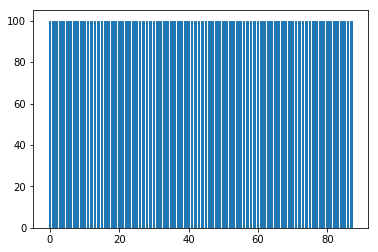

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 971 [0/5702 (0%)]	Loss: 0.000692
Train Epoch: 972 [0/5702 (0%)]	Loss: 0.000217
Train Epoch: 973 [0/5702 (0%)]	Loss: 0.000096
Train Epoch: 974 [0/5702 (0%)]	Loss: 0.000354
Train Epoch: 975 [0/5702 (0%)]	Loss: 0.000139


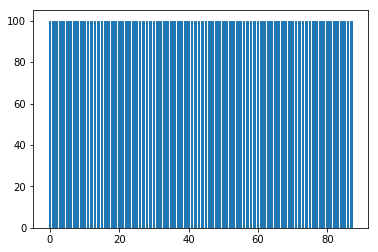

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 976 [0/5702 (0%)]	Loss: 0.000109
Train Epoch: 977 [0/5702 (0%)]	Loss: 0.000161
Train Epoch: 978 [0/5702 (0%)]	Loss: 0.000184
Train Epoch: 979 [0/5702 (0%)]	Loss: 0.000220
Train Epoch: 980 [0/5702 (0%)]	Loss: 0.000232


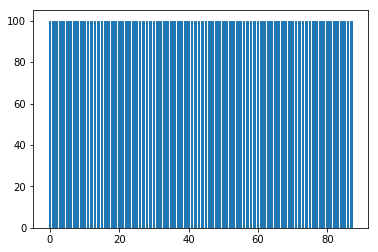

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 981 [0/5702 (0%)]	Loss: 0.000123
Train Epoch: 982 [0/5702 (0%)]	Loss: 0.000160
Train Epoch: 983 [0/5702 (0%)]	Loss: 0.000136
Train Epoch: 984 [0/5702 (0%)]	Loss: 0.000125
Train Epoch: 985 [0/5702 (0%)]	Loss: 0.000537


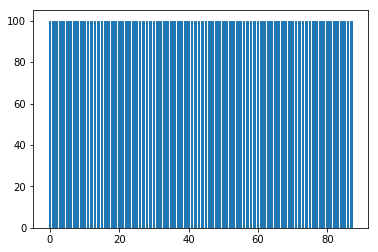

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 986 [0/5702 (0%)]	Loss: 0.000114
Train Epoch: 987 [0/5702 (0%)]	Loss: 0.000085
Train Epoch: 988 [0/5702 (0%)]	Loss: 0.000198
Train Epoch: 989 [0/5702 (0%)]	Loss: 0.000123
Train Epoch: 990 [0/5702 (0%)]	Loss: 0.000126


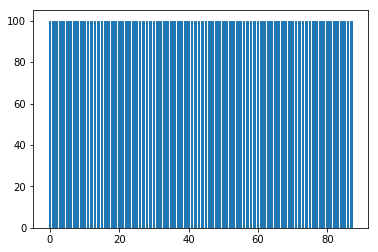

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 991 [0/5702 (0%)]	Loss: 0.000110
Train Epoch: 992 [0/5702 (0%)]	Loss: 0.000135
Train Epoch: 993 [0/5702 (0%)]	Loss: 0.000157
Train Epoch: 994 [0/5702 (0%)]	Loss: 0.000308
Train Epoch: 995 [0/5702 (0%)]	Loss: 0.000092


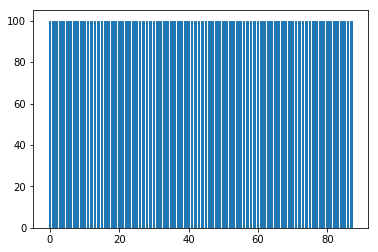

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 996 [0/5702 (0%)]	Loss: 0.000132
Train Epoch: 997 [0/5702 (0%)]	Loss: 0.000087
Train Epoch: 998 [0/5702 (0%)]	Loss: 0.000113
Train Epoch: 999 [0/5702 (0%)]	Loss: 0.000128
Train Epoch: 1000 [0/5702 (0%)]	Loss: 0.000075


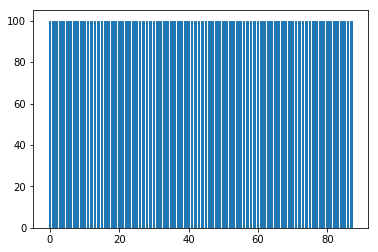

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1001 [0/5702 (0%)]	Loss: 0.000208
Train Epoch: 1002 [0/5702 (0%)]	Loss: 0.000137
Train Epoch: 1003 [0/5702 (0%)]	Loss: 0.000163
Train Epoch: 1004 [0/5702 (0%)]	Loss: 0.000084
Train Epoch: 1005 [0/5702 (0%)]	Loss: 0.000119


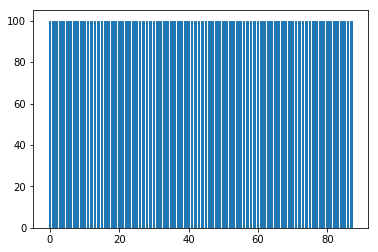

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1006 [0/5702 (0%)]	Loss: 0.000128
Train Epoch: 1007 [0/5702 (0%)]	Loss: 0.000159
Train Epoch: 1008 [0/5702 (0%)]	Loss: 0.000170
Train Epoch: 1009 [0/5702 (0%)]	Loss: 0.000470
Train Epoch: 1010 [0/5702 (0%)]	Loss: 0.001091


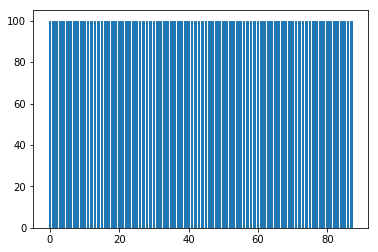

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1011 [0/5702 (0%)]	Loss: 0.000092
Train Epoch: 1012 [0/5702 (0%)]	Loss: 0.000187
Train Epoch: 1013 [0/5702 (0%)]	Loss: 0.000088
Train Epoch: 1014 [0/5702 (0%)]	Loss: 0.000139
Train Epoch: 1015 [0/5702 (0%)]	Loss: 0.000144


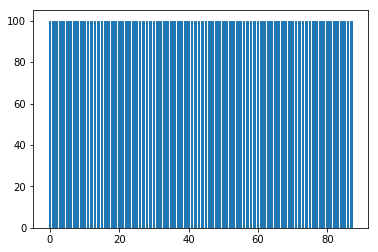

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1016 [0/5702 (0%)]	Loss: 0.000193
Train Epoch: 1017 [0/5702 (0%)]	Loss: 0.000300
Train Epoch: 1018 [0/5702 (0%)]	Loss: 0.000258
Train Epoch: 1019 [0/5702 (0%)]	Loss: 0.000197
Train Epoch: 1020 [0/5702 (0%)]	Loss: 0.000098


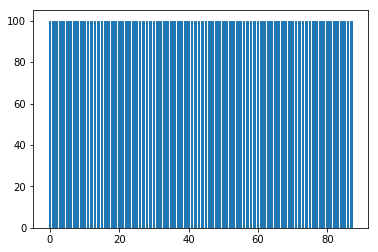

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1021 [0/5702 (0%)]	Loss: 0.000127
Train Epoch: 1022 [0/5702 (0%)]	Loss: 0.000138
Train Epoch: 1023 [0/5702 (0%)]	Loss: 0.000104
Train Epoch: 1024 [0/5702 (0%)]	Loss: 0.000052
Train Epoch: 1025 [0/5702 (0%)]	Loss: 0.000129


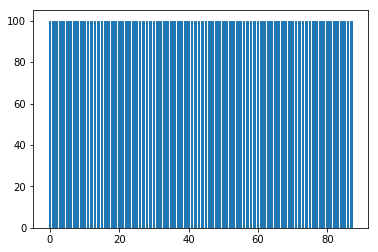

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1026 [0/5702 (0%)]	Loss: 0.000254
Train Epoch: 1027 [0/5702 (0%)]	Loss: 0.000184
Train Epoch: 1028 [0/5702 (0%)]	Loss: 0.000103
Train Epoch: 1029 [0/5702 (0%)]	Loss: 0.000217
Train Epoch: 1030 [0/5702 (0%)]	Loss: 0.000066


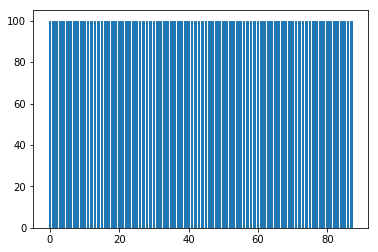

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1031 [0/5702 (0%)]	Loss: 0.000106
Train Epoch: 1032 [0/5702 (0%)]	Loss: 0.000097
Train Epoch: 1033 [0/5702 (0%)]	Loss: 0.000151
Train Epoch: 1034 [0/5702 (0%)]	Loss: 0.000125
Train Epoch: 1035 [0/5702 (0%)]	Loss: 0.000101


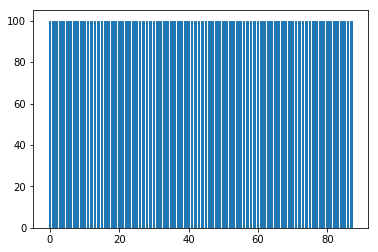

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1036 [0/5702 (0%)]	Loss: 0.000119
Train Epoch: 1037 [0/5702 (0%)]	Loss: 0.000092
Train Epoch: 1038 [0/5702 (0%)]	Loss: 0.000073
Train Epoch: 1039 [0/5702 (0%)]	Loss: 0.000112
Train Epoch: 1040 [0/5702 (0%)]	Loss: 0.000146


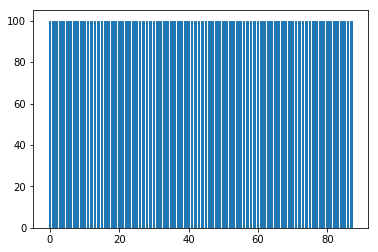

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1041 [0/5702 (0%)]	Loss: 0.000085
Train Epoch: 1042 [0/5702 (0%)]	Loss: 0.000113
Train Epoch: 1043 [0/5702 (0%)]	Loss: 0.000095
Train Epoch: 1044 [0/5702 (0%)]	Loss: 0.000144
Train Epoch: 1045 [0/5702 (0%)]	Loss: 0.000137


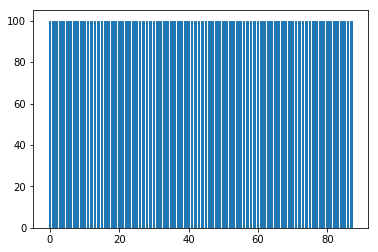

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1046 [0/5702 (0%)]	Loss: 0.000238
Train Epoch: 1047 [0/5702 (0%)]	Loss: 0.000094
Train Epoch: 1048 [0/5702 (0%)]	Loss: 0.000114
Train Epoch: 1049 [0/5702 (0%)]	Loss: 0.000113
Train Epoch: 1050 [0/5702 (0%)]	Loss: 0.000403


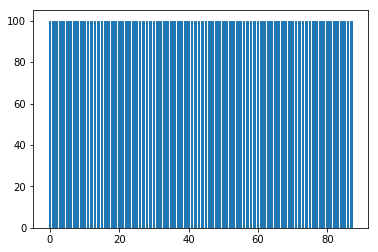

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1051 [0/5702 (0%)]	Loss: 0.000066
Train Epoch: 1052 [0/5702 (0%)]	Loss: 0.000121
Train Epoch: 1053 [0/5702 (0%)]	Loss: 0.000134
Train Epoch: 1054 [0/5702 (0%)]	Loss: 0.000090
Train Epoch: 1055 [0/5702 (0%)]	Loss: 0.000109


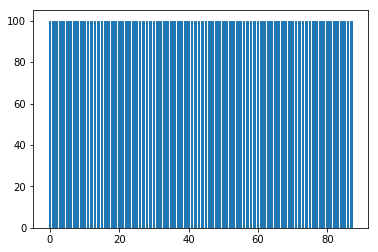

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1056 [0/5702 (0%)]	Loss: 0.000096
Train Epoch: 1057 [0/5702 (0%)]	Loss: 0.000081
Train Epoch: 1058 [0/5702 (0%)]	Loss: 0.000167
Train Epoch: 1059 [0/5702 (0%)]	Loss: 0.000080
Train Epoch: 1060 [0/5702 (0%)]	Loss: 0.000114


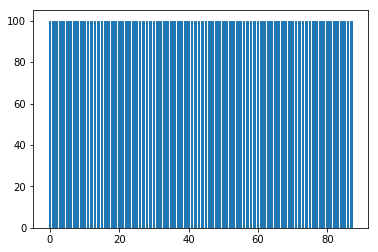

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1061 [0/5702 (0%)]	Loss: 0.000112
Train Epoch: 1062 [0/5702 (0%)]	Loss: 0.000098
Train Epoch: 1063 [0/5702 (0%)]	Loss: 0.000176
Train Epoch: 1064 [0/5702 (0%)]	Loss: 0.000116
Train Epoch: 1065 [0/5702 (0%)]	Loss: 0.000094


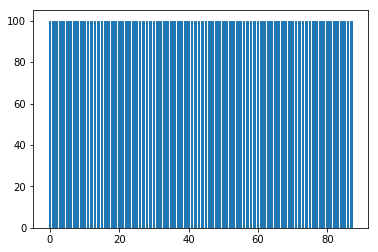

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1066 [0/5702 (0%)]	Loss: 0.000073
Train Epoch: 1067 [0/5702 (0%)]	Loss: 0.000105
Train Epoch: 1068 [0/5702 (0%)]	Loss: 0.000255
Train Epoch: 1069 [0/5702 (0%)]	Loss: 0.000106
Train Epoch: 1070 [0/5702 (0%)]	Loss: 0.000074


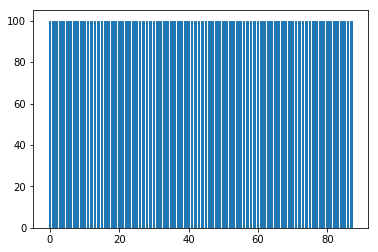

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1071 [0/5702 (0%)]	Loss: 0.000080
Train Epoch: 1072 [0/5702 (0%)]	Loss: 0.000066
Train Epoch: 1073 [0/5702 (0%)]	Loss: 0.000142
Train Epoch: 1074 [0/5702 (0%)]	Loss: 0.000371
Train Epoch: 1075 [0/5702 (0%)]	Loss: 0.000167


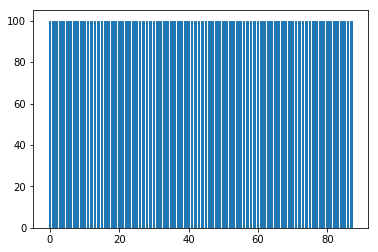

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1076 [0/5702 (0%)]	Loss: 0.000147
Train Epoch: 1077 [0/5702 (0%)]	Loss: 0.000113
Train Epoch: 1078 [0/5702 (0%)]	Loss: 0.000132
Train Epoch: 1079 [0/5702 (0%)]	Loss: 0.000110
Train Epoch: 1080 [0/5702 (0%)]	Loss: 0.000160


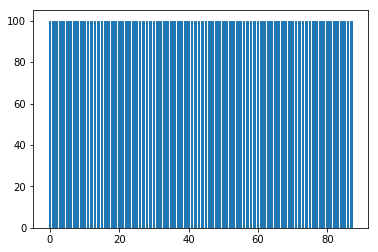

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1081 [0/5702 (0%)]	Loss: 0.000152
Train Epoch: 1082 [0/5702 (0%)]	Loss: 0.000093
Train Epoch: 1083 [0/5702 (0%)]	Loss: 0.000159
Train Epoch: 1084 [0/5702 (0%)]	Loss: 0.000099
Train Epoch: 1085 [0/5702 (0%)]	Loss: 0.000188


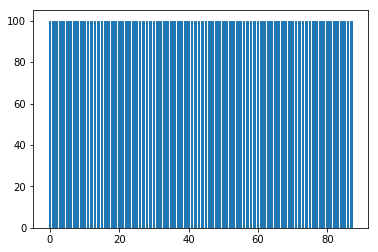

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1086 [0/5702 (0%)]	Loss: 0.000092
Train Epoch: 1087 [0/5702 (0%)]	Loss: 0.000096
Train Epoch: 1088 [0/5702 (0%)]	Loss: 0.000105
Train Epoch: 1089 [0/5702 (0%)]	Loss: 0.000094
Train Epoch: 1090 [0/5702 (0%)]	Loss: 0.000112


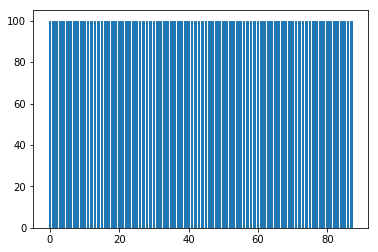

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1091 [0/5702 (0%)]	Loss: 0.000150
Train Epoch: 1092 [0/5702 (0%)]	Loss: 0.000067
Train Epoch: 1093 [0/5702 (0%)]	Loss: 0.000110
Train Epoch: 1094 [0/5702 (0%)]	Loss: 0.000101
Train Epoch: 1095 [0/5702 (0%)]	Loss: 0.000076


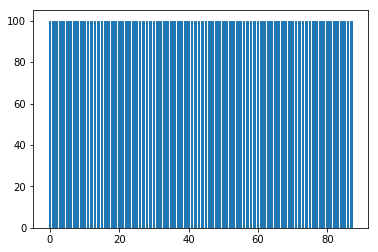

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1096 [0/5702 (0%)]	Loss: 0.000128
Train Epoch: 1097 [0/5702 (0%)]	Loss: 0.000097
Train Epoch: 1098 [0/5702 (0%)]	Loss: 0.000168
Train Epoch: 1099 [0/5702 (0%)]	Loss: 0.000142
Train Epoch: 1100 [0/5702 (0%)]	Loss: 0.000102


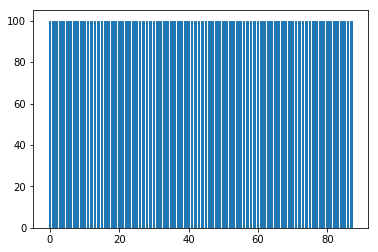

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1101 [0/5702 (0%)]	Loss: 0.000165
Train Epoch: 1102 [0/5702 (0%)]	Loss: 0.000140
Train Epoch: 1103 [0/5702 (0%)]	Loss: 0.000089
Train Epoch: 1104 [0/5702 (0%)]	Loss: 0.000167
Train Epoch: 1105 [0/5702 (0%)]	Loss: 0.000077


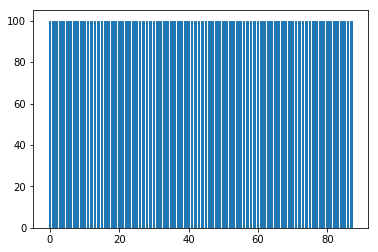

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1106 [0/5702 (0%)]	Loss: 0.000069
Train Epoch: 1107 [0/5702 (0%)]	Loss: 0.000047
Train Epoch: 1108 [0/5702 (0%)]	Loss: 0.000174
Train Epoch: 1109 [0/5702 (0%)]	Loss: 0.000147
Train Epoch: 1110 [0/5702 (0%)]	Loss: 0.000167


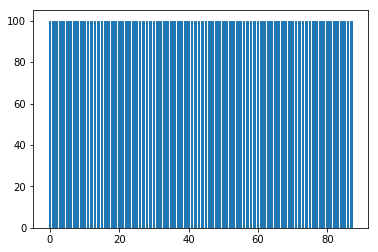

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1111 [0/5702 (0%)]	Loss: 0.000125
Train Epoch: 1112 [0/5702 (0%)]	Loss: 0.000107
Train Epoch: 1113 [0/5702 (0%)]	Loss: 0.000173
Train Epoch: 1114 [0/5702 (0%)]	Loss: 0.000157
Train Epoch: 1115 [0/5702 (0%)]	Loss: 0.000080


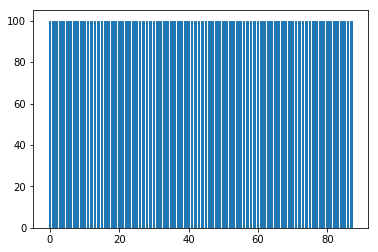

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1116 [0/5702 (0%)]	Loss: 0.000103
Train Epoch: 1117 [0/5702 (0%)]	Loss: 0.000192
Train Epoch: 1118 [0/5702 (0%)]	Loss: 0.000101
Train Epoch: 1119 [0/5702 (0%)]	Loss: 0.000128
Train Epoch: 1120 [0/5702 (0%)]	Loss: 0.000083


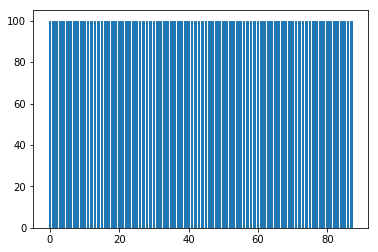

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1121 [0/5702 (0%)]	Loss: 0.000101
Train Epoch: 1122 [0/5702 (0%)]	Loss: 0.000130
Train Epoch: 1123 [0/5702 (0%)]	Loss: 0.000084
Train Epoch: 1124 [0/5702 (0%)]	Loss: 0.000118
Train Epoch: 1125 [0/5702 (0%)]	Loss: 0.000054


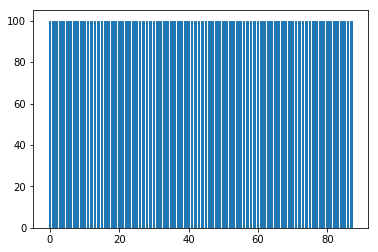

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1126 [0/5702 (0%)]	Loss: 0.000128
Train Epoch: 1127 [0/5702 (0%)]	Loss: 0.000107
Train Epoch: 1128 [0/5702 (0%)]	Loss: 0.000047
Train Epoch: 1129 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1130 [0/5702 (0%)]	Loss: 0.000147


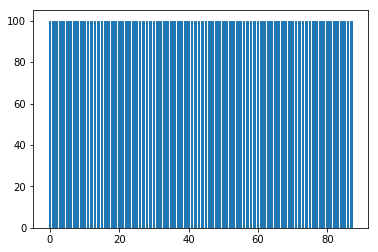

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1131 [0/5702 (0%)]	Loss: 0.000111
Train Epoch: 1132 [0/5702 (0%)]	Loss: 0.000093
Train Epoch: 1133 [0/5702 (0%)]	Loss: 0.000085
Train Epoch: 1134 [0/5702 (0%)]	Loss: 0.000098
Train Epoch: 1135 [0/5702 (0%)]	Loss: 0.000074


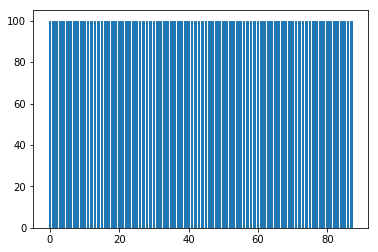

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1136 [0/5702 (0%)]	Loss: 0.000159
Train Epoch: 1137 [0/5702 (0%)]	Loss: 0.000119
Train Epoch: 1138 [0/5702 (0%)]	Loss: 0.000060
Train Epoch: 1139 [0/5702 (0%)]	Loss: 0.000090
Train Epoch: 1140 [0/5702 (0%)]	Loss: 0.000083


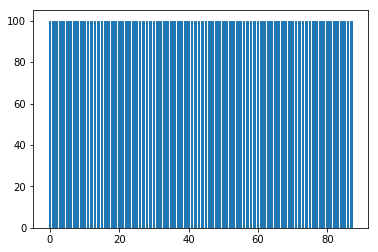

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1141 [0/5702 (0%)]	Loss: 0.000096
Train Epoch: 1142 [0/5702 (0%)]	Loss: 0.000093
Train Epoch: 1143 [0/5702 (0%)]	Loss: 0.000156
Train Epoch: 1144 [0/5702 (0%)]	Loss: 0.000132
Train Epoch: 1145 [0/5702 (0%)]	Loss: 0.000187


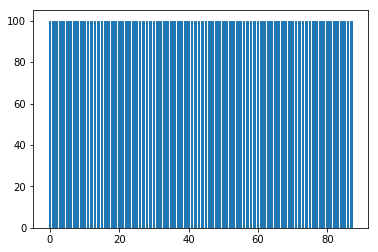

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1146 [0/5702 (0%)]	Loss: 0.000103
Train Epoch: 1147 [0/5702 (0%)]	Loss: 0.000123
Train Epoch: 1148 [0/5702 (0%)]	Loss: 0.000104
Train Epoch: 1149 [0/5702 (0%)]	Loss: 0.000088
Train Epoch: 1150 [0/5702 (0%)]	Loss: 0.000119


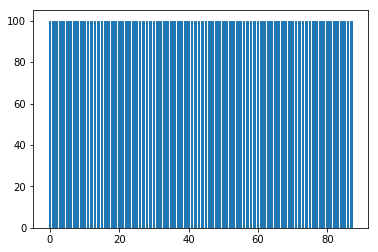

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1151 [0/5702 (0%)]	Loss: 0.000079
Train Epoch: 1152 [0/5702 (0%)]	Loss: 0.000142
Train Epoch: 1153 [0/5702 (0%)]	Loss: 0.000120
Train Epoch: 1154 [0/5702 (0%)]	Loss: 0.000103
Train Epoch: 1155 [0/5702 (0%)]	Loss: 0.000176


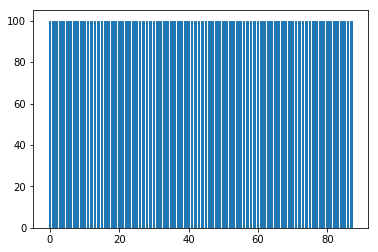

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1156 [0/5702 (0%)]	Loss: 0.000083
Train Epoch: 1157 [0/5702 (0%)]	Loss: 0.000084
Train Epoch: 1158 [0/5702 (0%)]	Loss: 0.000079
Train Epoch: 1159 [0/5702 (0%)]	Loss: 0.000139
Train Epoch: 1160 [0/5702 (0%)]	Loss: 0.000064


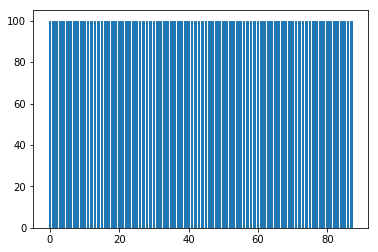

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1161 [0/5702 (0%)]	Loss: 0.000084
Train Epoch: 1162 [0/5702 (0%)]	Loss: 0.000092
Train Epoch: 1163 [0/5702 (0%)]	Loss: 0.000104
Train Epoch: 1164 [0/5702 (0%)]	Loss: 0.000061
Train Epoch: 1165 [0/5702 (0%)]	Loss: 0.000090


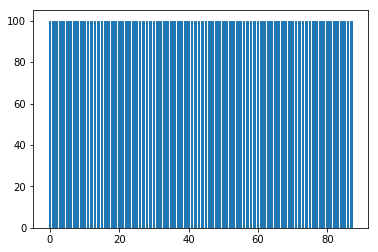

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1166 [0/5702 (0%)]	Loss: 0.000108
Train Epoch: 1167 [0/5702 (0%)]	Loss: 0.000091
Train Epoch: 1168 [0/5702 (0%)]	Loss: 0.000088
Train Epoch: 1169 [0/5702 (0%)]	Loss: 0.000096
Train Epoch: 1170 [0/5702 (0%)]	Loss: 0.001219


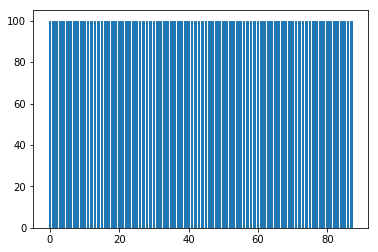

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1171 [0/5702 (0%)]	Loss: 0.000204
Train Epoch: 1172 [0/5702 (0%)]	Loss: 0.000074
Train Epoch: 1173 [0/5702 (0%)]	Loss: 0.000064
Train Epoch: 1174 [0/5702 (0%)]	Loss: 0.000075
Train Epoch: 1175 [0/5702 (0%)]	Loss: 0.000137


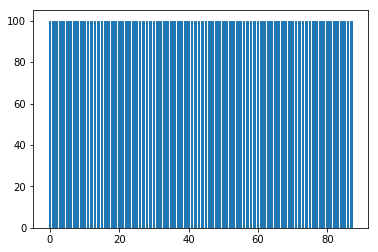

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1176 [0/5702 (0%)]	Loss: 0.000168
Train Epoch: 1177 [0/5702 (0%)]	Loss: 0.000041
Train Epoch: 1178 [0/5702 (0%)]	Loss: 0.000079
Train Epoch: 1179 [0/5702 (0%)]	Loss: 0.000075
Train Epoch: 1180 [0/5702 (0%)]	Loss: 0.000139


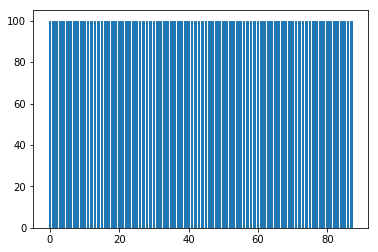

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1181 [0/5702 (0%)]	Loss: 0.000108
Train Epoch: 1182 [0/5702 (0%)]	Loss: 0.000131
Train Epoch: 1183 [0/5702 (0%)]	Loss: 0.000137
Train Epoch: 1184 [0/5702 (0%)]	Loss: 0.000124
Train Epoch: 1185 [0/5702 (0%)]	Loss: 0.000158


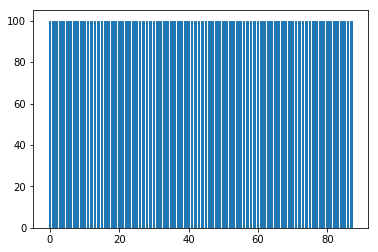

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1186 [0/5702 (0%)]	Loss: 0.000126
Train Epoch: 1187 [0/5702 (0%)]	Loss: 0.000081
Train Epoch: 1188 [0/5702 (0%)]	Loss: 0.000079
Train Epoch: 1189 [0/5702 (0%)]	Loss: 0.000099
Train Epoch: 1190 [0/5702 (0%)]	Loss: 0.000125


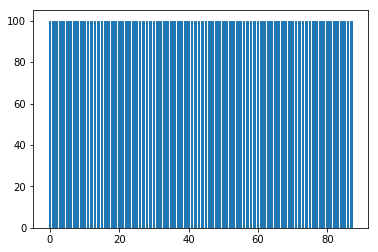

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1191 [0/5702 (0%)]	Loss: 0.000048
Train Epoch: 1192 [0/5702 (0%)]	Loss: 0.000091
Train Epoch: 1193 [0/5702 (0%)]	Loss: 0.000130
Train Epoch: 1194 [0/5702 (0%)]	Loss: 0.000140
Train Epoch: 1195 [0/5702 (0%)]	Loss: 0.000051


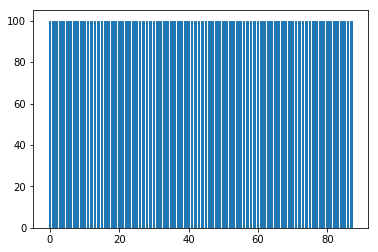

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1196 [0/5702 (0%)]	Loss: 0.000099
Train Epoch: 1197 [0/5702 (0%)]	Loss: 0.000074
Train Epoch: 1198 [0/5702 (0%)]	Loss: 0.000091
Train Epoch: 1199 [0/5702 (0%)]	Loss: 0.000096
Train Epoch: 1200 [0/5702 (0%)]	Loss: 0.000062


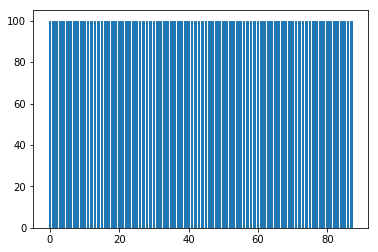

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1201 [0/5702 (0%)]	Loss: 0.000077
Train Epoch: 1202 [0/5702 (0%)]	Loss: 0.000111
Train Epoch: 1203 [0/5702 (0%)]	Loss: 0.000110
Train Epoch: 1204 [0/5702 (0%)]	Loss: 0.000126
Train Epoch: 1205 [0/5702 (0%)]	Loss: 0.000076


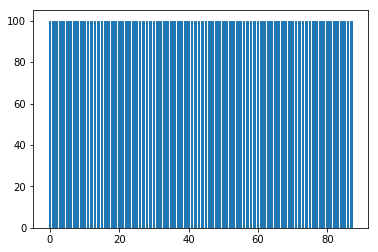

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1206 [0/5702 (0%)]	Loss: 0.000148
Train Epoch: 1207 [0/5702 (0%)]	Loss: 0.000079
Train Epoch: 1208 [0/5702 (0%)]	Loss: 0.000092
Train Epoch: 1209 [0/5702 (0%)]	Loss: 0.000127
Train Epoch: 1210 [0/5702 (0%)]	Loss: 0.000081


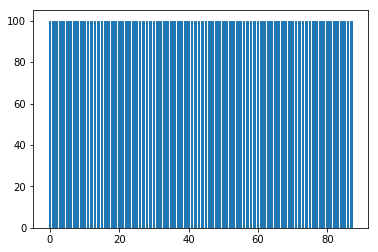

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1211 [0/5702 (0%)]	Loss: 0.000097
Train Epoch: 1212 [0/5702 (0%)]	Loss: 0.000056
Train Epoch: 1213 [0/5702 (0%)]	Loss: 0.000167
Train Epoch: 1214 [0/5702 (0%)]	Loss: 0.000103
Train Epoch: 1215 [0/5702 (0%)]	Loss: 0.000101


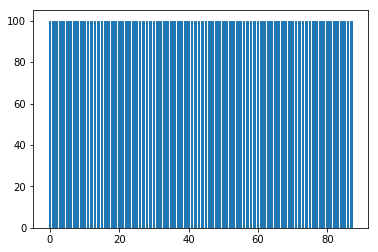

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1216 [0/5702 (0%)]	Loss: 0.000065
Train Epoch: 1217 [0/5702 (0%)]	Loss: 0.000101
Train Epoch: 1218 [0/5702 (0%)]	Loss: 0.000127
Train Epoch: 1219 [0/5702 (0%)]	Loss: 0.000096
Train Epoch: 1220 [0/5702 (0%)]	Loss: 0.000070


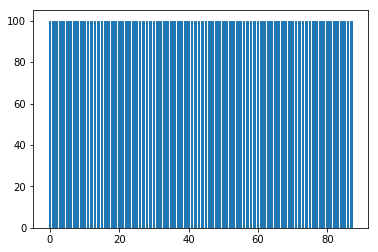

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1221 [0/5702 (0%)]	Loss: 0.000091
Train Epoch: 1222 [0/5702 (0%)]	Loss: 0.000076
Train Epoch: 1223 [0/5702 (0%)]	Loss: 0.000081
Train Epoch: 1224 [0/5702 (0%)]	Loss: 0.000095
Train Epoch: 1225 [0/5702 (0%)]	Loss: 0.000158


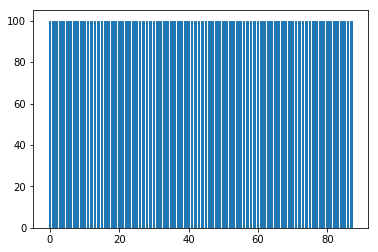

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1226 [0/5702 (0%)]	Loss: 0.000131
Train Epoch: 1227 [0/5702 (0%)]	Loss: 0.000093
Train Epoch: 1228 [0/5702 (0%)]	Loss: 0.000059
Train Epoch: 1229 [0/5702 (0%)]	Loss: 0.000148
Train Epoch: 1230 [0/5702 (0%)]	Loss: 0.000141


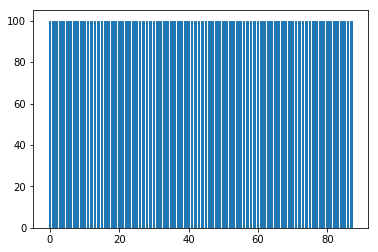

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1231 [0/5702 (0%)]	Loss: 0.000242
Train Epoch: 1232 [0/5702 (0%)]	Loss: 0.000082
Train Epoch: 1233 [0/5702 (0%)]	Loss: 0.000077
Train Epoch: 1234 [0/5702 (0%)]	Loss: 0.000088
Train Epoch: 1235 [0/5702 (0%)]	Loss: 0.000117


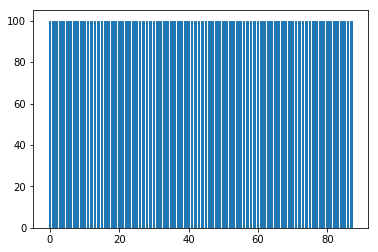

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1236 [0/5702 (0%)]	Loss: 0.000939
Train Epoch: 1237 [0/5702 (0%)]	Loss: 0.000093
Train Epoch: 1238 [0/5702 (0%)]	Loss: 0.000223
Train Epoch: 1239 [0/5702 (0%)]	Loss: 0.000137
Train Epoch: 1240 [0/5702 (0%)]	Loss: 0.000115


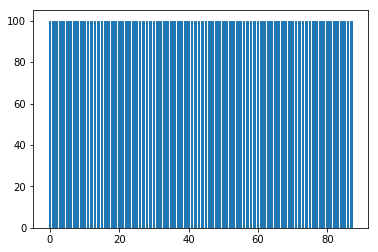

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1241 [0/5702 (0%)]	Loss: 0.000149
Train Epoch: 1242 [0/5702 (0%)]	Loss: 0.000108
Train Epoch: 1243 [0/5702 (0%)]	Loss: 0.000059
Train Epoch: 1244 [0/5702 (0%)]	Loss: 0.000157
Train Epoch: 1245 [0/5702 (0%)]	Loss: 0.000075


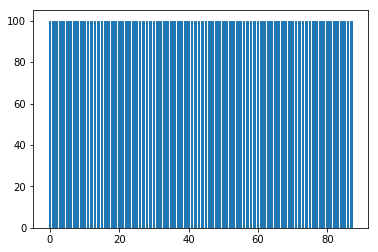

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1246 [0/5702 (0%)]	Loss: 0.000197
Train Epoch: 1247 [0/5702 (0%)]	Loss: 0.000144
Train Epoch: 1248 [0/5702 (0%)]	Loss: 0.000055
Train Epoch: 1249 [0/5702 (0%)]	Loss: 0.000083
Train Epoch: 1250 [0/5702 (0%)]	Loss: 0.000205


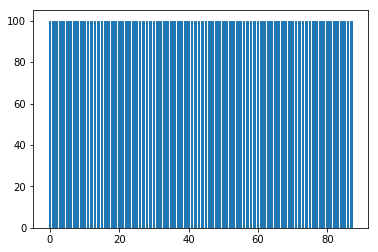

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1251 [0/5702 (0%)]	Loss: 0.000054
Train Epoch: 1252 [0/5702 (0%)]	Loss: 0.000093
Train Epoch: 1253 [0/5702 (0%)]	Loss: 0.000071
Train Epoch: 1254 [0/5702 (0%)]	Loss: 0.000092
Train Epoch: 1255 [0/5702 (0%)]	Loss: 0.000116


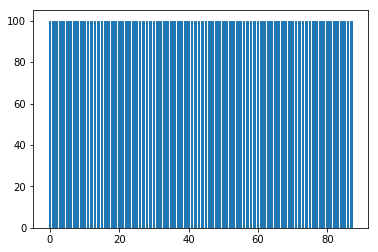

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1256 [0/5702 (0%)]	Loss: 0.000135
Train Epoch: 1257 [0/5702 (0%)]	Loss: 0.000143
Train Epoch: 1258 [0/5702 (0%)]	Loss: 0.000059
Train Epoch: 1259 [0/5702 (0%)]	Loss: 0.000191
Train Epoch: 1260 [0/5702 (0%)]	Loss: 0.000093


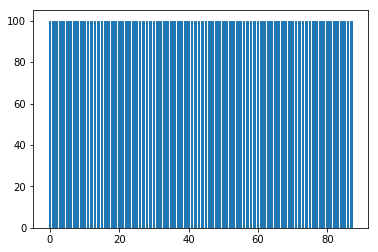

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1261 [0/5702 (0%)]	Loss: 0.000065
Train Epoch: 1262 [0/5702 (0%)]	Loss: 0.000089
Train Epoch: 1263 [0/5702 (0%)]	Loss: 0.000103
Train Epoch: 1264 [0/5702 (0%)]	Loss: 0.000064
Train Epoch: 1265 [0/5702 (0%)]	Loss: 0.000048


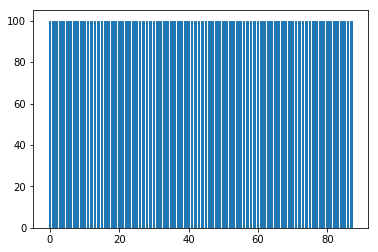

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1266 [0/5702 (0%)]	Loss: 0.000074
Train Epoch: 1267 [0/5702 (0%)]	Loss: 0.000128
Train Epoch: 1268 [0/5702 (0%)]	Loss: 0.000061
Train Epoch: 1269 [0/5702 (0%)]	Loss: 0.000343
Train Epoch: 1270 [0/5702 (0%)]	Loss: 0.000053


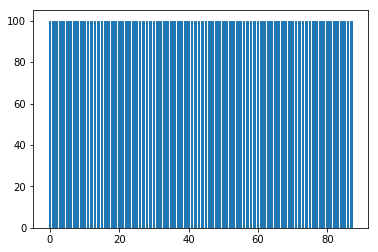

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1271 [0/5702 (0%)]	Loss: 0.000153
Train Epoch: 1272 [0/5702 (0%)]	Loss: 0.000244
Train Epoch: 1273 [0/5702 (0%)]	Loss: 0.000088
Train Epoch: 1274 [0/5702 (0%)]	Loss: 0.000160
Train Epoch: 1275 [0/5702 (0%)]	Loss: 0.000091


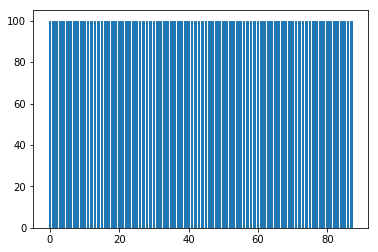

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1276 [0/5702 (0%)]	Loss: 0.000044
Train Epoch: 1277 [0/5702 (0%)]	Loss: 0.000116
Train Epoch: 1278 [0/5702 (0%)]	Loss: 0.000150
Train Epoch: 1279 [0/5702 (0%)]	Loss: 0.000133
Train Epoch: 1280 [0/5702 (0%)]	Loss: 0.000135


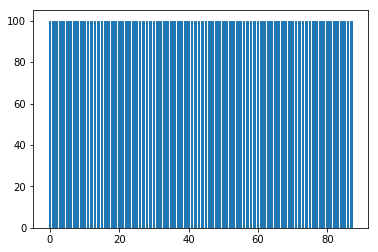

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1281 [0/5702 (0%)]	Loss: 0.000115
Train Epoch: 1282 [0/5702 (0%)]	Loss: 0.000108
Train Epoch: 1283 [0/5702 (0%)]	Loss: 0.000066
Train Epoch: 1284 [0/5702 (0%)]	Loss: 0.000053
Train Epoch: 1285 [0/5702 (0%)]	Loss: 0.000051


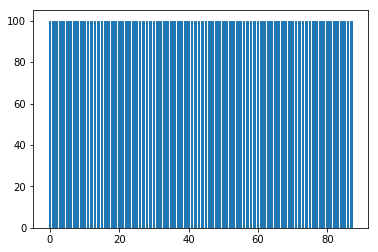

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1286 [0/5702 (0%)]	Loss: 0.000070
Train Epoch: 1287 [0/5702 (0%)]	Loss: 0.000106
Train Epoch: 1288 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1289 [0/5702 (0%)]	Loss: 0.000081
Train Epoch: 1290 [0/5702 (0%)]	Loss: 0.000074


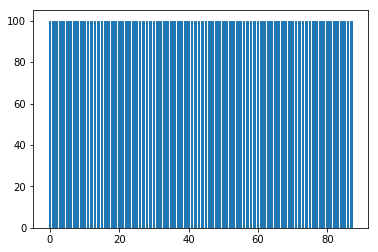

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1291 [0/5702 (0%)]	Loss: 0.000063
Train Epoch: 1292 [0/5702 (0%)]	Loss: 0.000080
Train Epoch: 1293 [0/5702 (0%)]	Loss: 0.000093
Train Epoch: 1294 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1295 [0/5702 (0%)]	Loss: 0.000127


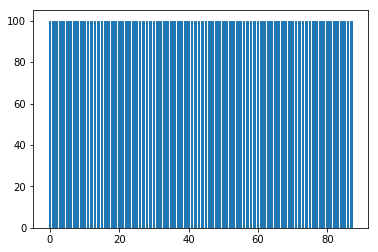

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1296 [0/5702 (0%)]	Loss: 0.000084
Train Epoch: 1297 [0/5702 (0%)]	Loss: 0.000125
Train Epoch: 1298 [0/5702 (0%)]	Loss: 0.000072
Train Epoch: 1299 [0/5702 (0%)]	Loss: 0.000101
Train Epoch: 1300 [0/5702 (0%)]	Loss: 0.000032


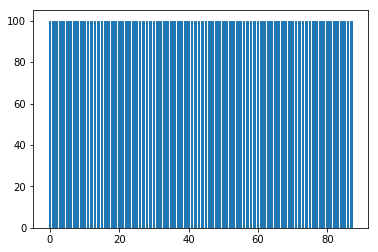

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1301 [0/5702 (0%)]	Loss: 0.000080
Train Epoch: 1302 [0/5702 (0%)]	Loss: 0.000050
Train Epoch: 1303 [0/5702 (0%)]	Loss: 0.000169
Train Epoch: 1304 [0/5702 (0%)]	Loss: 0.000059
Train Epoch: 1305 [0/5702 (0%)]	Loss: 0.000121


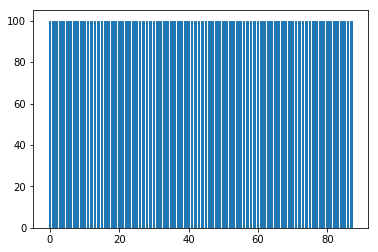

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1306 [0/5702 (0%)]	Loss: 0.000153
Train Epoch: 1307 [0/5702 (0%)]	Loss: 0.000052
Train Epoch: 1308 [0/5702 (0%)]	Loss: 0.000083
Train Epoch: 1309 [0/5702 (0%)]	Loss: 0.000896
Train Epoch: 1310 [0/5702 (0%)]	Loss: 0.000101


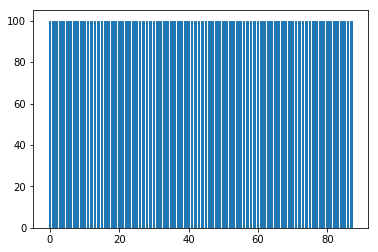

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1311 [0/5702 (0%)]	Loss: 0.000058
Train Epoch: 1312 [0/5702 (0%)]	Loss: 0.000061
Train Epoch: 1313 [0/5702 (0%)]	Loss: 0.000113
Train Epoch: 1314 [0/5702 (0%)]	Loss: 0.000083
Train Epoch: 1315 [0/5702 (0%)]	Loss: 0.000096


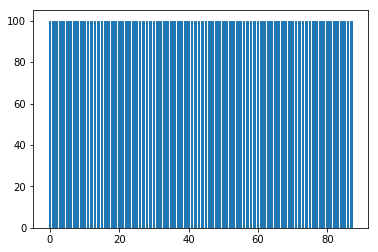

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1316 [0/5702 (0%)]	Loss: 0.000150
Train Epoch: 1317 [0/5702 (0%)]	Loss: 0.000104
Train Epoch: 1318 [0/5702 (0%)]	Loss: 0.000038
Train Epoch: 1319 [0/5702 (0%)]	Loss: 0.000863
Train Epoch: 1320 [0/5702 (0%)]	Loss: 0.000095


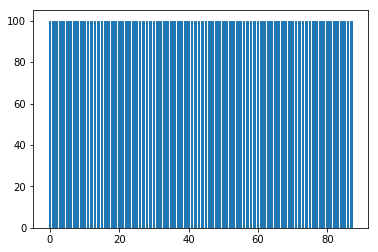

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1321 [0/5702 (0%)]	Loss: 0.000103
Train Epoch: 1322 [0/5702 (0%)]	Loss: 0.000121
Train Epoch: 1323 [0/5702 (0%)]	Loss: 0.000132
Train Epoch: 1324 [0/5702 (0%)]	Loss: 0.000105
Train Epoch: 1325 [0/5702 (0%)]	Loss: 0.000089


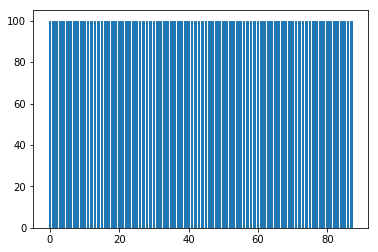

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1326 [0/5702 (0%)]	Loss: 0.000125
Train Epoch: 1327 [0/5702 (0%)]	Loss: 0.000085
Train Epoch: 1328 [0/5702 (0%)]	Loss: 0.000086
Train Epoch: 1329 [0/5702 (0%)]	Loss: 0.000089
Train Epoch: 1330 [0/5702 (0%)]	Loss: 0.000052


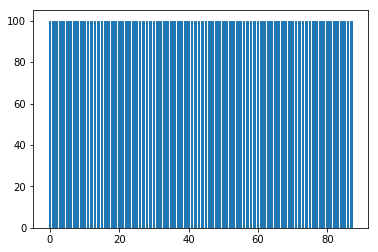

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1331 [0/5702 (0%)]	Loss: 0.000083
Train Epoch: 1332 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1333 [0/5702 (0%)]	Loss: 0.000081
Train Epoch: 1334 [0/5702 (0%)]	Loss: 0.000075
Train Epoch: 1335 [0/5702 (0%)]	Loss: 0.000135


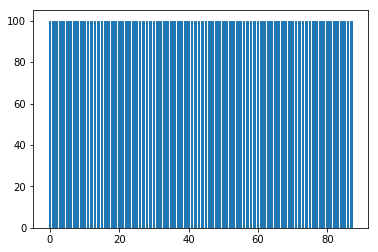

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1336 [0/5702 (0%)]	Loss: 0.000890
Train Epoch: 1337 [0/5702 (0%)]	Loss: 0.000163
Train Epoch: 1338 [0/5702 (0%)]	Loss: 0.000063
Train Epoch: 1339 [0/5702 (0%)]	Loss: 0.000074
Train Epoch: 1340 [0/5702 (0%)]	Loss: 0.000084


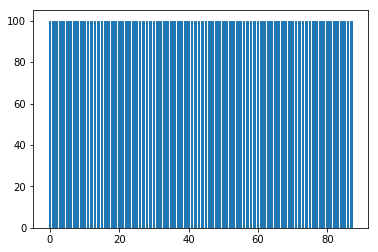

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1341 [0/5702 (0%)]	Loss: 0.000051
Train Epoch: 1342 [0/5702 (0%)]	Loss: 0.000043
Train Epoch: 1343 [0/5702 (0%)]	Loss: 0.000059
Train Epoch: 1344 [0/5702 (0%)]	Loss: 0.000044
Train Epoch: 1345 [0/5702 (0%)]	Loss: 0.000058


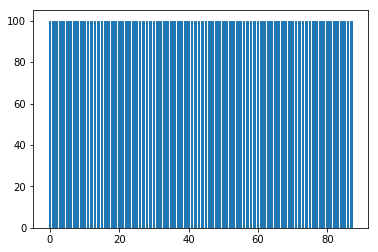

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1346 [0/5702 (0%)]	Loss: 0.000073
Train Epoch: 1347 [0/5702 (0%)]	Loss: 0.000141
Train Epoch: 1348 [0/5702 (0%)]	Loss: 0.000299
Train Epoch: 1349 [0/5702 (0%)]	Loss: 0.000123
Train Epoch: 1350 [0/5702 (0%)]	Loss: 0.000132


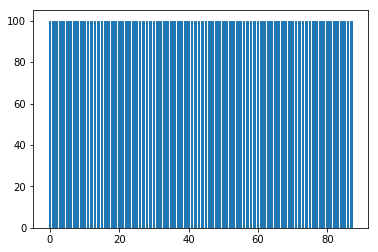

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1351 [0/5702 (0%)]	Loss: 0.000084
Train Epoch: 1352 [0/5702 (0%)]	Loss: 0.000091
Train Epoch: 1353 [0/5702 (0%)]	Loss: 0.000074
Train Epoch: 1354 [0/5702 (0%)]	Loss: 0.000158
Train Epoch: 1355 [0/5702 (0%)]	Loss: 0.000142


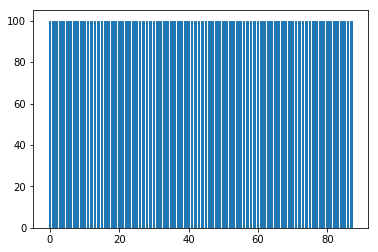

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1356 [0/5702 (0%)]	Loss: 0.000086
Train Epoch: 1357 [0/5702 (0%)]	Loss: 0.000106
Train Epoch: 1358 [0/5702 (0%)]	Loss: 0.000106
Train Epoch: 1359 [0/5702 (0%)]	Loss: 0.000087
Train Epoch: 1360 [0/5702 (0%)]	Loss: 0.000066


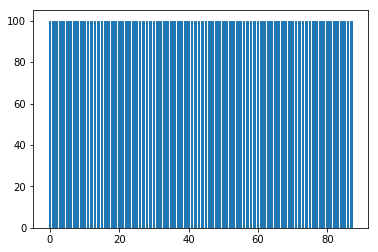

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1361 [0/5702 (0%)]	Loss: 0.000172
Train Epoch: 1362 [0/5702 (0%)]	Loss: 0.000062
Train Epoch: 1363 [0/5702 (0%)]	Loss: 0.000083
Train Epoch: 1364 [0/5702 (0%)]	Loss: 0.000106
Train Epoch: 1365 [0/5702 (0%)]	Loss: 0.000095


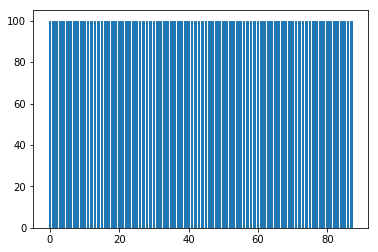

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1366 [0/5702 (0%)]	Loss: 0.000038
Train Epoch: 1367 [0/5702 (0%)]	Loss: 0.000132
Train Epoch: 1368 [0/5702 (0%)]	Loss: 0.000048
Train Epoch: 1369 [0/5702 (0%)]	Loss: 0.000080
Train Epoch: 1370 [0/5702 (0%)]	Loss: 0.000073


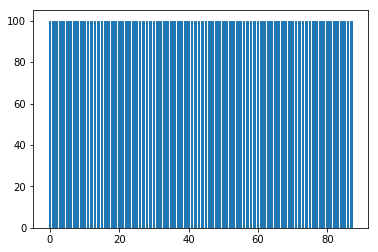

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1371 [0/5702 (0%)]	Loss: 0.000062
Train Epoch: 1372 [0/5702 (0%)]	Loss: 0.000143
Train Epoch: 1373 [0/5702 (0%)]	Loss: 0.000075
Train Epoch: 1374 [0/5702 (0%)]	Loss: 0.000053
Train Epoch: 1375 [0/5702 (0%)]	Loss: 0.000061


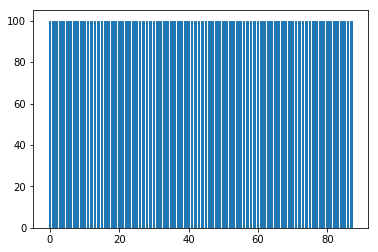

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1376 [0/5702 (0%)]	Loss: 0.000087
Train Epoch: 1377 [0/5702 (0%)]	Loss: 0.000074
Train Epoch: 1378 [0/5702 (0%)]	Loss: 0.000059
Train Epoch: 1379 [0/5702 (0%)]	Loss: 0.000101
Train Epoch: 1380 [0/5702 (0%)]	Loss: 0.000075


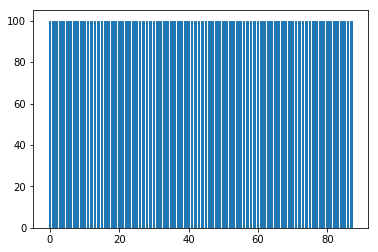

300
0

Test set: Average loss: 0.0001, Accuracy: 300/300 (100%)

Train Epoch: 1381 [0/5702 (0%)]	Loss: 0.000130
Train Epoch: 1382 [0/5702 (0%)]	Loss: 0.000094
Train Epoch: 1383 [0/5702 (0%)]	Loss: 0.000055
Train Epoch: 1384 [0/5702 (0%)]	Loss: 0.000094
Train Epoch: 1385 [0/5702 (0%)]	Loss: 0.000076


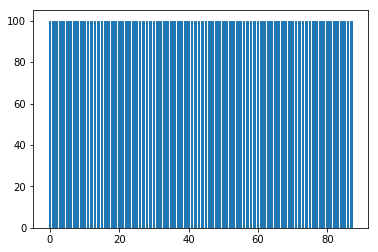

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1386 [0/5702 (0%)]	Loss: 0.000170
Train Epoch: 1387 [0/5702 (0%)]	Loss: 0.000072
Train Epoch: 1388 [0/5702 (0%)]	Loss: 0.000070
Train Epoch: 1389 [0/5702 (0%)]	Loss: 0.000063
Train Epoch: 1390 [0/5702 (0%)]	Loss: 0.000146


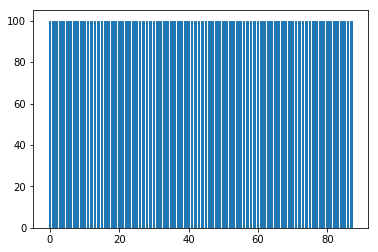

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1391 [0/5702 (0%)]	Loss: 0.000134
Train Epoch: 1392 [0/5702 (0%)]	Loss: 0.000042
Train Epoch: 1393 [0/5702 (0%)]	Loss: 0.000244
Train Epoch: 1394 [0/5702 (0%)]	Loss: 0.000121
Train Epoch: 1395 [0/5702 (0%)]	Loss: 0.000126


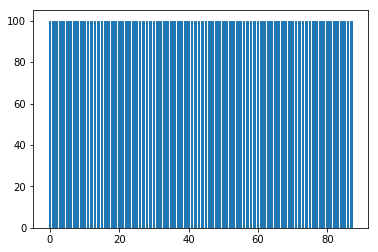

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1396 [0/5702 (0%)]	Loss: 0.000101
Train Epoch: 1397 [0/5702 (0%)]	Loss: 0.000070
Train Epoch: 1398 [0/5702 (0%)]	Loss: 0.000117
Train Epoch: 1399 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1400 [0/5702 (0%)]	Loss: 0.000041


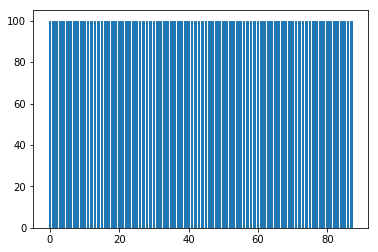

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1401 [0/5702 (0%)]	Loss: 0.000099
Train Epoch: 1402 [0/5702 (0%)]	Loss: 0.000092
Train Epoch: 1403 [0/5702 (0%)]	Loss: 0.000079
Train Epoch: 1404 [0/5702 (0%)]	Loss: 0.000086
Train Epoch: 1405 [0/5702 (0%)]	Loss: 0.000105


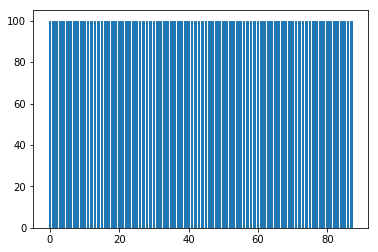

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1406 [0/5702 (0%)]	Loss: 0.000112
Train Epoch: 1407 [0/5702 (0%)]	Loss: 0.000120
Train Epoch: 1408 [0/5702 (0%)]	Loss: 0.000068
Train Epoch: 1409 [0/5702 (0%)]	Loss: 0.000081
Train Epoch: 1410 [0/5702 (0%)]	Loss: 0.000123


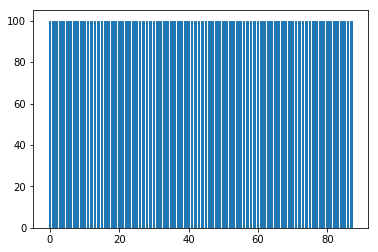

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1411 [0/5702 (0%)]	Loss: 0.000101
Train Epoch: 1412 [0/5702 (0%)]	Loss: 0.000063
Train Epoch: 1413 [0/5702 (0%)]	Loss: 0.000302
Train Epoch: 1414 [0/5702 (0%)]	Loss: 0.000065
Train Epoch: 1415 [0/5702 (0%)]	Loss: 0.000065


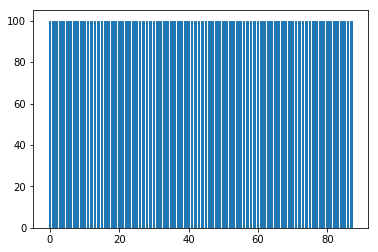

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1416 [0/5702 (0%)]	Loss: 0.000121
Train Epoch: 1417 [0/5702 (0%)]	Loss: 0.000090
Train Epoch: 1418 [0/5702 (0%)]	Loss: 0.000029
Train Epoch: 1419 [0/5702 (0%)]	Loss: 0.000264
Train Epoch: 1420 [0/5702 (0%)]	Loss: 0.000139


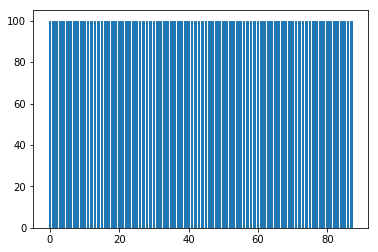

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1421 [0/5702 (0%)]	Loss: 0.000028
Train Epoch: 1422 [0/5702 (0%)]	Loss: 0.000128
Train Epoch: 1423 [0/5702 (0%)]	Loss: 0.000045
Train Epoch: 1424 [0/5702 (0%)]	Loss: 0.000070
Train Epoch: 1425 [0/5702 (0%)]	Loss: 0.000085


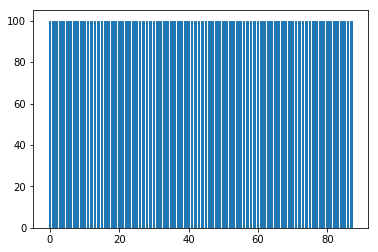

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1426 [0/5702 (0%)]	Loss: 0.000112
Train Epoch: 1427 [0/5702 (0%)]	Loss: 0.000055
Train Epoch: 1428 [0/5702 (0%)]	Loss: 0.000142
Train Epoch: 1429 [0/5702 (0%)]	Loss: 0.000085
Train Epoch: 1430 [0/5702 (0%)]	Loss: 0.000159


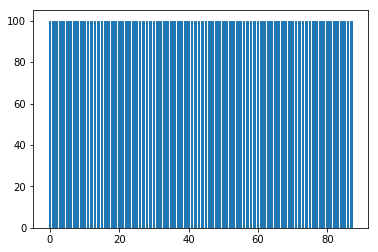

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1431 [0/5702 (0%)]	Loss: 0.000058
Train Epoch: 1432 [0/5702 (0%)]	Loss: 0.000118
Train Epoch: 1433 [0/5702 (0%)]	Loss: 0.000099
Train Epoch: 1434 [0/5702 (0%)]	Loss: 0.000069
Train Epoch: 1435 [0/5702 (0%)]	Loss: 0.000061


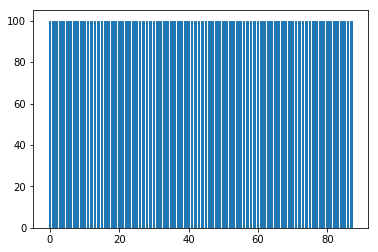

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1436 [0/5702 (0%)]	Loss: 0.000097
Train Epoch: 1437 [0/5702 (0%)]	Loss: 0.000063
Train Epoch: 1438 [0/5702 (0%)]	Loss: 0.000068
Train Epoch: 1439 [0/5702 (0%)]	Loss: 0.000061
Train Epoch: 1440 [0/5702 (0%)]	Loss: 0.000101


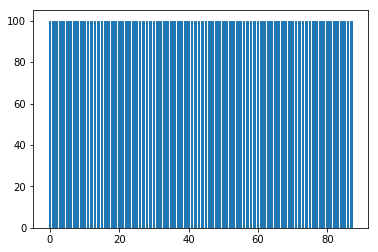

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1441 [0/5702 (0%)]	Loss: 0.000061
Train Epoch: 1442 [0/5702 (0%)]	Loss: 0.000255
Train Epoch: 1443 [0/5702 (0%)]	Loss: 0.000883
Train Epoch: 1444 [0/5702 (0%)]	Loss: 0.000210
Train Epoch: 1445 [0/5702 (0%)]	Loss: 0.000134


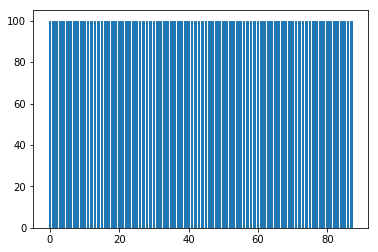

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1446 [0/5702 (0%)]	Loss: 0.000183
Train Epoch: 1447 [0/5702 (0%)]	Loss: 0.000050
Train Epoch: 1448 [0/5702 (0%)]	Loss: 0.000077
Train Epoch: 1449 [0/5702 (0%)]	Loss: 0.000063
Train Epoch: 1450 [0/5702 (0%)]	Loss: 0.000098


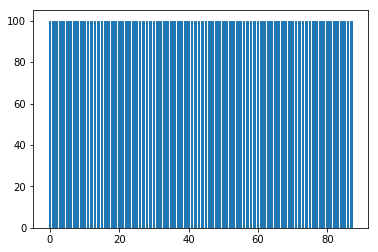

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1451 [0/5702 (0%)]	Loss: 0.000063
Train Epoch: 1452 [0/5702 (0%)]	Loss: 0.000079
Train Epoch: 1453 [0/5702 (0%)]	Loss: 0.000120
Train Epoch: 1454 [0/5702 (0%)]	Loss: 0.000051
Train Epoch: 1455 [0/5702 (0%)]	Loss: 0.000090


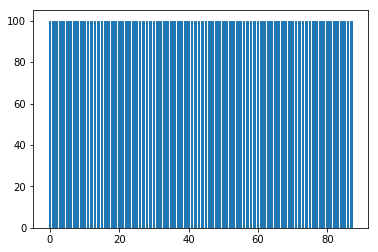

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1456 [0/5702 (0%)]	Loss: 0.000050
Train Epoch: 1457 [0/5702 (0%)]	Loss: 0.000069
Train Epoch: 1458 [0/5702 (0%)]	Loss: 0.000047
Train Epoch: 1459 [0/5702 (0%)]	Loss: 0.000324
Train Epoch: 1460 [0/5702 (0%)]	Loss: 0.000043


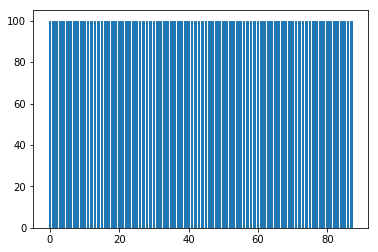

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1461 [0/5702 (0%)]	Loss: 0.000080
Train Epoch: 1462 [0/5702 (0%)]	Loss: 0.000060
Train Epoch: 1463 [0/5702 (0%)]	Loss: 0.000884
Train Epoch: 1464 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1465 [0/5702 (0%)]	Loss: 0.000074


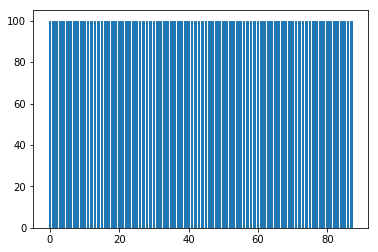

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1466 [0/5702 (0%)]	Loss: 0.000051
Train Epoch: 1467 [0/5702 (0%)]	Loss: 0.000068
Train Epoch: 1468 [0/5702 (0%)]	Loss: 0.000090
Train Epoch: 1469 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1470 [0/5702 (0%)]	Loss: 0.000090


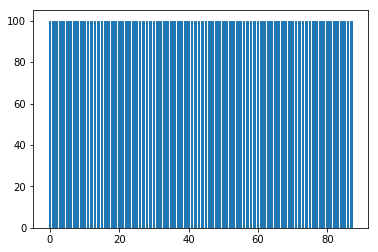

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1471 [0/5702 (0%)]	Loss: 0.000113
Train Epoch: 1472 [0/5702 (0%)]	Loss: 0.000283
Train Epoch: 1473 [0/5702 (0%)]	Loss: 0.000080
Train Epoch: 1474 [0/5702 (0%)]	Loss: 0.000080
Train Epoch: 1475 [0/5702 (0%)]	Loss: 0.000098


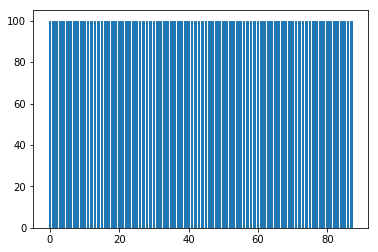

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1476 [0/5702 (0%)]	Loss: 0.000058
Train Epoch: 1477 [0/5702 (0%)]	Loss: 0.000056
Train Epoch: 1478 [0/5702 (0%)]	Loss: 0.000107
Train Epoch: 1479 [0/5702 (0%)]	Loss: 0.000036
Train Epoch: 1480 [0/5702 (0%)]	Loss: 0.000053


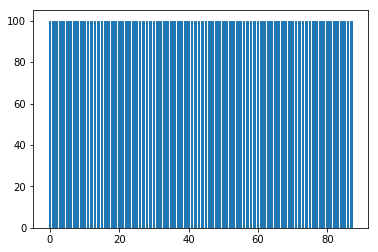

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1481 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1482 [0/5702 (0%)]	Loss: 0.000071
Train Epoch: 1483 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1484 [0/5702 (0%)]	Loss: 0.000035
Train Epoch: 1485 [0/5702 (0%)]	Loss: 0.000106


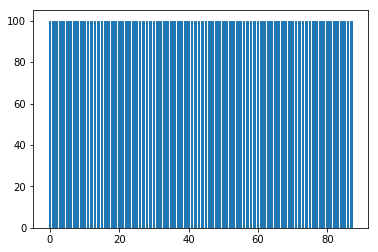

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1486 [0/5702 (0%)]	Loss: 0.000082
Train Epoch: 1487 [0/5702 (0%)]	Loss: 0.000078
Train Epoch: 1488 [0/5702 (0%)]	Loss: 0.000072
Train Epoch: 1489 [0/5702 (0%)]	Loss: 0.000083
Train Epoch: 1490 [0/5702 (0%)]	Loss: 0.000072


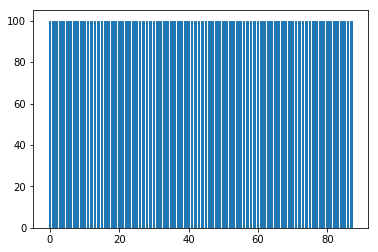

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1491 [0/5702 (0%)]	Loss: 0.000091
Train Epoch: 1492 [0/5702 (0%)]	Loss: 0.000084
Train Epoch: 1493 [0/5702 (0%)]	Loss: 0.000152
Train Epoch: 1494 [0/5702 (0%)]	Loss: 0.000185
Train Epoch: 1495 [0/5702 (0%)]	Loss: 0.000080


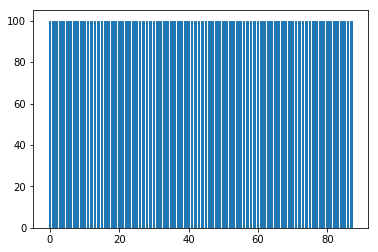

300
0

Test set: Average loss: 0.0000, Accuracy: 300/300 (100%)

Train Epoch: 1496 [0/5702 (0%)]	Loss: 0.000035
Train Epoch: 1497 [0/5702 (0%)]	Loss: 0.000086
Train Epoch: 1498 [0/5702 (0%)]	Loss: 0.000055
Train Epoch: 1499 [0/5702 (0%)]	Loss: 0.000071


In [58]:
epochs=1500
log_interval=100
# run the main training loop
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.data.item()))
    if epoch % 5==0:
        test_func(test_loader)

In [ ]:
#deploy for onnx
dummy_input = torch.randn(1, buf)
torch.onnx.export(net, dummy_input, PATH+"nn_pianovstup_2048X2b.onnx")

In [48]:

# Load the ONNX model
model = onnx.load(PATH+"nn_pianovstup_2048X2b.onnx")
# Check that the IR is well formed
onnx.checker.check_model(model)
# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)


u'graph torch-jit-export (\n  %0[FLOAT, 1x2048]\n) optional inputs with matching initializers (\n  %conv1.weight[FLOAT, 1x2x1]\n  %conv1.bias[FLOAT, 1]\n  %fc.weight[FLOAT, 176x1024]\n  %fc2.weight[FLOAT, 88x176]\n) {\n  %5 = Constant[value = <Tensor>]()\n  %6 = Reshape(%0, %5)\n  %7 = Slice[axes = [2], ends = [1024], starts = [0]](%6)\n  %8 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%7, %conv1.weight, %conv1.bias)\n  %9 = Relu(%8)\n  %10 = MaxPool[kernel_shape = [1], pads = [0, 0], strides = [1]](%9)\n  %11 = Constant[value = <Tensor>]()\n  %12 = Reshape(%10, %11)\n  %13 = Transpose[perm = [1, 0]](%fc.weight)\n  %14 = MatMul(%12, %13)\n  %15 = Transpose[perm = [1, 0]](%fc2.weight)\n  %16 = MatMul(%14, %15)\n  return %16\n}'